In [1]:
import os
from PIL import Image
from torch.utils.data import Dataset
import torchvision.transforms as T
import torch

class EdgeCornerDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        self.rgb_dir = os.path.join(root_dir, 'rgb')
        self.canny_dir = os.path.join(root_dir, 'canny')
        self.harris_dir = os.path.join(root_dir, 'harris')
        self.filenames = sorted(os.listdir(self.rgb_dir))
        self.transform = transform

        self.default_transform = T.Compose([
            T.ToTensor(),  # Converts [H, W, C] to [C, H, W] and scales to [0,1]
        ])

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        file_name = self.filenames[idx]
        rgb_path = os.path.join(self.rgb_dir, file_name)
        canny_path = os.path.join(self.canny_dir, file_name)
        harris_path = os.path.join(self.harris_dir, file_name)

        image = Image.open(rgb_path).convert('RGB')
        canny = Image.open(canny_path).convert('L')  # single channel
        harris = Image.open(harris_path).convert('L')

        image = self.default_transform(image)
        canny = self.default_transform(canny)
        harris = self.default_transform(harris)

        labels = torch.cat([canny, harris], dim = 0)

        return image, labels

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetDualHead(nn.Module):
    def __init__(self):
        super(UNetDualHead, self).__init__()

        def conv_block(input_channels, output_channels):
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace = True),
                nn.Conv2d(output_channels, output_channels, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(output_channels),
                nn.ReLU(inplace = True),
            )

        # Shared encoder
        self.enc1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Shared bottleneck
        self.bottleneck = conv_block(256, 512)

        # Decoder (shared for both heads)
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)
        self.dec1 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)
        self.dec2 = conv_block(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)
        self.dec3 = conv_block(128, 64)

        # Dual output heads
        self.out_edge = nn.Conv2d(64, 1, kernel_size = 1)
        self.out_corner = nn.Conv2d(64, 1, kernel_size = 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b = self.bottleneck(self.pool3(e3))

        d1 = self.up1(b)
        d1 = self.dec1(torch.cat([d1, e3], dim = 1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e2], dim = 1))
        d3 = self.up3(d2)
        d3 = self.dec3(torch.cat([d3, e1], dim = 1))

        out_edge = torch.sigmoid(self.out_edge(d3))
        out_corner = torch.sigmoid(self.out_corner(d3))

        return torch.cat([out_edge, out_corner], dim = 1)  # shape: [B, 2, H, W]

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class BasicBlock(nn.Module):
    def __init__(self, input_channel, output_channel, stride = 1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size = 3, stride = stride, padding = 1)
        self.bn1 = nn.BatchNorm2d(output_channel)
        self.relu = nn.ReLU(inplace = True)
        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size = 3, padding = 1)
        self.bn2 = nn.BatchNorm2d(output_channel)

        self.downsample = None
        if input_channel != output_channel or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size = 1, stride = stride),
                nn.BatchNorm2d(output_channel)
            )

    def forward(self, x):
        identity = x
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        
        if self.downsample:
            identity = self.downsample(identity)
            
        return self.relu(out + identity)

class ResNetLiteDualHeadSkip(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(input_channel, output_channel):
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace = True),
                nn.Conv2d(output_channel, output_channel, kernel_size = 3, padding = 1),
                nn.BatchNorm2d(output_channel),
                nn.ReLU(inplace = True),
            )

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        )

        # Encoder
        self.layer1 = BasicBlock(64, 128, stride = 2)   # 128 × 64 × 64
        self.layer2 = BasicBlock(128, 256, stride = 2)  # 256 × 32 × 32
        self.layer3 = BasicBlock(256, 512, stride = 2)  # 512 × 16 × 16

        # Decoder upsampling
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size = 2, stride = 2)  # → 32 × 32
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size = 2, stride = 2)  # → 64 × 64
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size = 2, stride = 2)   # → 128 × 128
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size = 2, stride = 2)    # → 256 × 256
        self.up5 = nn.ConvTranspose2d(32, 16, kernel_size = 2, stride = 2)    # → 512 × 512

        # Decoder conv blocks with skip connections
        self.dec1 = conv_block(256 + 256, 256)
        self.dec2 = conv_block(128 + 128, 128)
        self.dec3 = conv_block(64 + 64, 64)
        self.dec4 = conv_block(32, 32)
        self.dec5 = conv_block(16, 16)

        # Output heads
        self.out_edge = nn.Conv2d(16, 1, kernel_size=1)
        self.out_corner = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        # Encoder
        s = self.stem(x)     # 64 × 128 × 128
        l1 = self.layer1(s)  # 128 × 64 × 64
        l2 = self.layer2(l1) # 256 × 32 × 32
        l3 = self.layer3(l2) # 512 × 16 × 16

        # Decoder with skip connections
        x = self.up1(l3)                      # 256 × 32 × 32
        x = self.dec1(torch.cat([x, l2], 1))

        x = self.up2(x)                       # 128 × 64 × 64
        x = self.dec2(torch.cat([x, l1], 1))

        x = self.up3(x)                       # 64 × 128 × 128
        x = self.dec3(torch.cat([x, s], 1))

        x = self.up4(x)                       # 32 × 256 × 256
        x = self.dec4(x)

        x = self.up5(x)                       # 16 × 512 × 512
        x = self.dec5(x)

        # Output heads
        edge = torch.sigmoid(self.out_edge(x))
        corner = torch.sigmoid(self.out_corner(x))

        return torch.cat([edge, corner], dim = 1)  # [B, 2, 512, 512]

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
# from model import ResNetLiteDualHeadSkip, UNetDualHead

def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection + 1e-6
    return (intersection / union).item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return (2 * precision * recall / (precision + recall + 1e-6)).item()

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    iou_edge = iou_corner = f1_edge = f1_corner = 0.0
    count = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            for i in range(images.size(0)):
                pred, gt = outputs[i], labels[i]
                iou_edge += compute_iou(pred[0], gt[0])
                iou_corner += compute_iou(pred[1], gt[1])
                f1_edge += compute_f1(pred[0], gt[0])
                f1_corner += compute_f1(pred[1], gt[1])
                count += 1
    return {
        "val_loss": total_loss / len(dataloader),
        "iou_edge": iou_edge / count,
        "iou_corner": iou_corner / count,
        "f1_edge": f1_edge / count,
        "f1_corner": f1_corner / count,
    }

def plot_metrics(history, model_name):
    epochs = range(1, len(history["val_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["val_loss"], label="Val Loss", linestyle='--', marker='o')
    plt.plot(epochs, history["train_loss"], label="Train Loss", linestyle='-', marker='x')
    plt.title(f"{model_name} Loss")

    # --- Metrics Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["iou_edge"], label="IoU Edge", linestyle='-', marker='D')
    plt.plot(epochs, history["iou_corner"], label="IoU Corner", linestyle='--', marker='s')
    plt.plot(epochs, history["f1_edge"], label="F1 Edge", linestyle='-.', marker='^')
    plt.plot(epochs, history["f1_corner"], label="F1 Corner", linestyle=':', marker='v')
    plt.title(f"{model_name} Metrics")

    # --- Shared Plot Formatting ---
    for ax in plt.gcf().axes:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle=':', linewidth=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.grid(True)
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    plt.savefig(f"/kaggle/working/plots/{model_name.lower()}_metrics_bce.png")
    plt.show()

def export_metrics_csv(history, model_name):
    os.makedirs("/kaggle/working/metrics", exist_ok = True)
    file_path = f"/kaggle/working/metrics/{model_name.lower()}_metrics_bce.csv"
    
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Val Loss", "IoU Edge", "IoU Corner", "F1 Edge", "F1 Corner"])
        for i in range(len(history["val_loss"])):
            writer.writerow([
                i+1,
                history["train_loss"][i], history["val_loss"][i],
                history["iou_edge"][i], history["iou_corner"][i],
                history["f1_edge"][i], history["f1_corner"][i]
            ])
            
def compare_predictions(model1, model2, dataloader, device):
    model1.eval(); model2.eval()
    imgs, labels = next(iter(dataloader))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        preds1 = model1(imgs)
        preds2 = model2(imgs)
        
    for i in range(1):
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        edge1 = preds1[i, 0].cpu().numpy()
        corner1 = preds1[i, 1].cpu().numpy()
        edge2 = preds2[i, 0].cpu().numpy()
        corner2 = preds2[i, 1].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        axes[0, 0].imshow(img)
        axes[0, 1].imshow(edge1, cmap='gray')
        axes[0, 2].imshow(corner1, cmap='gray')
        axes[1, 1].imshow(edge2, cmap='gray')
        axes[1, 2].imshow(corner2, cmap='gray')
        
        for ax in axes.flat: ax.axis("off")
        axes[0, 0].set_title("Input")
        axes[0, 1].set_title("ResNet Edge")
        axes[0, 2].set_title("ResNet Corner")
        axes[1, 1].set_title("UNet Edge")
        axes[1, 2].set_title("UNet Corner")
        
        plt.tight_layout()
        os.makedirs("/kaggle/working/predictions", exist_ok=True)
        plt.savefig(f"/kaggle/working/predictions/single_image_bce.png")
        plt.show()

## Binary Cross Entropy 


Epoch 1/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.23it/s]


Train Loss: 0.6919 | Val Loss: 0.6663 | IoU(E): 0.070 | F1(E): 0.129 | IoU(C): 0.003 | F1(C): 0.007
Saved new best ResNet model

Epoch 2/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.68it/s]


Train Loss: 0.5924 | Val Loss: 0.6659 | IoU(E): 0.122 | F1(E): 0.214 | IoU(C): 0.009 | F1(C): 0.017
Saved new best ResNet model

Epoch 3/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.62it/s]


Train Loss: 0.5291 | Val Loss: 0.4702 | IoU(E): 0.066 | F1(E): 0.121 | IoU(C): 0.006 | F1(C): 0.012
Saved new best ResNet model

Epoch 4/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.56it/s]


Train Loss: 0.4775 | Val Loss: 0.4401 | IoU(E): 0.065 | F1(E): 0.122 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 5/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.65it/s]


Train Loss: 0.4305 | Val Loss: 0.3950 | IoU(E): 0.086 | F1(E): 0.158 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 6/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.68it/s]


Train Loss: 0.3849 | Val Loss: 0.4047 | IoU(E): 0.090 | F1(E): 0.164 | IoU(C): 0.000 | F1(C): 0.000

Epoch 7/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.3418 | Val Loss: 0.2976 | IoU(E): 0.000 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 8/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.3035 | Val Loss: 0.2693 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 9/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.2705 | Val Loss: 0.3220 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 10/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.2433 | Val Loss: 0.3798 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 11/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.2271 | Val Loss: 0.1880 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 12/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.2132 | Val Loss: 0.1851 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 13/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.2028 | Val Loss: 0.1808 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 14/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1944 | Val Loss: 0.1680 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 15/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1870 | Val Loss: 0.1665 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 16/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1792 | Val Loss: 0.1519 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 17/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1749 | Val Loss: 0.1480 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 18/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.31it/s]


Train Loss: 0.1691 | Val Loss: 0.1416 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 19/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1625 | Val Loss: 0.1528 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 20/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1589 | Val Loss: 0.1343 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 21/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1551 | Val Loss: 0.1588 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 22/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1525 | Val Loss: 0.1265 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 23/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1498 | Val Loss: 0.1277 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 24/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1495 | Val Loss: 0.1239 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 25/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1465 | Val Loss: 0.1236 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 26/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1450 | Val Loss: 0.1232 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 27/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1417 | Val Loss: 0.1225 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 28/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.56it/s]


Train Loss: 0.1401 | Val Loss: 0.1176 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 29/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1377 | Val Loss: 0.1155 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 30/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1363 | Val Loss: 0.1218 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 31/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1350 | Val Loss: 0.1202 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 32/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1333 | Val Loss: 0.1142 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 33/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1341 | Val Loss: 0.1096 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 34/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1314 | Val Loss: 0.1150 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 35/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1313 | Val Loss: 0.1169 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 36/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1295 | Val Loss: 0.1143 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 37/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1281 | Val Loss: 0.1096 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 38/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1277 | Val Loss: 0.1078 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 39/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1258 | Val Loss: 0.1104 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.001

Epoch 40/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1264 | Val Loss: 0.1073 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.001
Saved new best ResNet model

Epoch 41/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1255 | Val Loss: 0.1049 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.001
Saved new best ResNet model

Epoch 42/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1244 | Val Loss: 0.1075 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 43/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1243 | Val Loss: 0.1082 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.001

Epoch 44/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1244 | Val Loss: 0.1064 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.001

Epoch 45/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1233 | Val Loss: 0.1062 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.001

Epoch 46/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1226 | Val Loss: 0.1038 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.001
Saved new best ResNet model

Epoch 47/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1224 | Val Loss: 0.1036 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 48/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1226 | Val Loss: 0.1036 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 49/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1240 | Val Loss: 0.1051 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.001

Epoch 50/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1220 | Val Loss: 0.1032 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 51/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1209 | Val Loss: 0.1043 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002

Epoch 52/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1217 | Val Loss: 0.1023 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 53/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1205 | Val Loss: 0.1017 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 54/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1208 | Val Loss: 0.1046 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.003

Epoch 55/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1212 | Val Loss: 0.1051 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.003 | F1(C): 0.006

Epoch 56/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1204 | Val Loss: 0.1011 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.003
Saved new best ResNet model

Epoch 57/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1199 | Val Loss: 0.1064 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.003 | F1(C): 0.006

Epoch 58/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1196 | Val Loss: 0.1003 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.002 | F1(C): 0.005
Saved new best ResNet model

Epoch 59/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1193 | Val Loss: 0.1010 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.002 | F1(C): 0.005

Epoch 60/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1184 | Val Loss: 0.1015 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.004 | F1(C): 0.008

Epoch 61/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1197 | Val Loss: 0.1025 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.005 | F1(C): 0.010

Epoch 62/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1191 | Val Loss: 0.1015 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.004 | F1(C): 0.008

Epoch 63/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1190 | Val Loss: 0.1012 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.005 | F1(C): 0.010

Epoch 64/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1181 | Val Loss: 0.1007 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.005 | F1(C): 0.010

Epoch 65/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1184 | Val Loss: 0.1016 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.007 | F1(C): 0.013

Epoch 66/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1190 | Val Loss: 0.1020 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.005 | F1(C): 0.009

Epoch 67/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1185 | Val Loss: 0.1022 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.006 | F1(C): 0.012

Epoch 68/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1185 | Val Loss: 0.1002 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.005 | F1(C): 0.010
Saved new best ResNet model

Epoch 69/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1190 | Val Loss: 0.0996 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.005 | F1(C): 0.009
Saved new best ResNet model

Epoch 70/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1181 | Val Loss: 0.1010 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.009 | F1(C): 0.017

Epoch 71/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1175 | Val Loss: 0.1008 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.007 | F1(C): 0.014

Epoch 72/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1176 | Val Loss: 0.1003 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.006 | F1(C): 0.011

Epoch 73/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1180 | Val Loss: 0.1003 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.007 | F1(C): 0.013

Epoch 74/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1177 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.006 | F1(C): 0.012

Epoch 75/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1179 | Val Loss: 0.1000 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.008 | F1(C): 0.015

Epoch 76/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Train Loss: 0.1177 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.008 | F1(C): 0.016

Epoch 77/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1170 | Val Loss: 0.1006 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.009 | F1(C): 0.018

Epoch 78/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1171 | Val Loss: 0.1003 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.010 | F1(C): 0.019

Epoch 79/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1204 | Val Loss: 0.0992 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.008 | F1(C): 0.015
Saved new best ResNet model

Epoch 80/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1170 | Val Loss: 0.1000 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.012 | F1(C): 0.023

Epoch 81/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1185 | Val Loss: 0.0988 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.007 | F1(C): 0.015
Saved new best ResNet model

Epoch 82/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1177 | Val Loss: 0.0995 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.009 | F1(C): 0.018

Epoch 83/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1172 | Val Loss: 0.1005 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.011 | F1(C): 0.021

Epoch 84/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1173 | Val Loss: 0.1007 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.011 | F1(C): 0.021

Epoch 85/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1176 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.012 | F1(C): 0.023

Epoch 86/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1169 | Val Loss: 0.1011 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.012 | F1(C): 0.023

Epoch 87/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1173 | Val Loss: 0.0994 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.008 | F1(C): 0.017

Epoch 88/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1175 | Val Loss: 0.0989 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.009 | F1(C): 0.017

Epoch 89/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1168 | Val Loss: 0.0991 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.012 | F1(C): 0.023

Epoch 90/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1168 | Val Loss: 0.1005 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.012 | F1(C): 0.023

Epoch 91/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1172 | Val Loss: 0.0995 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.011 | F1(C): 0.021

Epoch 92/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1169 | Val Loss: 0.1008 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.014 | F1(C): 0.028

Epoch 93/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1169 | Val Loss: 0.1000 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.013 | F1(C): 0.025

Epoch 94/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1171 | Val Loss: 0.0993 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.011 | F1(C): 0.022

Epoch 95/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1166 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.011 | F1(C): 0.022

Epoch 96/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1170 | Val Loss: 0.1001 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.012 | F1(C): 0.023

Epoch 97/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1175 | Val Loss: 0.0991 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.012 | F1(C): 0.023

Epoch 98/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1176 | Val Loss: 0.0995 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.012 | F1(C): 0.023

Epoch 99/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1172 | Val Loss: 0.0997 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.010 | F1(C): 0.020

Epoch 100/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1167 | Val Loss: 0.1001 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.011 | F1(C): 0.021

Epoch 1/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.4707 | Val Loss: 0.5206 | IoU(E): 0.072 | F1(E): 0.133 | IoU(C): 0.002 | F1(C): 0.003
Saved new best UNet model

Epoch 2/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.2904 | Val Loss: 0.2469 | IoU(E): 0.209 | F1(E): 0.327 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 3/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2046 | Val Loss: 0.2105 | IoU(E): 0.354 | F1(E): 0.493 | IoU(C): 0.016 | F1(C): 0.027
Saved new best UNet model

Epoch 4/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1515 | Val Loss: 0.1773 | IoU(E): 0.495 | F1(E): 0.650 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 5/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1206 | Val Loss: 0.1087 | IoU(E): 0.553 | F1(E): 0.701 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 6/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0998 | Val Loss: 0.0886 | IoU(E): 0.586 | F1(E): 0.733 | IoU(C): 0.019 | F1(C): 0.034
Saved new best UNet model

Epoch 7/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0865 | Val Loss: 0.0815 | IoU(E): 0.613 | F1(E): 0.754 | IoU(C): 0.002 | F1(C): 0.004
Saved new best UNet model

Epoch 8/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0835 | Val Loss: 0.0673 | IoU(E): 0.619 | F1(E): 0.759 | IoU(C): 0.001 | F1(C): 0.001
Saved new best UNet model

Epoch 9/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0709 | Val Loss: 0.0618 | IoU(E): 0.635 | F1(E): 0.771 | IoU(C): 0.001 | F1(C): 0.001
Saved new best UNet model

Epoch 10/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0687 | Val Loss: 0.0719 | IoU(E): 0.610 | F1(E): 0.751 | IoU(C): 0.004 | F1(C): 0.008

Epoch 11/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0665 | Val Loss: 0.0530 | IoU(E): 0.667 | F1(E): 0.796 | IoU(C): 0.021 | F1(C): 0.040
Saved new best UNet model

Epoch 12/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0647 | Val Loss: 0.0575 | IoU(E): 0.649 | F1(E): 0.782 | IoU(C): 0.041 | F1(C): 0.075

Epoch 13/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0596 | Val Loss: 0.0488 | IoU(E): 0.673 | F1(E): 0.800 | IoU(C): 0.054 | F1(C): 0.096
Saved new best UNet model

Epoch 14/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0572 | Val Loss: 0.0500 | IoU(E): 0.683 | F1(E): 0.808 | IoU(C): 0.165 | F1(C): 0.265

Epoch 15/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0552 | Val Loss: 0.0471 | IoU(E): 0.683 | F1(E): 0.807 | IoU(C): 0.182 | F1(C): 0.290
Saved new best UNet model

Epoch 16/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0550 | Val Loss: 0.0437 | IoU(E): 0.667 | F1(E): 0.795 | IoU(C): 0.155 | F1(C): 0.251
Saved new best UNet model

Epoch 17/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0551 | Val Loss: 0.0454 | IoU(E): 0.682 | F1(E): 0.807 | IoU(C): 0.119 | F1(C): 0.199

Epoch 18/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0544 | Val Loss: 0.0442 | IoU(E): 0.692 | F1(E): 0.814 | IoU(C): 0.247 | F1(C): 0.371

Epoch 19/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0505 | Val Loss: 0.0419 | IoU(E): 0.695 | F1(E): 0.816 | IoU(C): 0.302 | F1(C): 0.438
Saved new best UNet model

Epoch 20/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0508 | Val Loss: 0.0400 | IoU(E): 0.691 | F1(E): 0.813 | IoU(C): 0.138 | F1(C): 0.228
Saved new best UNet model

Epoch 21/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0482 | Val Loss: 0.0397 | IoU(E): 0.705 | F1(E): 0.823 | IoU(C): 0.247 | F1(C): 0.368
Saved new best UNet model

Epoch 22/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0477 | Val Loss: 0.0382 | IoU(E): 0.704 | F1(E): 0.822 | IoU(C): 0.254 | F1(C): 0.376
Saved new best UNet model

Epoch 23/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0461 | Val Loss: 0.0388 | IoU(E): 0.702 | F1(E): 0.820 | IoU(C): 0.246 | F1(C): 0.369

Epoch 24/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0473 | Val Loss: 0.0388 | IoU(E): 0.711 | F1(E): 0.828 | IoU(C): 0.322 | F1(C): 0.456

Epoch 25/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0459 | Val Loss: 0.0377 | IoU(E): 0.707 | F1(E): 0.825 | IoU(C): 0.358 | F1(C): 0.496
Saved new best UNet model

Epoch 26/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0444 | Val Loss: 0.0361 | IoU(E): 0.718 | F1(E): 0.832 | IoU(C): 0.367 | F1(C): 0.505
Saved new best UNet model

Epoch 27/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0458 | Val Loss: 0.0369 | IoU(E): 0.714 | F1(E): 0.830 | IoU(C): 0.354 | F1(C): 0.490

Epoch 28/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0432 | Val Loss: 0.0364 | IoU(E): 0.717 | F1(E): 0.832 | IoU(C): 0.383 | F1(C): 0.522

Epoch 29/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0440 | Val Loss: 0.0363 | IoU(E): 0.712 | F1(E): 0.828 | IoU(C): 0.370 | F1(C): 0.508

Epoch 30/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0453 | Val Loss: 0.0390 | IoU(E): 0.717 | F1(E): 0.832 | IoU(C): 0.293 | F1(C): 0.423

Epoch 31/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0412 | Val Loss: 0.0345 | IoU(E): 0.719 | F1(E): 0.833 | IoU(C): 0.331 | F1(C): 0.462
Saved new best UNet model

Epoch 32/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.11it/s]


Train Loss: 0.0414 | Val Loss: 0.0345 | IoU(E): 0.724 | F1(E): 0.836 | IoU(C): 0.335 | F1(C): 0.468
Saved new best UNet model

Epoch 33/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0416 | Val Loss: 0.0357 | IoU(E): 0.714 | F1(E): 0.829 | IoU(C): 0.300 | F1(C): 0.430

Epoch 34/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0402 | Val Loss: 0.0342 | IoU(E): 0.728 | F1(E): 0.839 | IoU(C): 0.354 | F1(C): 0.487
Saved new best UNet model

Epoch 35/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0423 | Val Loss: 0.0368 | IoU(E): 0.712 | F1(E): 0.828 | IoU(C): 0.345 | F1(C): 0.480


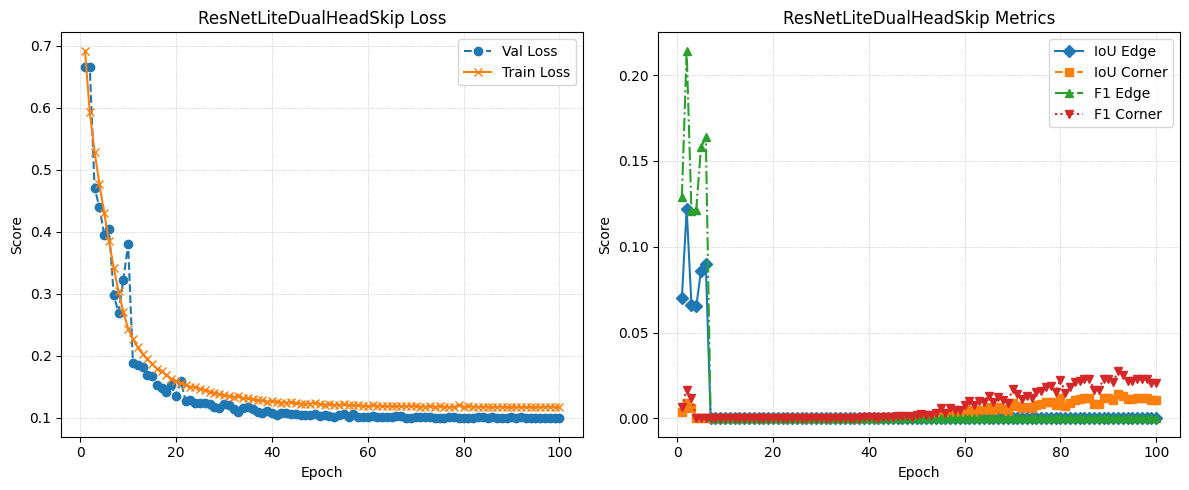

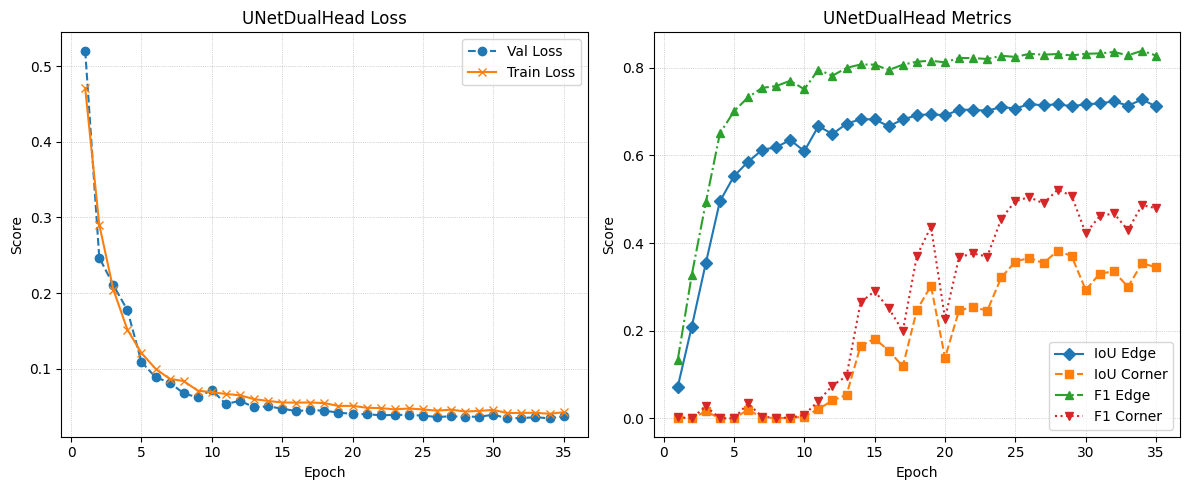

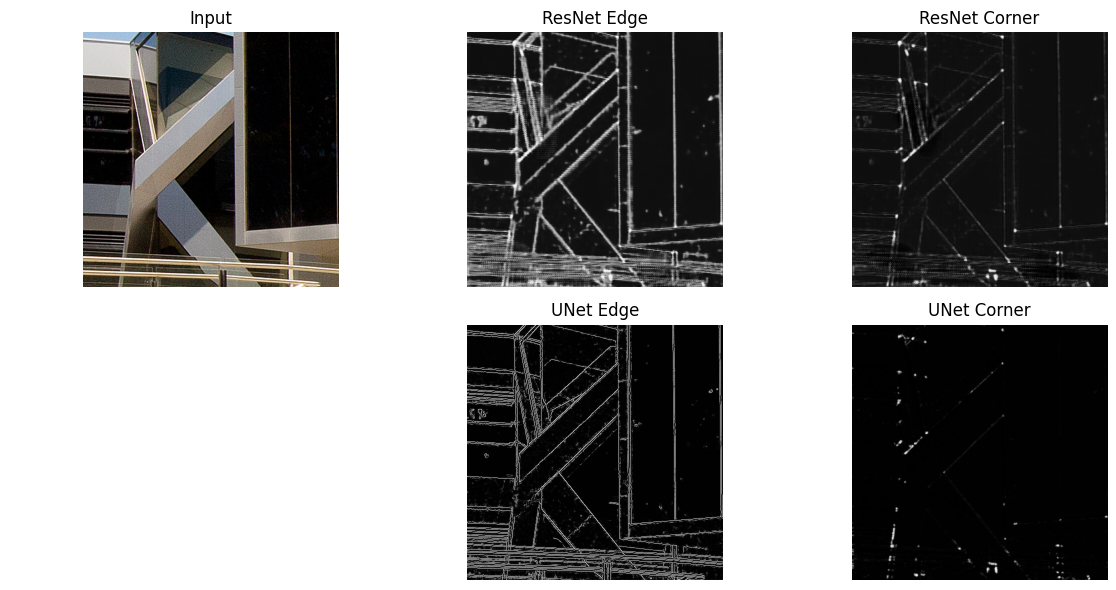

In [10]:
import torch
import torch.nn as nn
# from model import ResNetLiteDualHeadSkip, UNetDualHead
# from dataset import EdgeCornerDataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
# from train_utils import train_one_epoch, validate, plot_metrics, export_metrics_csv, compare_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4

dataset = EdgeCornerDataset(root_dir="/kaggle/input/jcsmr-data/data/filtered_crops/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model_1 = ResNetLiteDualHeadSkip().to(device)
model_2 = UNetDualHead().to(device)

loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.5)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=10, gamma=0.5)

resnet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}
unet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}

# ===================== TRAINING - RESNET =====================
best_val_loss = float("inf")
os.makedirs("/kaggle/working/models", exist_ok = True)
epochs = 100
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [ResNetLiteDualHeadSkip]")
    train_loss = train_one_epoch(model_1, train_loader, loss_fn, optimizer_1, device)
    val_metrics = validate(model_1, val_loader, loss_fn, device)
    scheduler_1.step()

    for key in resnet_history:
        resnet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    resnet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_1.state_dict(), "/kaggle/working/models/resnet_skip_best_bce.pth")
        print("Saved new best ResNet model")


# ===================== TRAINING - UNET =====================
best_val_loss = float("inf")
epochs = 35

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [UNetDualHead]")
    train_loss = train_one_epoch(model_2, train_loader, loss_fn, optimizer_2, device)
    val_metrics = validate(model_2, val_loader, loss_fn, device)
    scheduler_2.step()

    for key in unet_history:
        unet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    unet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_2.state_dict(), "/kaggle/working/models/unet_dual_head_best_bce.pth")
        print("Saved new best UNet model")

plot_metrics(resnet_history, "ResNetLiteDualHeadSkip")
export_metrics_csv(resnet_history, "ResNetLiteDualHeadSkip")

plot_metrics(unet_history, "UNetDualHead")
export_metrics_csv(unet_history, "UNetDualHead")

compare_predictions(model_1, model_2, val_loader, device)

## Weighted Binary Cross Entropy 

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm

def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection + 1e-6
    return (intersection / union).item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return (2 * precision * recall / (precision + recall + 1e-6)).item()

def weighted_bce_loss(pred, target, edge_weight = 1.0, corner_weight = 5.0):
    edge_loss = F.binary_cross_entropy(pred[:, 0], target[:, 0], reduction = 'none') * edge_weight
    corner_loss = F.binary_cross_entropy(pred[:, 1], target[:, 1], reduction = 'none') * corner_weight
    return (edge_loss.mean() + corner_loss.mean())

def train_one_epoch(model, dataloader, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = weighted_bce_loss(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader, device):
    model.eval()
    total_loss = 0.0
    iou_edge = iou_corner = f1_edge = f1_corner = 0.0
    count = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = weighted_bce_loss(outputs, labels)
            total_loss += loss.item()
            for i in range(images.size(0)):
                pred, gt = outputs[i], labels[i]
                iou_edge += compute_iou(pred[0], gt[0])
                iou_corner += compute_iou(pred[1], gt[1])
                f1_edge += compute_f1(pred[0], gt[0])
                f1_corner += compute_f1(pred[1], gt[1])
                count += 1
    return {
        "val_loss": total_loss / len(dataloader),
        "iou_edge": iou_edge / count,
        "iou_corner": iou_corner / count,
        "f1_edge": f1_edge / count,
        "f1_corner": f1_corner / count,
    }
def plot_metrics(history, model_name):
    epochs = range(1, len(history["val_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["val_loss"], label="Val Loss", linestyle='--', marker='o')
    plt.plot(epochs, history["train_loss"], label="Train Loss", linestyle='-', marker='x')
    plt.title(f"{model_name} Loss")

    # --- Metrics Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["iou_edge"], label="IoU Edge", linestyle='-', marker='D')
    plt.plot(epochs, history["iou_corner"], label="IoU Corner", linestyle='--', marker='s')
    plt.plot(epochs, history["f1_edge"], label="F1 Edge", linestyle='-.', marker='^')
    plt.plot(epochs, history["f1_corner"], label="F1 Corner", linestyle=':', marker='v')
    plt.title(f"{model_name} Metrics")

    for ax in plt.gcf().axes:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle=':', linewidth=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.grid(True)
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    plt.savefig(f"/kaggle/working/plots/{model_name.lower()}_metrics_wbce.png")
    plt.show()

def export_metrics_csv(history, model_name):
    os.makedirs("/kaggle/working/metrics", exist_ok = True)
    file_path = f"/kaggle/working/metrics/{model_name.lower()}_metrics_wbce.csv"
    
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Val Loss", "IoU Edge", "IoU Corner", "F1 Edge", "F1 Corner"])
        for i in range(len(history["val_loss"])):
            writer.writerow([
                i+1,
                history["train_loss"][i], history["val_loss"][i],
                history["iou_edge"][i], history["iou_corner"][i],
                history["f1_edge"][i], history["f1_corner"][i]
            ])

def compare_predictions(model1, model2, dataloader, device):
    model1.eval(); model2.eval()
    imgs, labels = next(iter(dataloader))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        preds1 = model1(imgs)
        preds2 = model2(imgs)
        
    for i in range(1):
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        edge1 = preds1[i, 0].cpu().numpy()
        corner1 = preds1[i, 1].cpu().numpy()
        edge2 = preds2[i, 0].cpu().numpy()
        corner2 = preds2[i, 1].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        axes[0, 0].imshow(img)
        axes[0, 1].imshow(edge1, cmap='gray')
        axes[0, 2].imshow(corner1, cmap='gray')
        axes[1, 1].imshow(edge2, cmap='gray')
        axes[1, 2].imshow(corner2, cmap='gray')
        
        for ax in axes.flat: ax.axis("off")
        axes[0, 0].set_title("Input")
        axes[0, 1].set_title("ResNet Edge")
        axes[0, 2].set_title("ResNet Corner")
        axes[1, 1].set_title("UNet Edge")
        axes[1, 2].set_title("UNet Corner")
        
        plt.tight_layout()
        os.makedirs("/kaggle/working/predictions", exist_ok=True)
        plt.savefig(f"/kaggle/working/predictions/single_image_wbce.png")
        plt.show()



Epoch 1/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 3.4910 | Val Loss: 4.5852 | IoU(E): 0.061 | F1(E): 0.115 | IoU(C): 0.006 | F1(C): 0.012
Saved new best ResNet model

Epoch 2/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 2.8145 | Val Loss: 3.6508 | IoU(E): 0.045 | F1(E): 0.082 | IoU(C): 0.013 | F1(C): 0.025
Saved new best ResNet model

Epoch 3/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 2.4699 | Val Loss: 2.2547 | IoU(E): 0.001 | F1(E): 0.002 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 4/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 2.1787 | Val Loss: 2.0283 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 5/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 1.9153 | Val Loss: 1.8004 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 6/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 1.6766 | Val Loss: 1.5386 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 7/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 1.4761 | Val Loss: 1.4304 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 8/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 1.3112 | Val Loss: 1.2770 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 9/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 1.1751 | Val Loss: 1.0566 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 10/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 1.0640 | Val Loss: 1.0321 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 11/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.9860 | Val Loss: 0.9932 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 12/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.9386 | Val Loss: 1.0286 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 13/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.9053 | Val Loss: 0.9573 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 14/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.8602 | Val Loss: 0.8585 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 15/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.8315 | Val Loss: 0.8031 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 16/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.7939 | Val Loss: 0.8013 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 17/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.7624 | Val Loss: 0.8025 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 18/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.7298 | Val Loss: 0.7233 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 19/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.6998 | Val Loss: 0.7965 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 20/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.6792 | Val Loss: 0.6934 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 21/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.6569 | Val Loss: 0.6728 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 22/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.6441 | Val Loss: 0.6340 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 23/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.6321 | Val Loss: 0.6464 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 24/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.6209 | Val Loss: 0.6284 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 25/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.6105 | Val Loss: 0.6278 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 26/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.6012 | Val Loss: 0.5953 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 27/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Train Loss: 0.5903 | Val Loss: 0.5861 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 28/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.5778 | Val Loss: 0.5700 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 29/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.5707 | Val Loss: 0.5591 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 30/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.5677 | Val Loss: 0.5498 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 31/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.5570 | Val Loss: 0.5396 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 32/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.5453 | Val Loss: 0.5542 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 33/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.5440 | Val Loss: 0.5369 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 34/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.5404 | Val Loss: 0.5459 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 35/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.5339 | Val Loss: 0.5429 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 36/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.5294 | Val Loss: 0.5332 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 37/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.5264 | Val Loss: 0.5263 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 38/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.5210 | Val Loss: 0.5204 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.006 | F1(C): 0.012
Saved new best ResNet model

Epoch 39/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.5165 | Val Loss: 0.5135 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.007 | F1(C): 0.013
Saved new best ResNet model

Epoch 40/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.5138 | Val Loss: 0.5116 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.018 | F1(C): 0.033
Saved new best ResNet model

Epoch 41/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.5106 | Val Loss: 0.5075 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.007 | F1(C): 0.013
Saved new best ResNet model

Epoch 42/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.5077 | Val Loss: 0.5028 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.017 | F1(C): 0.032
Saved new best ResNet model

Epoch 43/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.5044 | Val Loss: 0.5162 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.017 | F1(C): 0.032

Epoch 44/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.5057 | Val Loss: 0.5091 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.022 | F1(C): 0.041

Epoch 45/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.5014 | Val Loss: 0.5097 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.019 | F1(C): 0.036

Epoch 46/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.5043 | Val Loss: 0.4941 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.025 | F1(C): 0.046
Saved new best ResNet model

Epoch 47/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4975 | Val Loss: 0.4970 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.023 | F1(C): 0.044

Epoch 48/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.5005 | Val Loss: 0.4883 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.028 | F1(C): 0.053
Saved new best ResNet model

Epoch 49/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4943 | Val Loss: 0.4906 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.025 | F1(C): 0.046

Epoch 50/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.4913 | Val Loss: 0.4960 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.041 | F1(C): 0.075

Epoch 51/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.4900 | Val Loss: 0.4883 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.046 | F1(C): 0.084
Saved new best ResNet model

Epoch 52/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.4876 | Val Loss: 0.4893 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.049 | F1(C): 0.089

Epoch 53/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.4862 | Val Loss: 0.4871 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.047 | F1(C): 0.086
Saved new best ResNet model

Epoch 54/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.4866 | Val Loss: 0.4930 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.062 | F1(C): 0.112

Epoch 55/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.4871 | Val Loss: 0.4797 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.044 | F1(C): 0.081
Saved new best ResNet model

Epoch 56/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.4871 | Val Loss: 0.4858 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.057 | F1(C): 0.103

Epoch 57/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4840 | Val Loss: 0.4900 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.060 | F1(C): 0.107

Epoch 58/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.4807 | Val Loss: 0.4850 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.067 | F1(C): 0.120

Epoch 59/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4791 | Val Loss: 0.4836 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.061 | F1(C): 0.109

Epoch 60/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.4783 | Val Loss: 0.4845 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.070 | F1(C): 0.125

Epoch 61/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.4782 | Val Loss: 0.4806 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.069 | F1(C): 0.123

Epoch 62/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4771 | Val Loss: 0.4837 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.076 | F1(C): 0.136

Epoch 63/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.4804 | Val Loss: 0.4834 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.081 | F1(C): 0.143

Epoch 64/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4764 | Val Loss: 0.4795 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.075 | F1(C): 0.133
Saved new best ResNet model

Epoch 65/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4765 | Val Loss: 0.4811 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.075 | F1(C): 0.133

Epoch 66/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4785 | Val Loss: 0.4769 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.073 | F1(C): 0.131
Saved new best ResNet model

Epoch 67/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4747 | Val Loss: 0.4772 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.078 | F1(C): 0.138

Epoch 68/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4741 | Val Loss: 0.4805 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.082 | F1(C): 0.145

Epoch 69/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.4739 | Val Loss: 0.4761 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.075 | F1(C): 0.134
Saved new best ResNet model

Epoch 70/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4730 | Val Loss: 0.4767 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.081 | F1(C): 0.143

Epoch 71/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4732 | Val Loss: 0.4748 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.074 | F1(C): 0.131
Saved new best ResNet model

Epoch 72/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4729 | Val Loss: 0.4739 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.078 | F1(C): 0.137
Saved new best ResNet model

Epoch 73/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4721 | Val Loss: 0.4754 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.081 | F1(C): 0.142

Epoch 74/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4709 | Val Loss: 0.4753 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.078 | F1(C): 0.138

Epoch 75/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.4718 | Val Loss: 0.4752 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.080 | F1(C): 0.141

Epoch 76/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.98it/s]


Train Loss: 0.4748 | Val Loss: 0.4709 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.071 | F1(C): 0.127
Saved new best ResNet model

Epoch 77/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.4768 | Val Loss: 0.4718 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.081 | F1(C): 0.143

Epoch 78/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.4720 | Val Loss: 0.4734 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.082 | F1(C): 0.144

Epoch 79/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.4728 | Val Loss: 0.4736 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.083 | F1(C): 0.147

Epoch 80/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4715 | Val Loss: 0.4728 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.084 | F1(C): 0.148

Epoch 81/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.4702 | Val Loss: 0.4722 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.085 | F1(C): 0.149

Epoch 82/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4705 | Val Loss: 0.4754 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.094 | F1(C): 0.164

Epoch 83/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.4698 | Val Loss: 0.4719 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.084 | F1(C): 0.148

Epoch 84/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4695 | Val Loss: 0.4747 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.091 | F1(C): 0.159

Epoch 85/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4690 | Val Loss: 0.4744 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.085 | F1(C): 0.149

Epoch 86/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4716 | Val Loss: 0.4718 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.083 | F1(C): 0.147

Epoch 87/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4705 | Val Loss: 0.4750 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.091 | F1(C): 0.159

Epoch 88/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4710 | Val Loss: 0.4701 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.083 | F1(C): 0.146
Saved new best ResNet model

Epoch 89/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4692 | Val Loss: 0.4712 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.084 | F1(C): 0.148

Epoch 90/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4696 | Val Loss: 0.4718 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.085 | F1(C): 0.150

Epoch 91/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.4709 | Val Loss: 0.4732 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.091 | F1(C): 0.159

Epoch 92/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.4684 | Val Loss: 0.4721 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.084 | F1(C): 0.147

Epoch 93/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.4681 | Val Loss: 0.4725 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.087 | F1(C): 0.153

Epoch 94/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.4695 | Val Loss: 0.4705 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.084 | F1(C): 0.148

Epoch 95/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.4685 | Val Loss: 0.4710 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.085 | F1(C): 0.150

Epoch 96/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4675 | Val Loss: 0.4712 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.089 | F1(C): 0.156

Epoch 97/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.4701 | Val Loss: 0.4712 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.086 | F1(C): 0.151

Epoch 98/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4673 | Val Loss: 0.4707 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.088 | F1(C): 0.154

Epoch 99/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.4699 | Val Loss: 0.4705 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.087 | F1(C): 0.152

Epoch 100/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.4674 | Val Loss: 0.4717 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.087 | F1(C): 0.153

Epoch 1/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 2.4128 | Val Loss: 1.9804 | IoU(E): 0.003 | F1(E): 0.006 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 2/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 1.4468 | Val Loss: 1.2514 | IoU(E): 0.001 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 3/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 1.0304 | Val Loss: 0.9981 | IoU(E): 0.005 | F1(E): 0.009 | IoU(C): 0.001 | F1(C): 0.002
Saved new best UNet model

Epoch 4/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.7893 | Val Loss: 0.7533 | IoU(E): 0.005 | F1(E): 0.009 | IoU(C): 0.008 | F1(C): 0.016
Saved new best UNet model

Epoch 5/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train Loss: 0.6348 | Val Loss: 0.5778 | IoU(E): 0.006 | F1(E): 0.012 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 6/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.5426 | Val Loss: 0.6239 | IoU(E): 0.019 | F1(E): 0.035 | IoU(C): 0.000 | F1(C): 0.000

Epoch 7/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.4728 | Val Loss: 0.5105 | IoU(E): 0.287 | F1(E): 0.420 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 8/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.4190 | Val Loss: 0.5183 | IoU(E): 0.312 | F1(E): 0.449 | IoU(C): 0.000 | F1(C): 0.000

Epoch 9/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3681 | Val Loss: 0.4264 | IoU(E): 0.436 | F1(E): 0.576 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 10/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3389 | Val Loss: 0.3433 | IoU(E): 0.414 | F1(E): 0.551 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 11/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3075 | Val Loss: 0.3212 | IoU(E): 0.525 | F1(E): 0.669 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 12/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.2891 | Val Loss: 0.3758 | IoU(E): 0.568 | F1(E): 0.712 | IoU(C): 0.004 | F1(C): 0.007

Epoch 13/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2748 | Val Loss: 0.3462 | IoU(E): 0.576 | F1(E): 0.722 | IoU(C): 0.004 | F1(C): 0.008

Epoch 14/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.2559 | Val Loss: 0.2625 | IoU(E): 0.580 | F1(E): 0.722 | IoU(C): 0.022 | F1(C): 0.042
Saved new best UNet model

Epoch 15/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2505 | Val Loss: 0.2502 | IoU(E): 0.605 | F1(E): 0.743 | IoU(C): 0.101 | F1(C): 0.172
Saved new best UNet model

Epoch 16/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2394 | Val Loss: 0.2348 | IoU(E): 0.628 | F1(E): 0.763 | IoU(C): 0.111 | F1(C): 0.188
Saved new best UNet model

Epoch 17/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2293 | Val Loss: 0.2654 | IoU(E): 0.603 | F1(E): 0.742 | IoU(C): 0.063 | F1(C): 0.113

Epoch 18/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2221 | Val Loss: 0.2409 | IoU(E): 0.630 | F1(E): 0.764 | IoU(C): 0.243 | F1(C): 0.370

Epoch 19/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.2120 | Val Loss: 0.2212 | IoU(E): 0.647 | F1(E): 0.778 | IoU(C): 0.183 | F1(C): 0.290
Saved new best UNet model

Epoch 20/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2080 | Val Loss: 0.2027 | IoU(E): 0.662 | F1(E): 0.790 | IoU(C): 0.241 | F1(C): 0.366
Saved new best UNet model

Epoch 21/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.1892 | Val Loss: 0.1955 | IoU(E): 0.654 | F1(E): 0.784 | IoU(C): 0.285 | F1(C): 0.418
Saved new best UNet model

Epoch 22/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1919 | Val Loss: 0.1935 | IoU(E): 0.665 | F1(E): 0.793 | IoU(C): 0.320 | F1(C): 0.460
Saved new best UNet model

Epoch 23/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1880 | Val Loss: 0.1856 | IoU(E): 0.650 | F1(E): 0.783 | IoU(C): 0.320 | F1(C): 0.455
Saved new best UNet model

Epoch 24/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.1817 | Val Loss: 0.1810 | IoU(E): 0.653 | F1(E): 0.784 | IoU(C): 0.357 | F1(C): 0.495
Saved new best UNet model

Epoch 25/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.1783 | Val Loss: 0.1904 | IoU(E): 0.661 | F1(E): 0.789 | IoU(C): 0.283 | F1(C): 0.418

Epoch 26/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1794 | Val Loss: 0.1793 | IoU(E): 0.668 | F1(E): 0.795 | IoU(C): 0.329 | F1(C): 0.467
Saved new best UNet model

Epoch 27/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1723 | Val Loss: 0.1687 | IoU(E): 0.673 | F1(E): 0.799 | IoU(C): 0.291 | F1(C): 0.425
Saved new best UNet model

Epoch 28/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.1658 | Val Loss: 0.1700 | IoU(E): 0.670 | F1(E): 0.797 | IoU(C): 0.376 | F1(C): 0.513

Epoch 29/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.1599 | Val Loss: 0.1595 | IoU(E): 0.675 | F1(E): 0.800 | IoU(C): 0.340 | F1(C): 0.476
Saved new best UNet model

Epoch 30/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.1636 | Val Loss: 0.1714 | IoU(E): 0.681 | F1(E): 0.805 | IoU(C): 0.333 | F1(C): 0.471

Epoch 31/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1622 | Val Loss: 0.1608 | IoU(E): 0.685 | F1(E): 0.807 | IoU(C): 0.370 | F1(C): 0.508

Epoch 32/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1540 | Val Loss: 0.1588 | IoU(E): 0.680 | F1(E): 0.803 | IoU(C): 0.360 | F1(C): 0.498
Saved new best UNet model

Epoch 33/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1511 | Val Loss: 0.1593 | IoU(E): 0.687 | F1(E): 0.809 | IoU(C): 0.370 | F1(C): 0.508

Epoch 34/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.1594 | Val Loss: 0.1616 | IoU(E): 0.683 | F1(E): 0.806 | IoU(C): 0.398 | F1(C): 0.537

Epoch 35/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1660 | Val Loss: 0.1581 | IoU(E): 0.681 | F1(E): 0.804 | IoU(C): 0.310 | F1(C): 0.445
Saved new best UNet model


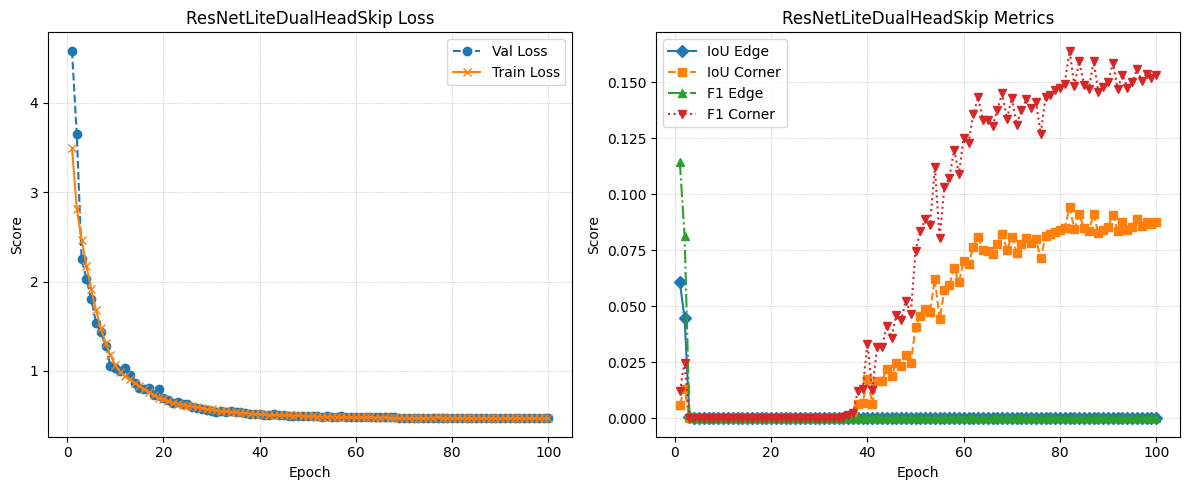

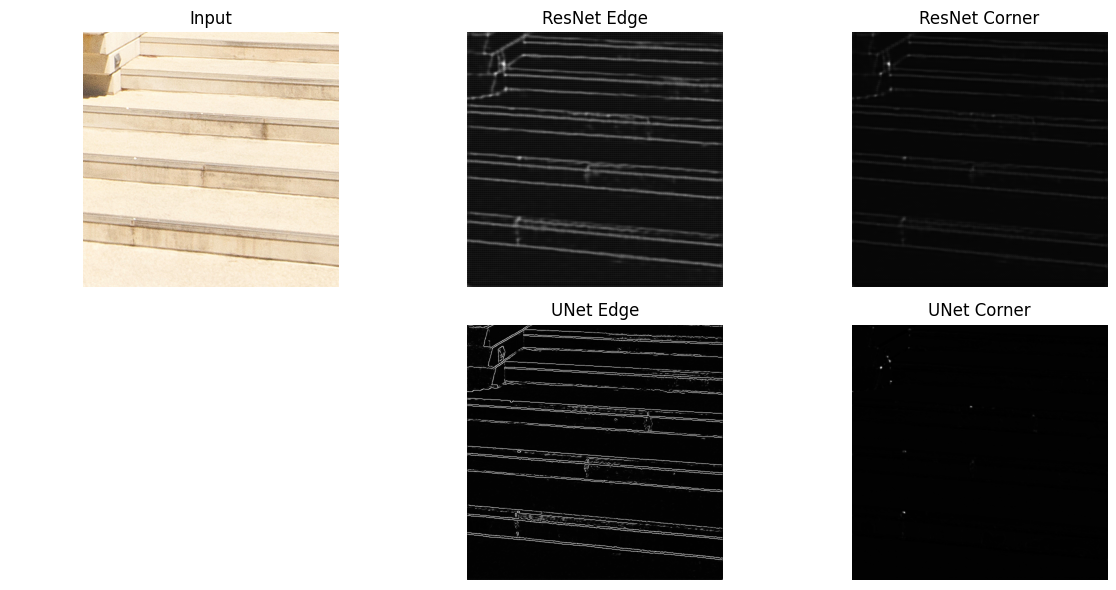

In [12]:
import torch
import torch.nn as nn
# from model import ResNetLiteDualHeadSkip, UNetDualHead
# from dataset import EdgeCornerDataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
# from train_utils import train_one_epoch, validate, plot_metrics, export_metrics_csv, compare_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4

dataset = EdgeCornerDataset(root_dir="/kaggle/input/jcsmr-data/data/filtered_crops/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model_1 = ResNetLiteDualHeadSkip().to(device)
model_2 = UNetDualHead().to(device)

loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.5)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=10, gamma=0.5)

resnet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}
unet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}

# ===================== TRAINING - RESNET =====================
best_val_loss = float("inf")
os.makedirs("/kaggle/working/models", exist_ok = True)
epochs = 100

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [ResNetLiteDualHeadSkip]")
    train_loss = train_one_epoch(model_1, train_loader, optimizer_1, device)
    val_metrics = validate(model_1, val_loader, device)
    scheduler_1.step()

    for key in resnet_history:
        resnet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    resnet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_1.state_dict(), "/kaggle/working/models/resnet_skip_best_wbce.pth")
        print("Saved new best ResNet model")

# ===================== TRAINING - UNET =====================
best_val_loss = float("inf")
epochs = 35

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [UNetDualHead]")
    train_loss = train_one_epoch(model_2, train_loader, optimizer_2, device)
    val_metrics = validate(model_2, val_loader, device)
    scheduler_2.step()

    for key in unet_history:
        unet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    unet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_2.state_dict(), "/kaggle/working/models/unet_dual_head_best_wbce.pth")
        print("Saved new best UNet model")

plot_metrics(resnet_history, "ResNetLiteDualHeadSkip")
export_metrics_csv(resnet_history, "ResNetLiteDualHeadSkip")

plot_metrics(unet_history, "UNetDualHead")
export_metrics_csv(unet_history, "UNetDualHead")

compare_predictions(model_1, model_2, val_loader, device)

## Focal Loss

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm

class FocalLoss(nn.Module):
    def __init__(self, alpha = 0.5, gamma = 2.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        eps = 1e-6
        inputs = torch.clamp(inputs, eps, 1. - eps)
        BCE = - (targets * torch.log(inputs) + (1 - targets) * torch.log(1 - inputs))
        pt = torch.where(targets == 1, inputs, 1 - inputs)
        FL = self.alpha * (1 - pt) ** self.gamma * BCE
        return FL.mean()

def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection + 1e-6
    return (intersection / union).item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return (2 * precision * recall / (precision + recall + 1e-6)).item()

def train_one_epoch(model, dataloader, optimizer, device, alpha=0.5, gamma=2.0, lambda_corner=5.0):
    model.train()
    running_loss = 0.0
    focal_loss = FocalLoss(alpha=alpha, gamma=gamma).to(device)

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)

        edge_loss = focal_loss(outputs[:, 0], labels[:, 0])
        corner_loss = focal_loss(outputs[:, 1], labels[:, 1])
        loss = edge_loss + lambda_corner * corner_loss

        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(dataloader)

def validate(model, dataloader, device, alpha=0.5, gamma=2.0, lambda_corner=5.0):
    model.eval()
    focal_loss = FocalLoss(alpha=alpha, gamma=gamma).to(device)

    total_loss = 0.0
    iou_edge = iou_corner = f1_edge = f1_corner = 0.0
    count = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            edge_loss = focal_loss(outputs[:, 0], labels[:, 0])
            corner_loss = focal_loss(outputs[:, 1], labels[:, 1])
            loss = edge_loss + lambda_corner * corner_loss
            total_loss += loss.item()

            for i in range(images.size(0)):
                pred, gt = outputs[i], labels[i]
                iou_edge += compute_iou(pred[0], gt[0])
                iou_corner += compute_iou(pred[1], gt[1])
                f1_edge += compute_f1(pred[0], gt[0])
                f1_corner += compute_f1(pred[1], gt[1])
                count += 1

    return {
        "val_loss": total_loss / len(dataloader),
        "iou_edge": iou_edge / count,
        "iou_corner": iou_corner / count,
        "f1_edge": f1_edge / count,
        "f1_corner": f1_corner / count,
    }
    
def plot_metrics(history, model_name):
    epochs = range(1, len(history["val_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["val_loss"], label="Val Loss", linestyle='--', marker='o')
    plt.plot(epochs, history["train_loss"], label="Train Loss", linestyle='-', marker='x')
    plt.title(f"{model_name} Loss")

    # --- Metrics Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["iou_edge"], label="IoU Edge", linestyle='-', marker='D')
    plt.plot(epochs, history["iou_corner"], label="IoU Corner", linestyle='--', marker='s')
    plt.plot(epochs, history["f1_edge"], label="F1 Edge", linestyle='-.', marker='^')
    plt.plot(epochs, history["f1_corner"], label="F1 Corner", linestyle=':', marker='v')
    plt.title(f"{model_name} Metrics")

    for ax in plt.gcf().axes:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle=':', linewidth=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.grid(True)
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    plt.savefig(f"/kaggle/working/plots/{model_name.lower()}_metrics_focal_loss.png")
    plt.show()

def export_metrics_csv(history, model_name):
    os.makedirs("/kaggle/working/metrics", exist_ok = True)
    file_path = f"/kaggle/working/metrics/{model_name.lower()}_metrics_focal_loss.csv"
    
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Val Loss", "IoU Edge", "IoU Corner", "F1 Edge", "F1 Corner"])
        for i in range(len(history["val_loss"])):
            writer.writerow([
                i+1,
                history["train_loss"][i], history["val_loss"][i],
                history["iou_edge"][i], history["iou_corner"][i],
                history["f1_edge"][i], history["f1_corner"][i]
            ])

def compare_predictions(model1, model2, dataloader, device):
    model1.eval(); model2.eval()
    imgs, labels = next(iter(dataloader))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        preds1 = model1(imgs)
        preds2 = model2(imgs)
        
    for i in range(1):
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        edge1 = preds1[i, 0].cpu().numpy()
        corner1 = preds1[i, 1].cpu().numpy()
        edge2 = preds2[i, 0].cpu().numpy()
        corner2 = preds2[i, 1].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        axes[0, 0].imshow(img)
        axes[0, 1].imshow(edge1, cmap='gray')
        axes[0, 2].imshow(corner1, cmap='gray')
        axes[1, 1].imshow(edge2, cmap='gray')
        axes[1, 2].imshow(corner2, cmap='gray')
        
        for ax in axes.flat: ax.axis("off")
        axes[0, 0].set_title("Input")
        axes[0, 1].set_title("ResNet Edge")
        axes[0, 2].set_title("ResNet Corner")
        axes[1, 1].set_title("UNet Edge")
        axes[1, 2].set_title("UNet Corner")
        
        plt.tight_layout()
        os.makedirs("/kaggle/working/predictions", exist_ok=True)
        plt.savefig(f"/kaggle/working/predictions/single_image_focal_loss.png")
        plt.show()


Epoch 1/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.6574 | Val Loss: 7.0736 | IoU(E): 0.079 | F1(E): 0.145 | IoU(C): 0.009 | F1(C): 0.017
Saved new best ResNet model

Epoch 2/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.4525 | Val Loss: 0.3518 | IoU(E): 0.019 | F1(E): 0.037 | IoU(C): 0.002 | F1(C): 0.005
Saved new best ResNet model

Epoch 3/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.3798 | Val Loss: 0.3624 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 4/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.3276 | Val Loss: 0.2994 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 5/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.2818 | Val Loss: 0.2713 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 6/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.2435 | Val Loss: 0.2331 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 7/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.2067 | Val Loss: 0.1999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 8/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1682 | Val Loss: 0.1510 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 9/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.1383 | Val Loss: 0.1179 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 10/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1130 | Val Loss: 0.1091 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 11/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.0982 | Val Loss: 0.1081 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 12/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.0922 | Val Loss: 0.1027 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 13/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0874 | Val Loss: 0.0975 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 14/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.0826 | Val Loss: 0.0933 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 15/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.0784 | Val Loss: 0.0869 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 16/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.0739 | Val Loss: 0.0804 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 17/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.0728 | Val Loss: 0.0899 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 18/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.0689 | Val Loss: 0.0762 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 19/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.0650 | Val Loss: 0.0726 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 20/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.0632 | Val Loss: 0.0698 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 21/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0610 | Val Loss: 0.0671 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 22/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.0591 | Val Loss: 0.0661 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 23/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.0585 | Val Loss: 0.0679 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 24/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Train Loss: 0.0571 | Val Loss: 0.0629 | IoU(E): 0.000 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 25/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.0557 | Val Loss: 0.0615 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 26/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.0559 | Val Loss: 0.0704 | IoU(E): 0.000 | F1(E): 0.001 | IoU(C): 0.004 | F1(C): 0.008

Epoch 27/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.0552 | Val Loss: 0.0606 | IoU(E): 0.000 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 28/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0529 | Val Loss: 0.0585 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.004 | F1(C): 0.007
Saved new best ResNet model

Epoch 29/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0526 | Val Loss: 0.0638 | IoU(E): 0.001 | F1(E): 0.001 | IoU(C): 0.038 | F1(C): 0.069

Epoch 30/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0533 | Val Loss: 0.0620 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.003 | F1(C): 0.006

Epoch 31/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.0513 | Val Loss: 0.0567 | IoU(E): 0.000 | F1(E): 0.001 | IoU(C): 0.003 | F1(C): 0.005
Saved new best ResNet model

Epoch 32/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.0500 | Val Loss: 0.0571 | IoU(E): 0.001 | F1(E): 0.002 | IoU(C): 0.014 | F1(C): 0.028

Epoch 33/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0502 | Val Loss: 0.0566 | IoU(E): 0.001 | F1(E): 0.003 | IoU(C): 0.008 | F1(C): 0.016
Saved new best ResNet model

Epoch 34/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.0496 | Val Loss: 0.0557 | IoU(E): 0.002 | F1(E): 0.003 | IoU(C): 0.020 | F1(C): 0.037
Saved new best ResNet model

Epoch 35/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.0494 | Val Loss: 0.0547 | IoU(E): 0.002 | F1(E): 0.004 | IoU(C): 0.021 | F1(C): 0.039
Saved new best ResNet model

Epoch 36/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0488 | Val Loss: 0.0540 | IoU(E): 0.006 | F1(E): 0.011 | IoU(C): 0.036 | F1(C): 0.065
Saved new best ResNet model

Epoch 37/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Train Loss: 0.0474 | Val Loss: 0.0534 | IoU(E): 0.004 | F1(E): 0.008 | IoU(C): 0.030 | F1(C): 0.055
Saved new best ResNet model

Epoch 38/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0472 | Val Loss: 0.0533 | IoU(E): 0.003 | F1(E): 0.007 | IoU(C): 0.023 | F1(C): 0.043
Saved new best ResNet model

Epoch 39/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.0470 | Val Loss: 0.0538 | IoU(E): 0.010 | F1(E): 0.020 | IoU(C): 0.077 | F1(C): 0.135

Epoch 40/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.0471 | Val Loss: 0.0525 | IoU(E): 0.010 | F1(E): 0.019 | IoU(C): 0.063 | F1(C): 0.111
Saved new best ResNet model

Epoch 41/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.0462 | Val Loss: 0.0518 | IoU(E): 0.009 | F1(E): 0.017 | IoU(C): 0.057 | F1(C): 0.102
Saved new best ResNet model

Epoch 42/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0476 | Val Loss: 0.0518 | IoU(E): 0.010 | F1(E): 0.020 | IoU(C): 0.069 | F1(C): 0.122

Epoch 43/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.0468 | Val Loss: 0.0524 | IoU(E): 0.019 | F1(E): 0.036 | IoU(C): 0.131 | F1(C): 0.217

Epoch 44/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.0458 | Val Loss: 0.0532 | IoU(E): 0.015 | F1(E): 0.028 | IoU(C): 0.104 | F1(C): 0.176

Epoch 45/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0456 | Val Loss: 0.0512 | IoU(E): 0.016 | F1(E): 0.031 | IoU(C): 0.107 | F1(C): 0.180
Saved new best ResNet model

Epoch 46/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.0452 | Val Loss: 0.0512 | IoU(E): 0.009 | F1(E): 0.018 | IoU(C): 0.064 | F1(C): 0.114
Saved new best ResNet model

Epoch 47/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.0454 | Val Loss: 0.0514 | IoU(E): 0.021 | F1(E): 0.040 | IoU(C): 0.144 | F1(C): 0.236

Epoch 48/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.0450 | Val Loss: 0.0505 | IoU(E): 0.015 | F1(E): 0.028 | IoU(C): 0.095 | F1(C): 0.163
Saved new best ResNet model

Epoch 49/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.0448 | Val Loss: 0.0505 | IoU(E): 0.017 | F1(E): 0.033 | IoU(C): 0.109 | F1(C): 0.184
Saved new best ResNet model

Epoch 50/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.0445 | Val Loss: 0.0506 | IoU(E): 0.014 | F1(E): 0.026 | IoU(C): 0.081 | F1(C): 0.139

Epoch 51/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.0446 | Val Loss: 0.0504 | IoU(E): 0.016 | F1(E): 0.030 | IoU(C): 0.102 | F1(C): 0.173
Saved new best ResNet model

Epoch 52/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0446 | Val Loss: 0.0502 | IoU(E): 0.017 | F1(E): 0.032 | IoU(C): 0.121 | F1(C): 0.201
Saved new best ResNet model

Epoch 53/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.0442 | Val Loss: 0.0499 | IoU(E): 0.017 | F1(E): 0.033 | IoU(C): 0.112 | F1(C): 0.187
Saved new best ResNet model

Epoch 54/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.0441 | Val Loss: 0.0500 | IoU(E): 0.018 | F1(E): 0.034 | IoU(C): 0.126 | F1(C): 0.209

Epoch 55/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0436 | Val Loss: 0.0499 | IoU(E): 0.020 | F1(E): 0.037 | IoU(C): 0.131 | F1(C): 0.216
Saved new best ResNet model

Epoch 56/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0436 | Val Loss: 0.0508 | IoU(E): 0.021 | F1(E): 0.040 | IoU(C): 0.147 | F1(C): 0.240

Epoch 57/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.0439 | Val Loss: 0.0495 | IoU(E): 0.015 | F1(E): 0.028 | IoU(C): 0.099 | F1(C): 0.167
Saved new best ResNet model

Epoch 58/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Train Loss: 0.0433 | Val Loss: 0.0498 | IoU(E): 0.020 | F1(E): 0.038 | IoU(C): 0.136 | F1(C): 0.224

Epoch 59/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.0433 | Val Loss: 0.0493 | IoU(E): 0.016 | F1(E): 0.031 | IoU(C): 0.113 | F1(C): 0.190
Saved new best ResNet model

Epoch 60/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Train Loss: 0.0434 | Val Loss: 0.0494 | IoU(E): 0.018 | F1(E): 0.035 | IoU(C): 0.126 | F1(C): 0.208

Epoch 61/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Train Loss: 0.0439 | Val Loss: 0.0492 | IoU(E): 0.019 | F1(E): 0.036 | IoU(C): 0.132 | F1(C): 0.217
Saved new best ResNet model

Epoch 62/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.21it/s]


Train Loss: 0.0434 | Val Loss: 0.0490 | IoU(E): 0.017 | F1(E): 0.032 | IoU(C): 0.110 | F1(C): 0.185
Saved new best ResNet model

Epoch 63/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.0432 | Val Loss: 0.0490 | IoU(E): 0.019 | F1(E): 0.037 | IoU(C): 0.127 | F1(C): 0.209
Saved new best ResNet model

Epoch 64/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0433 | Val Loss: 0.0490 | IoU(E): 0.019 | F1(E): 0.035 | IoU(C): 0.128 | F1(C): 0.212

Epoch 65/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.0435 | Val Loss: 0.0489 | IoU(E): 0.017 | F1(E): 0.032 | IoU(C): 0.117 | F1(C): 0.195
Saved new best ResNet model

Epoch 66/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.0431 | Val Loss: 0.0495 | IoU(E): 0.021 | F1(E): 0.040 | IoU(C): 0.150 | F1(C): 0.244

Epoch 67/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.0433 | Val Loss: 0.0489 | IoU(E): 0.017 | F1(E): 0.033 | IoU(C): 0.114 | F1(C): 0.191
Saved new best ResNet model

Epoch 68/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.0429 | Val Loss: 0.0488 | IoU(E): 0.020 | F1(E): 0.038 | IoU(C): 0.139 | F1(C): 0.227
Saved new best ResNet model

Epoch 69/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.0430 | Val Loss: 0.0495 | IoU(E): 0.023 | F1(E): 0.043 | IoU(C): 0.159 | F1(C): 0.255

Epoch 70/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


Train Loss: 0.0431 | Val Loss: 0.0491 | IoU(E): 0.018 | F1(E): 0.034 | IoU(C): 0.128 | F1(C): 0.211

Epoch 71/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.23it/s]


Train Loss: 0.0427 | Val Loss: 0.0490 | IoU(E): 0.020 | F1(E): 0.038 | IoU(C): 0.145 | F1(C): 0.237

Epoch 72/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.0428 | Val Loss: 0.0492 | IoU(E): 0.021 | F1(E): 0.039 | IoU(C): 0.149 | F1(C): 0.242

Epoch 73/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.24it/s]


Train Loss: 0.0425 | Val Loss: 0.0489 | IoU(E): 0.020 | F1(E): 0.038 | IoU(C): 0.142 | F1(C): 0.232

Epoch 74/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.26it/s]


Train Loss: 0.0428 | Val Loss: 0.0491 | IoU(E): 0.020 | F1(E): 0.038 | IoU(C): 0.140 | F1(C): 0.229

Epoch 75/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0428 | Val Loss: 0.0488 | IoU(E): 0.018 | F1(E): 0.034 | IoU(C): 0.129 | F1(C): 0.213

Epoch 76/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.0438 | Val Loss: 0.0486 | IoU(E): 0.016 | F1(E): 0.031 | IoU(C): 0.114 | F1(C): 0.191
Saved new best ResNet model

Epoch 77/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0425 | Val Loss: 0.0489 | IoU(E): 0.023 | F1(E): 0.044 | IoU(C): 0.160 | F1(C): 0.257

Epoch 78/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.25it/s]


Train Loss: 0.0447 | Val Loss: 0.0485 | IoU(E): 0.016 | F1(E): 0.030 | IoU(C): 0.111 | F1(C): 0.186
Saved new best ResNet model

Epoch 79/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.16it/s]


Train Loss: 0.0428 | Val Loss: 0.0486 | IoU(E): 0.020 | F1(E): 0.037 | IoU(C): 0.137 | F1(C): 0.225

Epoch 80/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0426 | Val Loss: 0.0488 | IoU(E): 0.021 | F1(E): 0.040 | IoU(C): 0.151 | F1(C): 0.245

Epoch 81/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.19it/s]


Train Loss: 0.0426 | Val Loss: 0.0486 | IoU(E): 0.020 | F1(E): 0.037 | IoU(C): 0.138 | F1(C): 0.227

Epoch 82/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.0429 | Val Loss: 0.0485 | IoU(E): 0.018 | F1(E): 0.033 | IoU(C): 0.126 | F1(C): 0.209
Saved new best ResNet model

Epoch 83/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.0436 | Val Loss: 0.0485 | IoU(E): 0.019 | F1(E): 0.036 | IoU(C): 0.134 | F1(C): 0.220

Epoch 84/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.0425 | Val Loss: 0.0487 | IoU(E): 0.022 | F1(E): 0.041 | IoU(C): 0.151 | F1(C): 0.245

Epoch 85/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.02it/s]


Train Loss: 0.0422 | Val Loss: 0.0486 | IoU(E): 0.020 | F1(E): 0.038 | IoU(C): 0.147 | F1(C): 0.239

Epoch 86/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.00it/s]


Train Loss: 0.0425 | Val Loss: 0.0485 | IoU(E): 0.020 | F1(E): 0.037 | IoU(C): 0.135 | F1(C): 0.222

Epoch 87/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.08it/s]


Train Loss: 0.0423 | Val Loss: 0.0486 | IoU(E): 0.019 | F1(E): 0.036 | IoU(C): 0.144 | F1(C): 0.235

Epoch 88/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.30it/s]


Train Loss: 0.0425 | Val Loss: 0.0484 | IoU(E): 0.018 | F1(E): 0.034 | IoU(C): 0.124 | F1(C): 0.206
Saved new best ResNet model

Epoch 89/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.0424 | Val Loss: 0.0484 | IoU(E): 0.020 | F1(E): 0.038 | IoU(C): 0.146 | F1(C): 0.238

Epoch 90/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.0422 | Val Loss: 0.0487 | IoU(E): 0.021 | F1(E): 0.040 | IoU(C): 0.156 | F1(C): 0.252

Epoch 91/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.0425 | Val Loss: 0.0486 | IoU(E): 0.020 | F1(E): 0.039 | IoU(C): 0.143 | F1(C): 0.233

Epoch 92/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.0432 | Val Loss: 0.0485 | IoU(E): 0.020 | F1(E): 0.038 | IoU(C): 0.142 | F1(C): 0.231

Epoch 93/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.0429 | Val Loss: 0.0483 | IoU(E): 0.016 | F1(E): 0.031 | IoU(C): 0.119 | F1(C): 0.198
Saved new best ResNet model

Epoch 94/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.0429 | Val Loss: 0.0484 | IoU(E): 0.021 | F1(E): 0.039 | IoU(C): 0.142 | F1(C): 0.232

Epoch 95/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.0423 | Val Loss: 0.0485 | IoU(E): 0.020 | F1(E): 0.037 | IoU(C): 0.140 | F1(C): 0.229

Epoch 96/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.0425 | Val Loss: 0.0486 | IoU(E): 0.021 | F1(E): 0.039 | IoU(C): 0.153 | F1(C): 0.247

Epoch 97/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.0421 | Val Loss: 0.0486 | IoU(E): 0.020 | F1(E): 0.039 | IoU(C): 0.147 | F1(C): 0.239

Epoch 98/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0423 | Val Loss: 0.0484 | IoU(E): 0.019 | F1(E): 0.037 | IoU(C): 0.138 | F1(C): 0.226

Epoch 99/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0426 | Val Loss: 0.0484 | IoU(E): 0.019 | F1(E): 0.036 | IoU(C): 0.140 | F1(C): 0.228

Epoch 100/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0431 | Val Loss: 0.0482 | IoU(E): 0.019 | F1(E): 0.037 | IoU(C): 0.139 | F1(C): 0.227
Saved new best ResNet model

Epoch 1/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.4259 | Val Loss: 0.5637 | IoU(E): 0.037 | F1(E): 0.069 | IoU(C): 0.011 | F1(C): 0.021
Saved new best UNet model

Epoch 2/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1466 | Val Loss: 0.1292 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 3/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train Loss: 0.0959 | Val Loss: 0.0912 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 4/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.11it/s]


Train Loss: 0.0777 | Val Loss: 0.0841 | IoU(E): 0.002 | F1(E): 0.004 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 5/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0676 | Val Loss: 0.0701 | IoU(E): 0.015 | F1(E): 0.028 | IoU(C): 0.000 | F1(C): 0.001
Saved new best UNet model

Epoch 6/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0586 | Val Loss: 0.0618 | IoU(E): 0.012 | F1(E): 0.023 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 7/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0521 | Val Loss: 0.0568 | IoU(E): 0.140 | F1(E): 0.239 | IoU(C): 0.002 | F1(C): 0.003
Saved new best UNet model

Epoch 8/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0480 | Val Loss: 0.0501 | IoU(E): 0.306 | F1(E): 0.454 | IoU(C): 0.001 | F1(C): 0.001
Saved new best UNet model

Epoch 9/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0430 | Val Loss: 0.0830 | IoU(E): 0.429 | F1(E): 0.590 | IoU(C): 0.001 | F1(C): 0.001

Epoch 10/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.11it/s]


Train Loss: 0.0404 | Val Loss: 0.0412 | IoU(E): 0.445 | F1(E): 0.602 | IoU(C): 0.001 | F1(C): 0.002
Saved new best UNet model

Epoch 11/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0372 | Val Loss: 0.0682 | IoU(E): 0.472 | F1(E): 0.631 | IoU(C): 0.003 | F1(C): 0.005

Epoch 12/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0368 | Val Loss: 0.0586 | IoU(E): 0.490 | F1(E): 0.648 | IoU(C): 0.012 | F1(C): 0.022

Epoch 13/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0338 | Val Loss: 0.0362 | IoU(E): 0.487 | F1(E): 0.643 | IoU(C): 0.028 | F1(C): 0.052
Saved new best UNet model

Epoch 14/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.11it/s]


Train Loss: 0.0327 | Val Loss: 0.0338 | IoU(E): 0.554 | F1(E): 0.703 | IoU(C): 0.019 | F1(C): 0.036
Saved new best UNet model

Epoch 15/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0307 | Val Loss: 0.0356 | IoU(E): 0.579 | F1(E): 0.724 | IoU(C): 0.028 | F1(C): 0.052

Epoch 16/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0299 | Val Loss: 0.0332 | IoU(E): 0.592 | F1(E): 0.737 | IoU(C): 0.125 | F1(C): 0.208
Saved new best UNet model

Epoch 17/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0298 | Val Loss: 0.0320 | IoU(E): 0.627 | F1(E): 0.767 | IoU(C): 0.050 | F1(C): 0.091
Saved new best UNet model

Epoch 18/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0285 | Val Loss: 0.0671 | IoU(E): 0.565 | F1(E): 0.711 | IoU(C): 0.081 | F1(C): 0.143

Epoch 19/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0270 | Val Loss: 0.0296 | IoU(E): 0.626 | F1(E): 0.766 | IoU(C): 0.171 | F1(C): 0.271
Saved new best UNet model

Epoch 20/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0271 | Val Loss: 0.0271 | IoU(E): 0.635 | F1(E): 0.771 | IoU(C): 0.171 | F1(C): 0.272
Saved new best UNet model

Epoch 21/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0251 | Val Loss: 0.0280 | IoU(E): 0.675 | F1(E): 0.803 | IoU(C): 0.211 | F1(C): 0.326

Epoch 22/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0255 | Val Loss: 0.0339 | IoU(E): 0.657 | F1(E): 0.790 | IoU(C): 0.263 | F1(C): 0.394

Epoch 23/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0240 | Val Loss: 0.0257 | IoU(E): 0.677 | F1(E): 0.804 | IoU(C): 0.186 | F1(C): 0.294
Saved new best UNet model

Epoch 24/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0237 | Val Loss: 0.0251 | IoU(E): 0.676 | F1(E): 0.803 | IoU(C): 0.223 | F1(C): 0.341
Saved new best UNet model

Epoch 25/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0246 | Val Loss: 0.0259 | IoU(E): 0.674 | F1(E): 0.802 | IoU(C): 0.252 | F1(C): 0.378

Epoch 26/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0244 | Val Loss: 0.0272 | IoU(E): 0.672 | F1(E): 0.801 | IoU(C): 0.214 | F1(C): 0.329

Epoch 27/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0223 | Val Loss: 0.0244 | IoU(E): 0.688 | F1(E): 0.812 | IoU(C): 0.198 | F1(C): 0.309
Saved new best UNet model

Epoch 28/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0230 | Val Loss: 0.0248 | IoU(E): 0.694 | F1(E): 0.817 | IoU(C): 0.232 | F1(C): 0.355

Epoch 29/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0220 | Val Loss: 0.0237 | IoU(E): 0.696 | F1(E): 0.818 | IoU(C): 0.207 | F1(C): 0.322
Saved new best UNet model

Epoch 30/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0213 | Val Loss: 0.0227 | IoU(E): 0.698 | F1(E): 0.819 | IoU(C): 0.259 | F1(C): 0.385
Saved new best UNet model

Epoch 31/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0212 | Val Loss: 0.0225 | IoU(E): 0.700 | F1(E): 0.821 | IoU(C): 0.273 | F1(C): 0.401
Saved new best UNet model

Epoch 32/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0208 | Val Loss: 0.0224 | IoU(E): 0.696 | F1(E): 0.818 | IoU(C): 0.299 | F1(C): 0.431
Saved new best UNet model

Epoch 33/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0203 | Val Loss: 0.0225 | IoU(E): 0.705 | F1(E): 0.825 | IoU(C): 0.306 | F1(C): 0.437

Epoch 34/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0208 | Val Loss: 0.0225 | IoU(E): 0.690 | F1(E): 0.814 | IoU(C): 0.328 | F1(C): 0.461

Epoch 35/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0206 | Val Loss: 0.0218 | IoU(E): 0.697 | F1(E): 0.819 | IoU(C): 0.288 | F1(C): 0.415
Saved new best UNet model


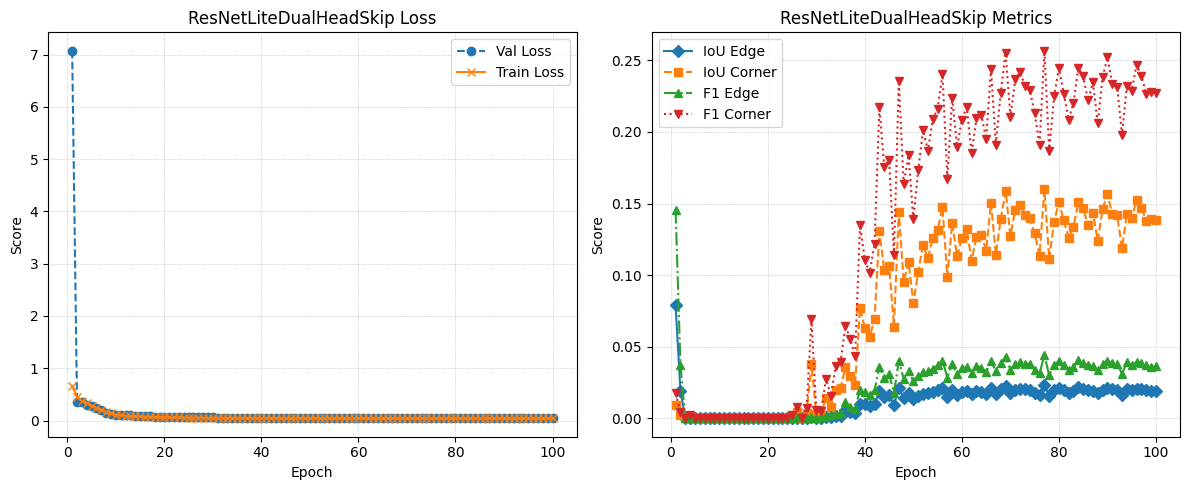

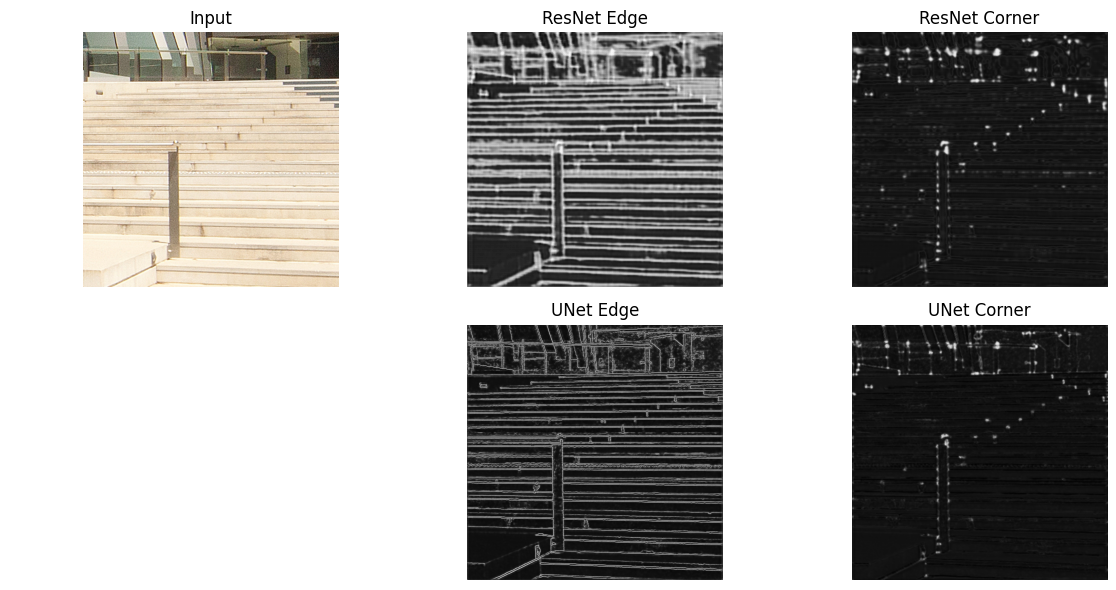

In [14]:
import torch
import torch.nn as nn
# from model import ResNetLiteDualHeadSkip, UNetDualHead
# from dataset import EdgeCornerDataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
# from train_utils import train_one_epoch, validate, plot_metrics, export_metrics_csv, compare_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4

dataset = EdgeCornerDataset(root_dir="/kaggle/input/jcsmr-data/data/filtered_crops/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model_1 = ResNetLiteDualHeadSkip().to(device)
model_2 = UNetDualHead().to(device)

loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.5)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=10, gamma=0.5)

resnet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}
unet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}

# ===================== TRAINING - RESNET =====================
best_val_loss = float("inf")
os.makedirs("/kaggle/working/models", exist_ok = True)
epochs = 100

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [ResNetLiteDualHeadSkip]")
    train_loss = train_one_epoch(model_1, train_loader, optimizer_1, device)
    val_metrics = validate(model_1, val_loader, device)
    scheduler_1.step()

    for key in resnet_history:
        resnet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    resnet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_1.state_dict(), "/kaggle/working/models/resnet_skip_best_focal_loss.pth")
        print("Saved new best ResNet model")

# ===================== TRAINING - UNET =====================
best_val_loss = float("inf")
epochs = 35

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [UNetDualHead]")
    train_loss = train_one_epoch(model_2, train_loader, optimizer_2, device)
    val_metrics = validate(model_2, val_loader, device)
    scheduler_2.step()

    for key in unet_history:
        unet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    unet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_2.state_dict(), "/kaggle/working/models/unet_dual_head_best_focal_loss.pth")
        print("Saved new best UNet model")

plot_metrics(resnet_history, "ResNetLiteDualHeadSkip")
export_metrics_csv(resnet_history, "ResNetLiteDualHeadSkip")

plot_metrics(unet_history, "UNetDualHead")
export_metrics_csv(unet_history, "UNetDualHead")

compare_predictions(model_1, model_2, val_loader, device)

## Binary Cross Entropy with AdamW

In [15]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
# from model import ResNetLiteDualHeadSkip, UNetDualHead

def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection + 1e-6
    return (intersection / union).item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return (2 * precision * recall / (precision + recall + 1e-6)).item()

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    iou_edge = iou_corner = f1_edge = f1_corner = 0.0
    count = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            for i in range(images.size(0)):
                pred, gt = outputs[i], labels[i]
                iou_edge += compute_iou(pred[0], gt[0])
                iou_corner += compute_iou(pred[1], gt[1])
                f1_edge += compute_f1(pred[0], gt[0])
                f1_corner += compute_f1(pred[1], gt[1])
                count += 1
    return {
        "val_loss": total_loss / len(dataloader),
        "iou_edge": iou_edge / count,
        "iou_corner": iou_corner / count,
        "f1_edge": f1_edge / count,
        "f1_corner": f1_corner / count,
    }

def plot_metrics(history, model_name):
    epochs = range(1, len(history["val_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["val_loss"], label="Val Loss", linestyle='--', marker='o')
    plt.plot(epochs, history["train_loss"], label="Train Loss", linestyle='-', marker='x')
    plt.title(f"{model_name} Loss")

    # --- Metrics Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["iou_edge"], label="IoU Edge", linestyle='-', marker='D')
    plt.plot(epochs, history["iou_corner"], label="IoU Corner", linestyle='--', marker='s')
    plt.plot(epochs, history["f1_edge"], label="F1 Edge", linestyle='-.', marker='^')
    plt.plot(epochs, history["f1_corner"], label="F1 Corner", linestyle=':', marker='v')
    plt.title(f"{model_name} Metrics")

    for ax in plt.gcf().axes:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle=':', linewidth=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.grid(True)
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    plt.savefig(f"/kaggle/working/plots/{model_name.lower()}_metrics_adamW_bce.png")
    plt.show()

def export_metrics_csv(history, model_name):
    os.makedirs("/kaggle/working/metrics", exist_ok = True)
    file_path = f"/kaggle/working/metrics/{model_name.lower()}_metrics_adamW_bce.csv"
    
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Val Loss", "IoU Edge", "IoU Corner", "F1 Edge", "F1 Corner"])
        for i in range(len(history["val_loss"])):
            writer.writerow([
                i+1,
                history["train_loss"][i], history["val_loss"][i],
                history["iou_edge"][i], history["iou_corner"][i],
                history["f1_edge"][i], history["f1_corner"][i]
            ])

def compare_predictions(model1, model2, dataloader, device):
    model1.eval(); model2.eval()
    imgs, labels = next(iter(dataloader))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        preds1 = model1(imgs)
        preds2 = model2(imgs)
        
    for i in range(1):
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        edge1 = preds1[i, 0].cpu().numpy()
        corner1 = preds1[i, 1].cpu().numpy()
        edge2 = preds2[i, 0].cpu().numpy()
        corner2 = preds2[i, 1].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        axes[0, 0].imshow(img)
        axes[0, 1].imshow(edge1, cmap='gray')
        axes[0, 2].imshow(corner1, cmap='gray')
        axes[1, 1].imshow(edge2, cmap='gray')
        axes[1, 2].imshow(corner2, cmap='gray')
        
        for ax in axes.flat: ax.axis("off")
        axes[0, 0].set_title("Input")
        axes[0, 1].set_title("ResNet Edge")
        axes[0, 2].set_title("ResNet Corner")
        axes[1, 1].set_title("UNet Edge")
        axes[1, 2].set_title("UNet Corner")
        
        plt.tight_layout()
        os.makedirs("/kaggle/working/predictions", exist_ok=True)
        plt.savefig(f"/kaggle/working/predictions/single_image_adamW_bce.png")
        plt.show()

In [16]:
import torch
import torch.nn as nn
# from model import ResNetLiteDualHeadSkip, UNetDualHead
# from dataset import EdgeCornerDataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
# from train_utils import train_one_epoch, validate, plot_metrics, export_metrics_csv, compare_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4

dataset = EdgeCornerDataset(root_dir="/kaggle/input/jcsmr-data/data/filtered_crops/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model_1 = ResNetLiteDualHeadSkip().to(device)
model_2 = UNetDualHead().to(device)

loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.AdamW(model_1.parameters(), lr=1e-3)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.5)
optimizer_2 = torch.optim.AdamW(model_2.parameters(), lr=1e-3)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=10, gamma=0.5)

resnet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}
unet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}

# ===================== TRAINING - RESNET =====================
best_val_loss = float("inf")
os.makedirs("/kaggle/working/models", exist_ok = True)
epochs = 100
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [ResNetLiteDualHeadSkip]")
    train_loss = train_one_epoch(model_1, train_loader, loss_fn, optimizer_1, device)
    val_metrics = validate(model_1, val_loader, loss_fn, device)
    scheduler_1.step()

    for key in resnet_history:
        resnet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    resnet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_1.state_dict(), "/kaggle/working/models/resnet_skip_best_adamW_bce.pth")
        print("Saved new best ResNet model")

# ===================== TRAINING - UNET =====================
best_val_loss = float("inf")
epochs = 35

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [UNetDualHead]")
    train_loss = train_one_epoch(model_2, train_loader, loss_fn, optimizer_2, device)
    val_metrics = validate(model_2, val_loader, loss_fn, device)
    scheduler_2.step()

    for key in unet_history:
        unet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    unet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_2.state_dict(), "/kaggle/working/models/unet_dual_head_best_adamW_bce.pth")
        print("Saved new best UNet model")

plot_metrics(resnet_history, "ResNetLiteDualHeadSkip")
export_metrics_csv(resnet_history, "ResNetLiteDualHeadSkip")

plot_metrics(unet_history, "UNetDualHead")
export_metrics_csv(unet_history, "UNetDualHead")

compare_predictions(model_1, model_2, val_loader, device)


Epoch 1/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.6183 | Val Loss: 0.6658 | IoU(E): 0.076 | F1(E): 0.141 | IoU(C): 0.003 | F1(C): 0.005
Saved new best ResNet model

Epoch 2/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.5255 | Val Loss: 0.5227 | IoU(E): 0.021 | F1(E): 0.039 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 3/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.4778 | Val Loss: 0.4573 | IoU(E): 0.055 | F1(E): 0.103 | IoU(C): 0.005 | F1(C): 0.010
Saved new best ResNet model

Epoch 4/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.4275 | Val Loss: 0.4005 | IoU(E): 0.001 | F1(E): 0.002 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 5/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.3854 | Val Loss: 0.3686 | IoU(E): 0.001 | F1(E): 0.002 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 6/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.30it/s]


Train Loss: 0.3492 | Val Loss: 0.3438 | IoU(E): 0.001 | F1(E): 0.002 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 7/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.3194 | Val Loss: 0.3437 | IoU(E): 0.022 | F1(E): 0.040 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 8/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.2911 | Val Loss: 0.2685 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 9/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.2645 | Val Loss: 0.2989 | IoU(E): 0.001 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000

Epoch 10/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.2400 | Val Loss: 0.2388 | IoU(E): 0.000 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 11/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.2236 | Val Loss: 0.2152 | IoU(E): 0.001 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 12/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.2144 | Val Loss: 0.2100 | IoU(E): 0.003 | F1(E): 0.007 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 13/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.2052 | Val Loss: 0.2062 | IoU(E): 0.001 | F1(E): 0.002 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 14/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1972 | Val Loss: 0.1840 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 15/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1910 | Val Loss: 0.1810 | IoU(E): 0.003 | F1(E): 0.005 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 16/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1828 | Val Loss: 0.1716 | IoU(E): 0.004 | F1(E): 0.007 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 17/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1762 | Val Loss: 0.1653 | IoU(E): 0.009 | F1(E): 0.018 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 18/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1699 | Val Loss: 0.1705 | IoU(E): 0.057 | F1(E): 0.104 | IoU(C): 0.000 | F1(C): 0.000

Epoch 19/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1641 | Val Loss: 0.1533 | IoU(E): 0.094 | F1(E): 0.164 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 20/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1574 | Val Loss: 0.1500 | IoU(E): 0.200 | F1(E): 0.311 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 21/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1518 | Val Loss: 0.1491 | IoU(E): 0.219 | F1(E): 0.332 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 22/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1494 | Val Loss: 0.1411 | IoU(E): 0.235 | F1(E): 0.353 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 23/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1454 | Val Loss: 0.1382 | IoU(E): 0.203 | F1(E): 0.315 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 24/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1399 | Val Loss: 0.1339 | IoU(E): 0.255 | F1(E): 0.376 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 25/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.23it/s]


Train Loss: 0.1375 | Val Loss: 0.1332 | IoU(E): 0.244 | F1(E): 0.362 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 26/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1336 | Val Loss: 0.1314 | IoU(E): 0.279 | F1(E): 0.405 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 27/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Train Loss: 0.1332 | Val Loss: 0.1278 | IoU(E): 0.271 | F1(E): 0.396 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 28/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.1309 | Val Loss: 0.1286 | IoU(E): 0.276 | F1(E): 0.403 | IoU(C): 0.000 | F1(C): 0.000

Epoch 29/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1271 | Val Loss: 0.1228 | IoU(E): 0.284 | F1(E): 0.414 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 30/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.26it/s]


Train Loss: 0.1250 | Val Loss: 0.1269 | IoU(E): 0.265 | F1(E): 0.392 | IoU(C): 0.000 | F1(C): 0.000

Epoch 31/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.30it/s]


Train Loss: 0.1236 | Val Loss: 0.1184 | IoU(E): 0.273 | F1(E): 0.400 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 32/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.1219 | Val Loss: 0.1212 | IoU(E): 0.305 | F1(E): 0.436 | IoU(C): 0.000 | F1(C): 0.000

Epoch 33/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.1205 | Val Loss: 0.1168 | IoU(E): 0.297 | F1(E): 0.429 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 34/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1194 | Val Loss: 0.1198 | IoU(E): 0.296 | F1(E): 0.427 | IoU(C): 0.000 | F1(C): 0.000

Epoch 35/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1198 | Val Loss: 0.1165 | IoU(E): 0.303 | F1(E): 0.435 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 36/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1181 | Val Loss: 0.1164 | IoU(E): 0.266 | F1(E): 0.393 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 37/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1184 | Val Loss: 0.1142 | IoU(E): 0.309 | F1(E): 0.443 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 38/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1164 | Val Loss: 0.1202 | IoU(E): 0.297 | F1(E): 0.428 | IoU(C): 0.000 | F1(C): 0.000

Epoch 39/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1151 | Val Loss: 0.1118 | IoU(E): 0.307 | F1(E): 0.441 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 40/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1133 | Val Loss: 0.1127 | IoU(E): 0.330 | F1(E): 0.468 | IoU(C): 0.000 | F1(C): 0.000

Epoch 41/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Train Loss: 0.1138 | Val Loss: 0.1165 | IoU(E): 0.317 | F1(E): 0.452 | IoU(C): 0.000 | F1(C): 0.000

Epoch 42/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Train Loss: 0.1116 | Val Loss: 0.1089 | IoU(E): 0.324 | F1(E): 0.460 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 43/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1113 | Val Loss: 0.1097 | IoU(E): 0.326 | F1(E): 0.463 | IoU(C): 0.000 | F1(C): 0.000

Epoch 44/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1133 | Val Loss: 0.1085 | IoU(E): 0.318 | F1(E): 0.452 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 45/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1114 | Val Loss: 0.1089 | IoU(E): 0.326 | F1(E): 0.462 | IoU(C): 0.000 | F1(C): 0.000

Epoch 46/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1100 | Val Loss: 0.1119 | IoU(E): 0.324 | F1(E): 0.460 | IoU(C): 0.000 | F1(C): 0.000

Epoch 47/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1108 | Val Loss: 0.1078 | IoU(E): 0.321 | F1(E): 0.457 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 48/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1094 | Val Loss: 0.1105 | IoU(E): 0.334 | F1(E): 0.472 | IoU(C): 0.000 | F1(C): 0.000

Epoch 49/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1085 | Val Loss: 0.1073 | IoU(E): 0.326 | F1(E): 0.463 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 50/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1082 | Val Loss: 0.1064 | IoU(E): 0.331 | F1(E): 0.468 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 51/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1078 | Val Loss: 0.1077 | IoU(E): 0.325 | F1(E): 0.461 | IoU(C): 0.000 | F1(C): 0.000

Epoch 52/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1078 | Val Loss: 0.1067 | IoU(E): 0.334 | F1(E): 0.472 | IoU(C): 0.000 | F1(C): 0.000

Epoch 53/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1080 | Val Loss: 0.1059 | IoU(E): 0.336 | F1(E): 0.474 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 54/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.1072 | Val Loss: 0.1073 | IoU(E): 0.336 | F1(E): 0.474 | IoU(C): 0.000 | F1(C): 0.000

Epoch 55/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.1072 | Val Loss: 0.1064 | IoU(E): 0.340 | F1(E): 0.479 | IoU(C): 0.000 | F1(C): 0.000

Epoch 56/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1065 | Val Loss: 0.1051 | IoU(E): 0.339 | F1(E): 0.478 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 57/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1062 | Val Loss: 0.1064 | IoU(E): 0.332 | F1(E): 0.469 | IoU(C): 0.000 | F1(C): 0.000

Epoch 58/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1063 | Val Loss: 0.1055 | IoU(E): 0.339 | F1(E): 0.478 | IoU(C): 0.000 | F1(C): 0.000

Epoch 59/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1060 | Val Loss: 0.1056 | IoU(E): 0.343 | F1(E): 0.482 | IoU(C): 0.000 | F1(C): 0.000

Epoch 60/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1052 | Val Loss: 0.1056 | IoU(E): 0.342 | F1(E): 0.482 | IoU(C): 0.000 | F1(C): 0.000

Epoch 61/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1054 | Val Loss: 0.1038 | IoU(E): 0.341 | F1(E): 0.481 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 62/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1057 | Val Loss: 0.1050 | IoU(E): 0.341 | F1(E): 0.480 | IoU(C): 0.000 | F1(C): 0.000

Epoch 63/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.31it/s]


Train Loss: 0.1055 | Val Loss: 0.1044 | IoU(E): 0.341 | F1(E): 0.481 | IoU(C): 0.000 | F1(C): 0.000

Epoch 64/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1060 | Val Loss: 0.1034 | IoU(E): 0.346 | F1(E): 0.486 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 65/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.1052 | Val Loss: 0.1043 | IoU(E): 0.339 | F1(E): 0.478 | IoU(C): 0.000 | F1(C): 0.000

Epoch 66/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1047 | Val Loss: 0.1051 | IoU(E): 0.339 | F1(E): 0.478 | IoU(C): 0.000 | F1(C): 0.000

Epoch 67/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1050 | Val Loss: 0.1047 | IoU(E): 0.339 | F1(E): 0.477 | IoU(C): 0.000 | F1(C): 0.000

Epoch 68/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.1051 | Val Loss: 0.1032 | IoU(E): 0.343 | F1(E): 0.483 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 69/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1049 | Val Loss: 0.1050 | IoU(E): 0.339 | F1(E): 0.478 | IoU(C): 0.000 | F1(C): 0.000

Epoch 70/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1046 | Val Loss: 0.1032 | IoU(E): 0.336 | F1(E): 0.474 | IoU(C): 0.000 | F1(C): 0.000

Epoch 71/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1043 | Val Loss: 0.1036 | IoU(E): 0.344 | F1(E): 0.483 | IoU(C): 0.000 | F1(C): 0.000

Epoch 72/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1046 | Val Loss: 0.1032 | IoU(E): 0.343 | F1(E): 0.483 | IoU(C): 0.000 | F1(C): 0.000

Epoch 73/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1050 | Val Loss: 0.1045 | IoU(E): 0.335 | F1(E): 0.473 | IoU(C): 0.000 | F1(C): 0.000

Epoch 74/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1044 | Val Loss: 0.1033 | IoU(E): 0.346 | F1(E): 0.486 | IoU(C): 0.000 | F1(C): 0.000

Epoch 75/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.30it/s]


Train Loss: 0.1053 | Val Loss: 0.1030 | IoU(E): 0.339 | F1(E): 0.478 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 76/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1041 | Val Loss: 0.1037 | IoU(E): 0.340 | F1(E): 0.478 | IoU(C): 0.000 | F1(C): 0.000

Epoch 77/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.1042 | Val Loss: 0.1037 | IoU(E): 0.337 | F1(E): 0.476 | IoU(C): 0.000 | F1(C): 0.000

Epoch 78/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1039 | Val Loss: 0.1046 | IoU(E): 0.341 | F1(E): 0.480 | IoU(C): 0.000 | F1(C): 0.000

Epoch 79/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1042 | Val Loss: 0.1044 | IoU(E): 0.344 | F1(E): 0.483 | IoU(C): 0.000 | F1(C): 0.000

Epoch 80/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1048 | Val Loss: 0.1021 | IoU(E): 0.350 | F1(E): 0.491 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 81/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1038 | Val Loss: 0.1047 | IoU(E): 0.341 | F1(E): 0.479 | IoU(C): 0.000 | F1(C): 0.000

Epoch 82/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1041 | Val Loss: 0.1029 | IoU(E): 0.342 | F1(E): 0.481 | IoU(C): 0.000 | F1(C): 0.000

Epoch 83/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1048 | Val Loss: 0.1018 | IoU(E): 0.341 | F1(E): 0.480 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 84/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Train Loss: 0.1044 | Val Loss: 0.1021 | IoU(E): 0.344 | F1(E): 0.483 | IoU(C): 0.000 | F1(C): 0.000

Epoch 85/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1041 | Val Loss: 0.1035 | IoU(E): 0.347 | F1(E): 0.487 | IoU(C): 0.000 | F1(C): 0.000

Epoch 86/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1034 | Val Loss: 0.1059 | IoU(E): 0.339 | F1(E): 0.477 | IoU(C): 0.000 | F1(C): 0.000

Epoch 87/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1043 | Val Loss: 0.1027 | IoU(E): 0.350 | F1(E): 0.491 | IoU(C): 0.000 | F1(C): 0.000

Epoch 88/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1039 | Val Loss: 0.1032 | IoU(E): 0.346 | F1(E): 0.487 | IoU(C): 0.000 | F1(C): 0.000

Epoch 89/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1042 | Val Loss: 0.1019 | IoU(E): 0.340 | F1(E): 0.479 | IoU(C): 0.000 | F1(C): 0.000

Epoch 90/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1039 | Val Loss: 0.1025 | IoU(E): 0.342 | F1(E): 0.481 | IoU(C): 0.000 | F1(C): 0.000

Epoch 91/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1041 | Val Loss: 0.1023 | IoU(E): 0.342 | F1(E): 0.480 | IoU(C): 0.000 | F1(C): 0.000

Epoch 92/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1037 | Val Loss: 0.1026 | IoU(E): 0.344 | F1(E): 0.483 | IoU(C): 0.000 | F1(C): 0.000

Epoch 93/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.1040 | Val Loss: 0.1018 | IoU(E): 0.347 | F1(E): 0.487 | IoU(C): 0.000 | F1(C): 0.000

Epoch 94/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1035 | Val Loss: 0.1032 | IoU(E): 0.340 | F1(E): 0.478 | IoU(C): 0.000 | F1(C): 0.000

Epoch 95/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1030 | Val Loss: 0.1030 | IoU(E): 0.345 | F1(E): 0.485 | IoU(C): 0.000 | F1(C): 0.000

Epoch 96/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.1039 | Val Loss: 0.1022 | IoU(E): 0.344 | F1(E): 0.484 | IoU(C): 0.000 | F1(C): 0.000

Epoch 97/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Train Loss: 0.1050 | Val Loss: 0.1029 | IoU(E): 0.346 | F1(E): 0.487 | IoU(C): 0.000 | F1(C): 0.000

Epoch 98/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Train Loss: 0.1031 | Val Loss: 0.1022 | IoU(E): 0.345 | F1(E): 0.485 | IoU(C): 0.000 | F1(C): 0.000

Epoch 99/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1038 | Val Loss: 0.1020 | IoU(E): 0.342 | F1(E): 0.481 | IoU(C): 0.000 | F1(C): 0.000

Epoch 100/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1036 | Val Loss: 0.1024 | IoU(E): 0.339 | F1(E): 0.478 | IoU(C): 0.000 | F1(C): 0.000

Epoch 1/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.4204 | Val Loss: 0.8992 | IoU(E): 0.011 | F1(E): 0.020 | IoU(C): 0.002 | F1(C): 0.005
Saved new best UNet model

Epoch 2/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.2554 | Val Loss: 0.2387 | IoU(E): 0.170 | F1(E): 0.277 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 3/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1824 | Val Loss: 0.1805 | IoU(E): 0.426 | F1(E): 0.585 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 4/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.1390 | Val Loss: 0.1318 | IoU(E): 0.556 | F1(E): 0.705 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 5/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.1117 | Val Loss: 0.1061 | IoU(E): 0.574 | F1(E): 0.722 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 6/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0949 | Val Loss: 0.0936 | IoU(E): 0.633 | F1(E): 0.768 | IoU(C): 0.001 | F1(C): 0.002
Saved new best UNet model

Epoch 7/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0826 | Val Loss: 0.0785 | IoU(E): 0.676 | F1(E): 0.803 | IoU(C): 0.004 | F1(C): 0.009
Saved new best UNet model

Epoch 8/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0745 | Val Loss: 0.0652 | IoU(E): 0.655 | F1(E): 0.786 | IoU(C): 0.020 | F1(C): 0.037
Saved new best UNet model

Epoch 9/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0706 | Val Loss: 0.0638 | IoU(E): 0.661 | F1(E): 0.789 | IoU(C): 0.004 | F1(C): 0.008
Saved new best UNet model

Epoch 10/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0662 | Val Loss: 0.0802 | IoU(E): 0.669 | F1(E): 0.799 | IoU(C): 0.032 | F1(C): 0.058

Epoch 11/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0598 | Val Loss: 0.0555 | IoU(E): 0.692 | F1(E): 0.814 | IoU(C): 0.007 | F1(C): 0.014
Saved new best UNet model

Epoch 12/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0618 | Val Loss: 0.0850 | IoU(E): 0.648 | F1(E): 0.783 | IoU(C): 0.005 | F1(C): 0.009

Epoch 13/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0591 | Val Loss: 0.0553 | IoU(E): 0.666 | F1(E): 0.794 | IoU(C): 0.060 | F1(C): 0.104
Saved new best UNet model

Epoch 14/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0554 | Val Loss: 0.0511 | IoU(E): 0.672 | F1(E): 0.800 | IoU(C): 0.042 | F1(C): 0.075
Saved new best UNet model

Epoch 15/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0538 | Val Loss: 0.0508 | IoU(E): 0.700 | F1(E): 0.819 | IoU(C): 0.056 | F1(C): 0.098
Saved new best UNet model

Epoch 16/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0526 | Val Loss: 0.0503 | IoU(E): 0.706 | F1(E): 0.823 | IoU(C): 0.079 | F1(C): 0.136
Saved new best UNet model

Epoch 17/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0522 | Val Loss: 0.0517 | IoU(E): 0.710 | F1(E): 0.827 | IoU(C): 0.154 | F1(C): 0.246

Epoch 18/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0506 | Val Loss: 0.0486 | IoU(E): 0.716 | F1(E): 0.831 | IoU(C): 0.216 | F1(C): 0.330
Saved new best UNet model

Epoch 19/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0486 | Val Loss: 0.0485 | IoU(E): 0.727 | F1(E): 0.839 | IoU(C): 0.215 | F1(C): 0.322
Saved new best UNet model

Epoch 20/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0462 | Val Loss: 0.0454 | IoU(E): 0.710 | F1(E): 0.826 | IoU(C): 0.162 | F1(C): 0.255
Saved new best UNet model

Epoch 21/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0470 | Val Loss: 0.0450 | IoU(E): 0.724 | F1(E): 0.837 | IoU(C): 0.171 | F1(C): 0.269
Saved new best UNet model

Epoch 22/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0464 | Val Loss: 0.0440 | IoU(E): 0.727 | F1(E): 0.839 | IoU(C): 0.194 | F1(C): 0.295
Saved new best UNet model

Epoch 23/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.11it/s]


Train Loss: 0.0442 | Val Loss: 0.0428 | IoU(E): 0.730 | F1(E): 0.841 | IoU(C): 0.260 | F1(C): 0.373
Saved new best UNet model

Epoch 24/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0440 | Val Loss: 0.0416 | IoU(E): 0.736 | F1(E): 0.845 | IoU(C): 0.303 | F1(C): 0.422
Saved new best UNet model

Epoch 25/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0425 | Val Loss: 0.0414 | IoU(E): 0.737 | F1(E): 0.845 | IoU(C): 0.249 | F1(C): 0.362
Saved new best UNet model

Epoch 26/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0441 | Val Loss: 0.0438 | IoU(E): 0.724 | F1(E): 0.836 | IoU(C): 0.189 | F1(C): 0.291

Epoch 27/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0434 | Val Loss: 0.0430 | IoU(E): 0.731 | F1(E): 0.842 | IoU(C): 0.136 | F1(C): 0.220

Epoch 28/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0430 | Val Loss: 0.0431 | IoU(E): 0.727 | F1(E): 0.838 | IoU(C): 0.121 | F1(C): 0.196

Epoch 29/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0438 | Val Loss: 0.0402 | IoU(E): 0.735 | F1(E): 0.845 | IoU(C): 0.220 | F1(C): 0.325
Saved new best UNet model

Epoch 30/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0408 | Val Loss: 0.0396 | IoU(E): 0.732 | F1(E): 0.841 | IoU(C): 0.281 | F1(C): 0.394
Saved new best UNet model

Epoch 31/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0397 | Val Loss: 0.0383 | IoU(E): 0.749 | F1(E): 0.853 | IoU(C): 0.314 | F1(C): 0.431
Saved new best UNet model

Epoch 32/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0406 | Val Loss: 0.0385 | IoU(E): 0.748 | F1(E): 0.853 | IoU(C): 0.310 | F1(C): 0.425

Epoch 33/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0396 | Val Loss: 0.0383 | IoU(E): 0.746 | F1(E): 0.851 | IoU(C): 0.310 | F1(C): 0.426
Saved new best UNet model

Epoch 34/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0385 | Val Loss: 0.0373 | IoU(E): 0.748 | F1(E): 0.853 | IoU(C): 0.319 | F1(C): 0.435
Saved new best UNet model

Epoch 35/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0387 | Val Loss: 0.0374 | IoU(E): 0.751 | F1(E): 0.855 | IoU(C): 0.319 | F1(C): 0.435


## Binary Cross Entropy with SGD with Momentum

In [17]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
# from model import ResNetLiteDualHeadSkip, UNetDualHead

def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection + 1e-6
    return (intersection / union).item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return (2 * precision * recall / (precision + recall + 1e-6)).item()

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    iou_edge = iou_corner = f1_edge = f1_corner = 0.0
    count = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            for i in range(images.size(0)):
                pred, gt = outputs[i], labels[i]
                iou_edge += compute_iou(pred[0], gt[0])
                iou_corner += compute_iou(pred[1], gt[1])
                f1_edge += compute_f1(pred[0], gt[0])
                f1_corner += compute_f1(pred[1], gt[1])
                count += 1
    return {
        "val_loss": total_loss / len(dataloader),
        "iou_edge": iou_edge / count,
        "iou_corner": iou_corner / count,
        "f1_edge": f1_edge / count,
        "f1_corner": f1_corner / count,
    }

def plot_metrics(history, model_name):
    epochs = range(1, len(history["val_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["val_loss"], label="Val Loss", linestyle='--', marker='o')
    plt.plot(epochs, history["train_loss"], label="Train Loss", linestyle='-', marker='x')
    plt.title(f"{model_name} Loss")

    # --- Metrics Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["iou_edge"], label="IoU Edge", linestyle='-', marker='D')
    plt.plot(epochs, history["iou_corner"], label="IoU Corner", linestyle='--', marker='s')
    plt.plot(epochs, history["f1_edge"], label="F1 Edge", linestyle='-.', marker='^')
    plt.plot(epochs, history["f1_corner"], label="F1 Corner", linestyle=':', marker='v')
    plt.title(f"{model_name} Metrics")

    for ax in plt.gcf().axes:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle=':', linewidth=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.grid(True)
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    plt.savefig(f"/kaggle/working/plots/{model_name.lower()}_metrics_sgdM_bce.png")
    plt.show()

def export_metrics_csv(history, model_name):
    os.makedirs("/kaggle/working/metrics", exist_ok = True)
    file_path = f"/kaggle/working/metrics/{model_name.lower()}_metrics_sgdM_bce.csv"
    
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Val Loss", "IoU Edge", "IoU Corner", "F1 Edge", "F1 Corner"])
        for i in range(len(history["val_loss"])):
            writer.writerow([
                i+1,
                history["train_loss"][i], history["val_loss"][i],
                history["iou_edge"][i], history["iou_corner"][i],
                history["f1_edge"][i], history["f1_corner"][i]
            ])

def compare_predictions(model1, model2, dataloader, device):
    model1.eval(); model2.eval()
    imgs, labels = next(iter(dataloader))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        preds1 = model1(imgs)
        preds2 = model2(imgs)
        
    for i in range(1):
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        edge1 = preds1[i, 0].cpu().numpy()
        corner1 = preds1[i, 1].cpu().numpy()
        edge2 = preds2[i, 0].cpu().numpy()
        corner2 = preds2[i, 1].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        axes[0, 0].imshow(img)
        axes[0, 1].imshow(edge1, cmap='gray')
        axes[0, 2].imshow(corner1, cmap='gray')
        axes[1, 1].imshow(edge2, cmap='gray')
        axes[1, 2].imshow(corner2, cmap='gray')
        
        for ax in axes.flat: ax.axis("off")
        axes[0, 0].set_title("Input")
        axes[0, 1].set_title("ResNet Edge")
        axes[0, 2].set_title("ResNet Corner")
        axes[1, 1].set_title("UNet Edge")
        axes[1, 2].set_title("UNet Corner")
        
        plt.tight_layout()
        os.makedirs("/kaggle/working/predictions", exist_ok=True)
        plt.savefig(f"/kaggle/working/predictions/single_image_sgdM_bce.png")
        plt.show()


Epoch 1/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.6321 | Val Loss: 0.5010 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 2/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.3801 | Val Loss: 0.3172 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 3/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.2549 | Val Loss: 0.2089 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 4/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.2018 | Val Loss: 0.1704 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 5/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1800 | Val Loss: 0.1534 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 6/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1691 | Val Loss: 0.1465 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 7/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1602 | Val Loss: 0.1336 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 8/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1544 | Val Loss: 0.1310 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 9/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1490 | Val Loss: 0.1236 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 10/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1442 | Val Loss: 0.1212 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 11/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1412 | Val Loss: 0.1188 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 12/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1398 | Val Loss: 0.1167 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 13/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1371 | Val Loss: 0.1223 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 14/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1353 | Val Loss: 0.1157 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 15/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1343 | Val Loss: 0.1121 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 16/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1325 | Val Loss: 0.1117 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 17/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1312 | Val Loss: 0.1119 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 18/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1306 | Val Loss: 0.1099 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 19/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1289 | Val Loss: 0.1078 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 20/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1273 | Val Loss: 0.1085 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 21/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1270 | Val Loss: 0.1064 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 22/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1272 | Val Loss: 0.1068 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 23/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1253 | Val Loss: 0.1143 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 24/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1262 | Val Loss: 0.1074 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 25/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1251 | Val Loss: 0.1051 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 26/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1246 | Val Loss: 0.1042 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 27/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1236 | Val Loss: 0.1091 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 28/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1237 | Val Loss: 0.1031 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 29/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1229 | Val Loss: 0.1033 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 30/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1233 | Val Loss: 0.1026 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 31/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1225 | Val Loss: 0.1020 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 32/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1226 | Val Loss: 0.1024 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 33/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1227 | Val Loss: 0.1033 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 34/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1214 | Val Loss: 0.1022 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 35/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.54it/s]


Train Loss: 0.1220 | Val Loss: 0.1028 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 36/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1229 | Val Loss: 0.1063 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 37/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1216 | Val Loss: 0.1016 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 38/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1214 | Val Loss: 0.1013 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 39/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1209 | Val Loss: 0.1015 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 40/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1207 | Val Loss: 0.1031 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 41/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.56it/s]


Train Loss: 0.1203 | Val Loss: 0.1012 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 42/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.1206 | Val Loss: 0.1008 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 43/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1209 | Val Loss: 0.1007 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 44/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1209 | Val Loss: 0.1006 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 45/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1201 | Val Loss: 0.1012 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 46/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1201 | Val Loss: 0.1006 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 47/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1208 | Val Loss: 0.1006 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 48/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1199 | Val Loss: 0.1004 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 49/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1201 | Val Loss: 0.1004 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 50/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1198 | Val Loss: 0.1008 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 51/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1199 | Val Loss: 0.1003 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 52/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1197 | Val Loss: 0.1003 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 53/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1202 | Val Loss: 0.1002 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 54/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1205 | Val Loss: 0.1003 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 55/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1205 | Val Loss: 0.1002 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 56/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.55it/s]


Train Loss: 0.1205 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 57/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1198 | Val Loss: 0.1004 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 58/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1204 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 59/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1199 | Val Loss: 0.0998 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 60/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1207 | Val Loss: 0.1002 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 61/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.1194 | Val Loss: 0.0996 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 62/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1195 | Val Loss: 0.0997 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 63/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1199 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 64/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1199 | Val Loss: 0.1005 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 65/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1199 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 66/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1193 | Val Loss: 0.1001 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 67/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1194 | Val Loss: 0.1003 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 68/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1191 | Val Loss: 0.1001 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 69/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.1192 | Val Loss: 0.0998 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 70/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1192 | Val Loss: 0.1000 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 71/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.54it/s]


Train Loss: 0.1197 | Val Loss: 0.1002 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 72/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1207 | Val Loss: 0.1000 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 73/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.1198 | Val Loss: 0.1007 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 74/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1193 | Val Loss: 0.1000 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 75/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.1192 | Val Loss: 0.1001 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 76/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1197 | Val Loss: 0.1003 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 77/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.54it/s]


Train Loss: 0.1200 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 78/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.1196 | Val Loss: 0.0998 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 79/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1190 | Val Loss: 0.1000 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 80/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1186 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 81/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1200 | Val Loss: 0.0996 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 82/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1198 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 83/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1199 | Val Loss: 0.1000 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 84/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1194 | Val Loss: 0.0997 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 85/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1192 | Val Loss: 0.0996 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 86/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1192 | Val Loss: 0.0997 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 87/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1204 | Val Loss: 0.1002 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 88/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1193 | Val Loss: 0.0996 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 89/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1193 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 90/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1198 | Val Loss: 0.1002 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 91/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1193 | Val Loss: 0.0997 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 92/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1195 | Val Loss: 0.0999 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 93/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1198 | Val Loss: 0.0994 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 94/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1191 | Val Loss: 0.0997 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 95/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1197 | Val Loss: 0.0995 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 96/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1191 | Val Loss: 0.0996 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 97/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.31it/s]


Train Loss: 0.1206 | Val Loss: 0.0994 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 98/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1191 | Val Loss: 0.0993 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 99/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1188 | Val Loss: 0.0995 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 100/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1185 | Val Loss: 0.1000 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 1/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.4262 | Val Loss: 0.3061 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 2/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.1450 | Val Loss: 0.1259 | IoU(E): 0.004 | F1(E): 0.008 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 3/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.1134 | Val Loss: 0.0927 | IoU(E): 0.221 | F1(E): 0.343 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 4/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0985 | Val Loss: 0.0948 | IoU(E): 0.414 | F1(E): 0.558 | IoU(C): 0.000 | F1(C): 0.000

Epoch 5/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0888 | Val Loss: 0.0742 | IoU(E): 0.386 | F1(E): 0.534 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 6/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0817 | Val Loss: 0.0718 | IoU(E): 0.549 | F1(E): 0.696 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 7/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0751 | Val Loss: 0.0652 | IoU(E): 0.575 | F1(E): 0.720 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 8/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0712 | Val Loss: 0.0648 | IoU(E): 0.600 | F1(E): 0.743 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 9/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0677 | Val Loss: 0.0554 | IoU(E): 0.607 | F1(E): 0.748 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 10/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0649 | Val Loss: 0.0687 | IoU(E): 0.635 | F1(E): 0.774 | IoU(C): 0.000 | F1(C): 0.000

Epoch 11/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0645 | Val Loss: 0.0525 | IoU(E): 0.627 | F1(E): 0.765 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 12/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0630 | Val Loss: 0.0510 | IoU(E): 0.648 | F1(E): 0.782 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 13/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0620 | Val Loss: 0.0509 | IoU(E): 0.606 | F1(E): 0.747 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 14/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0631 | Val Loss: 0.0502 | IoU(E): 0.632 | F1(E): 0.769 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 15/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0614 | Val Loss: 0.0519 | IoU(E): 0.659 | F1(E): 0.791 | IoU(C): 0.000 | F1(C): 0.000

Epoch 16/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0594 | Val Loss: 0.0482 | IoU(E): 0.639 | F1(E): 0.774 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 17/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0592 | Val Loss: 0.0482 | IoU(E): 0.633 | F1(E): 0.770 | IoU(C): 0.000 | F1(C): 0.000

Epoch 18/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0588 | Val Loss: 0.0569 | IoU(E): 0.662 | F1(E): 0.794 | IoU(C): 0.000 | F1(C): 0.000

Epoch 19/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0588 | Val Loss: 0.0478 | IoU(E): 0.626 | F1(E): 0.763 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 20/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0608 | Val Loss: 0.0463 | IoU(E): 0.659 | F1(E): 0.790 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 21/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0575 | Val Loss: 0.0461 | IoU(E): 0.660 | F1(E): 0.791 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 22/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0570 | Val Loss: 0.0502 | IoU(E): 0.679 | F1(E): 0.806 | IoU(C): 0.000 | F1(C): 0.000

Epoch 23/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0563 | Val Loss: 0.0471 | IoU(E): 0.683 | F1(E): 0.808 | IoU(C): 0.000 | F1(C): 0.000

Epoch 24/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0569 | Val Loss: 0.0471 | IoU(E): 0.683 | F1(E): 0.808 | IoU(C): 0.000 | F1(C): 0.000

Epoch 25/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0555 | Val Loss: 0.0449 | IoU(E): 0.676 | F1(E): 0.803 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 26/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0561 | Val Loss: 0.0454 | IoU(E): 0.648 | F1(E): 0.782 | IoU(C): 0.000 | F1(C): 0.000

Epoch 27/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0560 | Val Loss: 0.0448 | IoU(E): 0.669 | F1(E): 0.797 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 28/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0550 | Val Loss: 0.0445 | IoU(E): 0.666 | F1(E): 0.795 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 29/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0559 | Val Loss: 0.0455 | IoU(E): 0.688 | F1(E): 0.812 | IoU(C): 0.000 | F1(C): 0.000

Epoch 30/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0554 | Val Loss: 0.0467 | IoU(E): 0.690 | F1(E): 0.813 | IoU(C): 0.000 | F1(C): 0.000

Epoch 31/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0547 | Val Loss: 0.0440 | IoU(E): 0.684 | F1(E): 0.809 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 32/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0545 | Val Loss: 0.0440 | IoU(E): 0.669 | F1(E): 0.797 | IoU(C): 0.000 | F1(C): 0.000

Epoch 33/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0545 | Val Loss: 0.0445 | IoU(E): 0.686 | F1(E): 0.810 | IoU(C): 0.000 | F1(C): 0.000

Epoch 34/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0544 | Val Loss: 0.0451 | IoU(E): 0.692 | F1(E): 0.815 | IoU(C): 0.000 | F1(C): 0.000

Epoch 35/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0542 | Val Loss: 0.0456 | IoU(E): 0.692 | F1(E): 0.815 | IoU(C): 0.000 | F1(C): 0.000


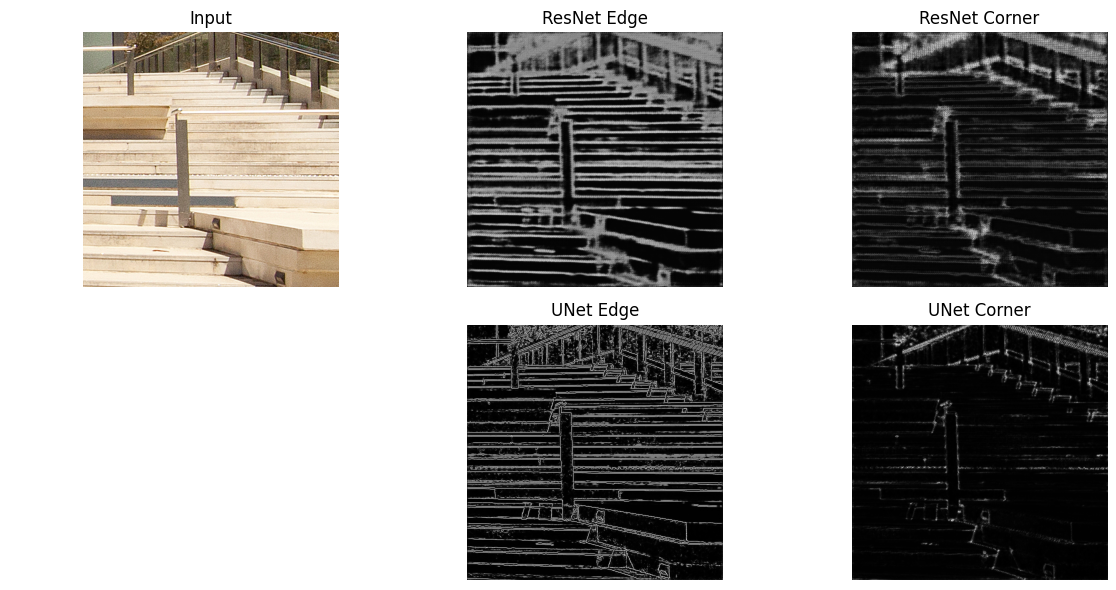

In [18]:
import torch
import torch.nn as nn
# from model import ResNetLiteDualHeadSkip, UNetDualHead
# from dataset import EdgeCornerDataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
# from train_utils import train_one_epoch, validate, plot_metrics, export_metrics_csv, compare_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4

dataset = EdgeCornerDataset(root_dir="/kaggle/input/jcsmr-data/data/filtered_crops/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model_1 = ResNetLiteDualHeadSkip().to(device)
model_2 = UNetDualHead().to(device)

loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.SGD(model_1.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.5)
optimizer_2 = torch.optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=10, gamma=0.5)

resnet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}
unet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}

# ===================== TRAINING - RESNET =====================
best_val_loss = float("inf")
os.makedirs("/kaggle/working/models", exist_ok = True)
epochs = 100
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [ResNetLiteDualHeadSkip]")
    train_loss = train_one_epoch(model_1, train_loader, loss_fn, optimizer_1, device)
    val_metrics = validate(model_1, val_loader, loss_fn, device)
    scheduler_1.step()

    for key in resnet_history:
        resnet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    resnet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_1.state_dict(), "/kaggle/working/models/resnet_skip_best_sgdM_bce.pth")
        print("Saved new best ResNet model")

# ===================== TRAINING - UNET =====================
best_val_loss = float("inf")
epochs = 35

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [UNetDualHead]")
    train_loss = train_one_epoch(model_2, train_loader, loss_fn, optimizer_2, device)
    val_metrics = validate(model_2, val_loader, loss_fn, device)
    scheduler_2.step()

    for key in unet_history:
        unet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    unet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_2.state_dict(), "/kaggle/working/models/unet_dual_head_best_sgdM_bce.pth")
        print("Saved new best UNet model")

plot_metrics(resnet_history, "ResNetLiteDualHeadSkip")
export_metrics_csv(resnet_history, "ResNetLiteDualHeadSkip")

plot_metrics(unet_history, "UNetDualHead")
export_metrics_csv(unet_history, "UNetDualHead")

compare_predictions(model_1, model_2, val_loader, device)

## Binary Cross Entropy with Adam with higher LR

In [19]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
# from model import ResNetLiteDualHeadSkip, UNetDualHead

def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection + 1e-6
    return (intersection / union).item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return (2 * precision * recall / (precision + recall + 1e-6)).item()

def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    iou_edge = iou_corner = f1_edge = f1_corner = 0.0
    count = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            for i in range(images.size(0)):
                pred, gt = outputs[i], labels[i]
                iou_edge += compute_iou(pred[0], gt[0])
                iou_corner += compute_iou(pred[1], gt[1])
                f1_edge += compute_f1(pred[0], gt[0])
                f1_corner += compute_f1(pred[1], gt[1])
                count += 1
    return {
        "val_loss": total_loss / len(dataloader),
        "iou_edge": iou_edge / count,
        "iou_corner": iou_corner / count,
        "f1_edge": f1_edge / count,
        "f1_corner": f1_corner / count,
    }

def plot_metrics(history, model_name):
    epochs = range(1, len(history["val_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["val_loss"], label="Val Loss", linestyle='--', marker='o')
    plt.plot(epochs, history["train_loss"], label="Train Loss", linestyle='-', marker='x')
    plt.title(f"{model_name} Loss")

    # --- Metrics Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["iou_edge"], label="IoU Edge", linestyle='-', marker='D')
    plt.plot(epochs, history["iou_corner"], label="IoU Corner", linestyle='--', marker='s')
    plt.plot(epochs, history["f1_edge"], label="F1 Edge", linestyle='-.', marker='^')
    plt.plot(epochs, history["f1_corner"], label="F1 Corner", linestyle=':', marker='v')
    plt.title(f"{model_name} Metrics")

    # --- Shared Plot Formatting ---
    for ax in plt.gcf().axes:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle=':', linewidth=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.grid(True)
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    plt.savefig(f"/kaggle/working/plots/{model_name.lower()}_metrics_adam_highLR_bce.png")
    plt.show()

def export_metrics_csv(history, model_name):
    os.makedirs("/kaggle/working/metrics", exist_ok = True)
    file_path = f"/kaggle/working/metrics/{model_name.lower()}_metrics_adam_highLR_bce.csv"
    
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Val Loss", "IoU Edge", "IoU Corner", "F1 Edge", "F1 Corner"])
        for i in range(len(history["val_loss"])):
            writer.writerow([
                i+1,
                history["train_loss"][i], history["val_loss"][i],
                history["iou_edge"][i], history["iou_corner"][i],
                history["f1_edge"][i], history["f1_corner"][i]
            ])

def compare_predictions(model1, model2, dataloader, device):
    model1.eval(); model2.eval()
    imgs, labels = next(iter(dataloader))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        preds1 = model1(imgs)
        preds2 = model2(imgs)
        
    for i in range(1):
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        edge1 = preds1[i, 0].cpu().numpy()
        corner1 = preds1[i, 1].cpu().numpy()
        edge2 = preds2[i, 0].cpu().numpy()
        corner2 = preds2[i, 1].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        axes[0, 0].imshow(img)
        axes[0, 1].imshow(edge1, cmap='gray')
        axes[0, 2].imshow(corner1, cmap='gray')
        axes[1, 1].imshow(edge2, cmap='gray')
        axes[1, 2].imshow(corner2, cmap='gray')
        
        for ax in axes.flat: ax.axis("off")
        axes[0, 0].set_title("Input")
        axes[0, 1].set_title("ResNet Edge")
        axes[0, 2].set_title("ResNet Corner")
        axes[1, 1].set_title("UNet Edge")
        axes[1, 2].set_title("UNet Corner")
        
        plt.tight_layout()
        os.makedirs("/kaggle/working/predictions", exist_ok=True)
        plt.savefig(f"/kaggle/working/predictions/single_image_adam_highLR_bce.png")
        plt.show()


Epoch 1/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.57it/s]


Train Loss: 0.5672 | Val Loss: 0.4447 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 2/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.54it/s]


Train Loss: 0.2334 | Val Loss: 0.2072 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 3/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.56it/s]


Train Loss: 0.1745 | Val Loss: 0.1830 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 4/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.1591 | Val Loss: 0.1738 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 5/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.1501 | Val Loss: 0.1869 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 6/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1486 | Val Loss: 0.1985 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 7/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1415 | Val Loss: 0.1648 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 8/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1356 | Val Loss: 0.2216 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 9/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1291 | Val Loss: 0.1957 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 10/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1264 | Val Loss: 0.1521 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 11/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1225 | Val Loss: 0.1469 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 12/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1254 | Val Loss: 0.1464 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 13/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1206 | Val Loss: 0.1313 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 14/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.1157 | Val Loss: 0.1296 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 15/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1152 | Val Loss: 0.1330 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 16/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1145 | Val Loss: 0.1254 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 17/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1119 | Val Loss: 0.1246 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 18/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1097 | Val Loss: 0.1230 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 19/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1112 | Val Loss: 0.1269 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 20/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.54it/s]


Train Loss: 0.1121 | Val Loss: 0.1698 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000

Epoch 21/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1113 | Val Loss: 0.1158 | IoU(E): 0.030 | F1(E): 0.056 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 22/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1070 | Val Loss: 0.1129 | IoU(E): 0.016 | F1(E): 0.032 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 23/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1063 | Val Loss: 0.1109 | IoU(E): 0.036 | F1(E): 0.066 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 24/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1063 | Val Loss: 0.1149 | IoU(E): 0.056 | F1(E): 0.101 | IoU(C): 0.000 | F1(C): 0.000

Epoch 25/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1067 | Val Loss: 0.1131 | IoU(E): 0.064 | F1(E): 0.111 | IoU(C): 0.000 | F1(C): 0.000

Epoch 26/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1060 | Val Loss: 0.1110 | IoU(E): 0.049 | F1(E): 0.088 | IoU(C): 0.000 | F1(C): 0.000

Epoch 27/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1050 | Val Loss: 0.1091 | IoU(E): 0.045 | F1(E): 0.082 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 28/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.1036 | Val Loss: 0.1089 | IoU(E): 0.086 | F1(E): 0.145 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 29/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1039 | Val Loss: 0.1099 | IoU(E): 0.102 | F1(E): 0.168 | IoU(C): 0.000 | F1(C): 0.000

Epoch 30/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1025 | Val Loss: 0.1085 | IoU(E): 0.113 | F1(E): 0.182 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 31/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1019 | Val Loss: 0.1057 | IoU(E): 0.123 | F1(E): 0.198 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 32/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1006 | Val Loss: 0.1043 | IoU(E): 0.143 | F1(E): 0.225 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 33/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1001 | Val Loss: 0.1050 | IoU(E): 0.153 | F1(E): 0.236 | IoU(C): 0.000 | F1(C): 0.000

Epoch 34/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.0994 | Val Loss: 0.1045 | IoU(E): 0.155 | F1(E): 0.243 | IoU(C): 0.000 | F1(C): 0.000

Epoch 35/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.0981 | Val Loss: 0.1013 | IoU(E): 0.177 | F1(E): 0.269 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 36/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.0974 | Val Loss: 0.1002 | IoU(E): 0.178 | F1(E): 0.270 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 37/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.0975 | Val Loss: 0.1011 | IoU(E): 0.193 | F1(E): 0.292 | IoU(C): 0.000 | F1(C): 0.000

Epoch 38/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.0957 | Val Loss: 0.0997 | IoU(E): 0.200 | F1(E): 0.296 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 39/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.0955 | Val Loss: 0.1051 | IoU(E): 0.200 | F1(E): 0.300 | IoU(C): 0.000 | F1(C): 0.000

Epoch 40/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.0961 | Val Loss: 0.0974 | IoU(E): 0.214 | F1(E): 0.316 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 41/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.0934 | Val Loss: 0.0968 | IoU(E): 0.224 | F1(E): 0.327 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 42/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.0925 | Val Loss: 0.0964 | IoU(E): 0.210 | F1(E): 0.312 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 43/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.0920 | Val Loss: 0.0948 | IoU(E): 0.222 | F1(E): 0.325 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 44/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.0936 | Val Loss: 0.0942 | IoU(E): 0.222 | F1(E): 0.326 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 45/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.0908 | Val Loss: 0.0944 | IoU(E): 0.234 | F1(E): 0.340 | IoU(C): 0.000 | F1(C): 0.000

Epoch 46/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.0932 | Val Loss: 0.0952 | IoU(E): 0.227 | F1(E): 0.333 | IoU(C): 0.000 | F1(C): 0.000

Epoch 47/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.0911 | Val Loss: 0.0942 | IoU(E): 0.221 | F1(E): 0.328 | IoU(C): 0.000 | F1(C): 0.000

Epoch 48/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.0899 | Val Loss: 0.0932 | IoU(E): 0.233 | F1(E): 0.339 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 49/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.0897 | Val Loss: 0.0923 | IoU(E): 0.240 | F1(E): 0.347 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 50/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.0902 | Val Loss: 0.0930 | IoU(E): 0.248 | F1(E): 0.357 | IoU(C): 0.000 | F1(C): 0.000

Epoch 51/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0894 | Val Loss: 0.0915 | IoU(E): 0.239 | F1(E): 0.346 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 52/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.0889 | Val Loss: 0.0938 | IoU(E): 0.246 | F1(E): 0.355 | IoU(C): 0.000 | F1(C): 0.000

Epoch 53/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.0875 | Val Loss: 0.0912 | IoU(E): 0.241 | F1(E): 0.349 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 54/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.0896 | Val Loss: 0.0924 | IoU(E): 0.248 | F1(E): 0.357 | IoU(C): 0.000 | F1(C): 0.000

Epoch 55/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.0881 | Val Loss: 0.0909 | IoU(E): 0.249 | F1(E): 0.359 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 56/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.0892 | Val Loss: 0.0906 | IoU(E): 0.243 | F1(E): 0.350 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 57/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.0886 | Val Loss: 0.0912 | IoU(E): 0.243 | F1(E): 0.353 | IoU(C): 0.000 | F1(C): 0.000

Epoch 58/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.0877 | Val Loss: 0.0912 | IoU(E): 0.236 | F1(E): 0.346 | IoU(C): 0.000 | F1(C): 0.000

Epoch 59/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.0889 | Val Loss: 0.0913 | IoU(E): 0.252 | F1(E): 0.361 | IoU(C): 0.000 | F1(C): 0.000

Epoch 60/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.0881 | Val Loss: 0.0900 | IoU(E): 0.249 | F1(E): 0.359 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 61/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.0869 | Val Loss: 0.0899 | IoU(E): 0.251 | F1(E): 0.361 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 62/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.0867 | Val Loss: 0.0898 | IoU(E): 0.251 | F1(E): 0.361 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 63/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.0868 | Val Loss: 0.0900 | IoU(E): 0.255 | F1(E): 0.366 | IoU(C): 0.000 | F1(C): 0.000

Epoch 64/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.0865 | Val Loss: 0.0894 | IoU(E): 0.256 | F1(E): 0.368 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 65/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.0864 | Val Loss: 0.0894 | IoU(E): 0.256 | F1(E): 0.367 | IoU(C): 0.000 | F1(C): 0.000

Epoch 66/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.0859 | Val Loss: 0.0894 | IoU(E): 0.253 | F1(E): 0.363 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 67/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.0873 | Val Loss: 0.0896 | IoU(E): 0.252 | F1(E): 0.361 | IoU(C): 0.000 | F1(C): 0.000

Epoch 68/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.0858 | Val Loss: 0.0890 | IoU(E): 0.258 | F1(E): 0.369 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 69/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.0869 | Val Loss: 0.0890 | IoU(E): 0.258 | F1(E): 0.369 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 70/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.0863 | Val Loss: 0.0895 | IoU(E): 0.265 | F1(E): 0.378 | IoU(C): 0.000 | F1(C): 0.000

Epoch 71/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.0858 | Val Loss: 0.0889 | IoU(E): 0.252 | F1(E): 0.363 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 72/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.0856 | Val Loss: 0.0894 | IoU(E): 0.262 | F1(E): 0.374 | IoU(C): 0.000 | F1(C): 0.000

Epoch 73/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.0855 | Val Loss: 0.0886 | IoU(E): 0.261 | F1(E): 0.373 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 74/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.0874 | Val Loss: 0.0888 | IoU(E): 0.257 | F1(E): 0.368 | IoU(C): 0.000 | F1(C): 0.000

Epoch 75/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.0851 | Val Loss: 0.0888 | IoU(E): 0.262 | F1(E): 0.375 | IoU(C): 0.000 | F1(C): 0.000

Epoch 76/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.0859 | Val Loss: 0.0886 | IoU(E): 0.255 | F1(E): 0.366 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 77/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.0848 | Val Loss: 0.0887 | IoU(E): 0.258 | F1(E): 0.369 | IoU(C): 0.000 | F1(C): 0.000

Epoch 78/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.0857 | Val Loss: 0.0885 | IoU(E): 0.258 | F1(E): 0.369 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 79/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.0857 | Val Loss: 0.0884 | IoU(E): 0.260 | F1(E): 0.372 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 80/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.0846 | Val Loss: 0.0886 | IoU(E): 0.257 | F1(E): 0.368 | IoU(C): 0.000 | F1(C): 0.000

Epoch 81/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.0852 | Val Loss: 0.0885 | IoU(E): 0.259 | F1(E): 0.371 | IoU(C): 0.000 | F1(C): 0.000

Epoch 82/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.0865 | Val Loss: 0.0886 | IoU(E): 0.257 | F1(E): 0.369 | IoU(C): 0.000 | F1(C): 0.000

Epoch 83/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.0856 | Val Loss: 0.0883 | IoU(E): 0.258 | F1(E): 0.369 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 84/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.0847 | Val Loss: 0.0886 | IoU(E): 0.260 | F1(E): 0.371 | IoU(C): 0.000 | F1(C): 0.000

Epoch 85/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.0854 | Val Loss: 0.0883 | IoU(E): 0.261 | F1(E): 0.373 | IoU(C): 0.000 | F1(C): 0.000

Epoch 86/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.0855 | Val Loss: 0.0883 | IoU(E): 0.261 | F1(E): 0.373 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 87/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.0847 | Val Loss: 0.0883 | IoU(E): 0.263 | F1(E): 0.376 | IoU(C): 0.000 | F1(C): 0.000

Epoch 88/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.0856 | Val Loss: 0.0882 | IoU(E): 0.260 | F1(E): 0.373 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 89/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.0869 | Val Loss: 0.0883 | IoU(E): 0.263 | F1(E): 0.375 | IoU(C): 0.000 | F1(C): 0.000

Epoch 90/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.0846 | Val Loss: 0.0882 | IoU(E): 0.261 | F1(E): 0.373 | IoU(C): 0.000 | F1(C): 0.000

Epoch 91/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.0863 | Val Loss: 0.0883 | IoU(E): 0.258 | F1(E): 0.370 | IoU(C): 0.000 | F1(C): 0.000

Epoch 92/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.0858 | Val Loss: 0.0884 | IoU(E): 0.258 | F1(E): 0.370 | IoU(C): 0.000 | F1(C): 0.000

Epoch 93/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.0857 | Val Loss: 0.0884 | IoU(E): 0.259 | F1(E): 0.370 | IoU(C): 0.000 | F1(C): 0.000

Epoch 94/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0850 | Val Loss: 0.0882 | IoU(E): 0.260 | F1(E): 0.371 | IoU(C): 0.000 | F1(C): 0.000

Epoch 95/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.0857 | Val Loss: 0.0885 | IoU(E): 0.256 | F1(E): 0.367 | IoU(C): 0.000 | F1(C): 0.000

Epoch 96/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.0851 | Val Loss: 0.0881 | IoU(E): 0.261 | F1(E): 0.372 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 97/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.0848 | Val Loss: 0.0881 | IoU(E): 0.264 | F1(E): 0.377 | IoU(C): 0.000 | F1(C): 0.000

Epoch 98/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.0855 | Val Loss: 0.0882 | IoU(E): 0.264 | F1(E): 0.377 | IoU(C): 0.000 | F1(C): 0.000

Epoch 99/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.0851 | Val Loss: 0.0882 | IoU(E): 0.259 | F1(E): 0.371 | IoU(C): 0.000 | F1(C): 0.000

Epoch 100/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.0864 | Val Loss: 0.0881 | IoU(E): 0.261 | F1(E): 0.373 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 1/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2343 | Val Loss: 0.5343 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 2/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1240 | Val Loss: 0.3388 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 3/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train Loss: 0.1139 | Val Loss: 0.2072 | IoU(E): 0.000 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 4/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.1057 | Val Loss: 0.2044 | IoU(E): 0.221 | F1(E): 0.337 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 5/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0919 | Val Loss: 0.2003 | IoU(E): 0.364 | F1(E): 0.504 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 6/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train Loss: 0.0784 | Val Loss: 0.1606 | IoU(E): 0.368 | F1(E): 0.514 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 7/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train Loss: 0.0779 | Val Loss: 0.1500 | IoU(E): 0.414 | F1(E): 0.576 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 8/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0692 | Val Loss: 0.0954 | IoU(E): 0.422 | F1(E): 0.589 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 9/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0683 | Val Loss: 0.0734 | IoU(E): 0.499 | F1(E): 0.654 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 10/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0585 | Val Loss: 0.0619 | IoU(E): 0.589 | F1(E): 0.734 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 11/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0553 | Val Loss: 0.0591 | IoU(E): 0.612 | F1(E): 0.752 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 12/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0542 | Val Loss: 0.0643 | IoU(E): 0.577 | F1(E): 0.722 | IoU(C): 0.000 | F1(C): 0.000

Epoch 13/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0549 | Val Loss: 0.0861 | IoU(E): 0.582 | F1(E): 0.731 | IoU(C): 0.000 | F1(C): 0.000

Epoch 14/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0516 | Val Loss: 0.1066 | IoU(E): 0.547 | F1(E): 0.705 | IoU(C): 0.000 | F1(C): 0.000

Epoch 15/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train Loss: 0.0502 | Val Loss: 0.0827 | IoU(E): 0.519 | F1(E): 0.676 | IoU(C): 0.000 | F1(C): 0.000

Epoch 16/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train Loss: 0.0502 | Val Loss: 0.1508 | IoU(E): 0.426 | F1(E): 0.581 | IoU(C): 0.000 | F1(C): 0.000

Epoch 17/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0501 | Val Loss: 0.0526 | IoU(E): 0.662 | F1(E): 0.792 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 18/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0470 | Val Loss: 0.0569 | IoU(E): 0.612 | F1(E): 0.754 | IoU(C): 0.000 | F1(C): 0.000

Epoch 19/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0456 | Val Loss: 0.1176 | IoU(E): 0.584 | F1(E): 0.736 | IoU(C): 0.000 | F1(C): 0.000

Epoch 20/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train Loss: 0.0452 | Val Loss: 0.0477 | IoU(E): 0.699 | F1(E): 0.819 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 21/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0435 | Val Loss: 0.0458 | IoU(E): 0.681 | F1(E): 0.807 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 22/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0424 | Val Loss: 0.0449 | IoU(E): 0.692 | F1(E): 0.814 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 23/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train Loss: 0.0443 | Val Loss: 0.0645 | IoU(E): 0.599 | F1(E): 0.744 | IoU(C): 0.000 | F1(C): 0.000

Epoch 24/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0434 | Val Loss: 0.0473 | IoU(E): 0.666 | F1(E): 0.795 | IoU(C): 0.000 | F1(C): 0.000

Epoch 25/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0410 | Val Loss: 0.0507 | IoU(E): 0.639 | F1(E): 0.776 | IoU(C): 0.001 | F1(C): 0.002

Epoch 26/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0404 | Val Loss: 0.0427 | IoU(E): 0.714 | F1(E): 0.830 | IoU(C): 0.001 | F1(C): 0.003
Saved new best UNet model

Epoch 27/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0423 | Val Loss: 0.0431 | IoU(E): 0.699 | F1(E): 0.819 | IoU(C): 0.003 | F1(C): 0.006

Epoch 28/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0387 | Val Loss: 0.0418 | IoU(E): 0.713 | F1(E): 0.829 | IoU(C): 0.013 | F1(C): 0.026
Saved new best UNet model

Epoch 29/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0390 | Val Loss: 0.0408 | IoU(E): 0.722 | F1(E): 0.835 | IoU(C): 0.033 | F1(C): 0.064
Saved new best UNet model

Epoch 30/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0387 | Val Loss: 0.0421 | IoU(E): 0.717 | F1(E): 0.832 | IoU(C): 0.072 | F1(C): 0.129

Epoch 31/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0380 | Val Loss: 0.0450 | IoU(E): 0.715 | F1(E): 0.831 | IoU(C): 0.066 | F1(C): 0.120

Epoch 32/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0379 | Val Loss: 0.0397 | IoU(E): 0.723 | F1(E): 0.836 | IoU(C): 0.062 | F1(C): 0.113
Saved new best UNet model

Epoch 33/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.0373 | Val Loss: 0.0401 | IoU(E): 0.727 | F1(E): 0.839 | IoU(C): 0.064 | F1(C): 0.116

Epoch 34/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.0375 | Val Loss: 0.0402 | IoU(E): 0.732 | F1(E): 0.842 | IoU(C): 0.121 | F1(C): 0.206

Epoch 35/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.12it/s]


Train Loss: 0.0379 | Val Loss: 0.0402 | IoU(E): 0.717 | F1(E): 0.832 | IoU(C): 0.097 | F1(C): 0.168


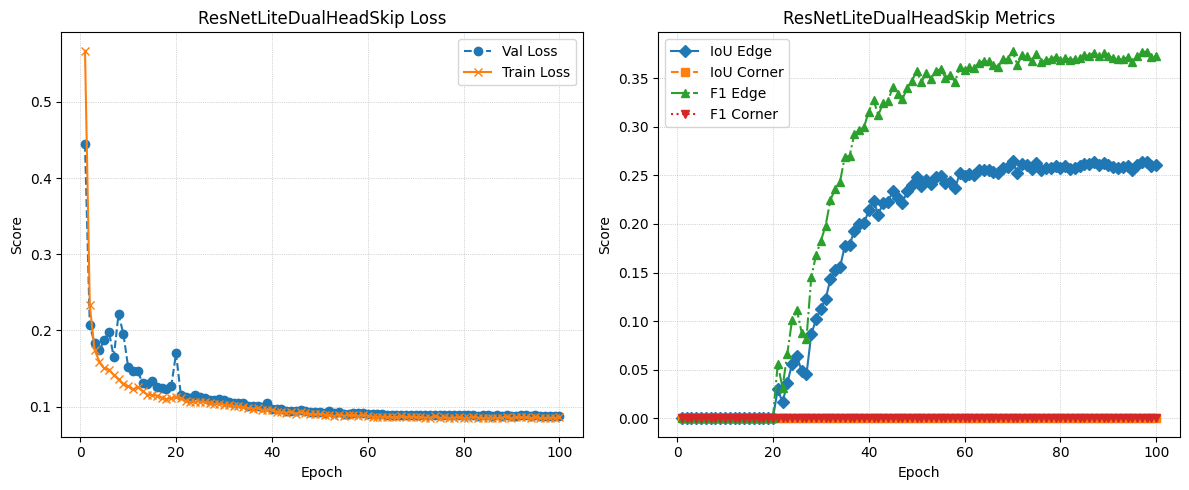

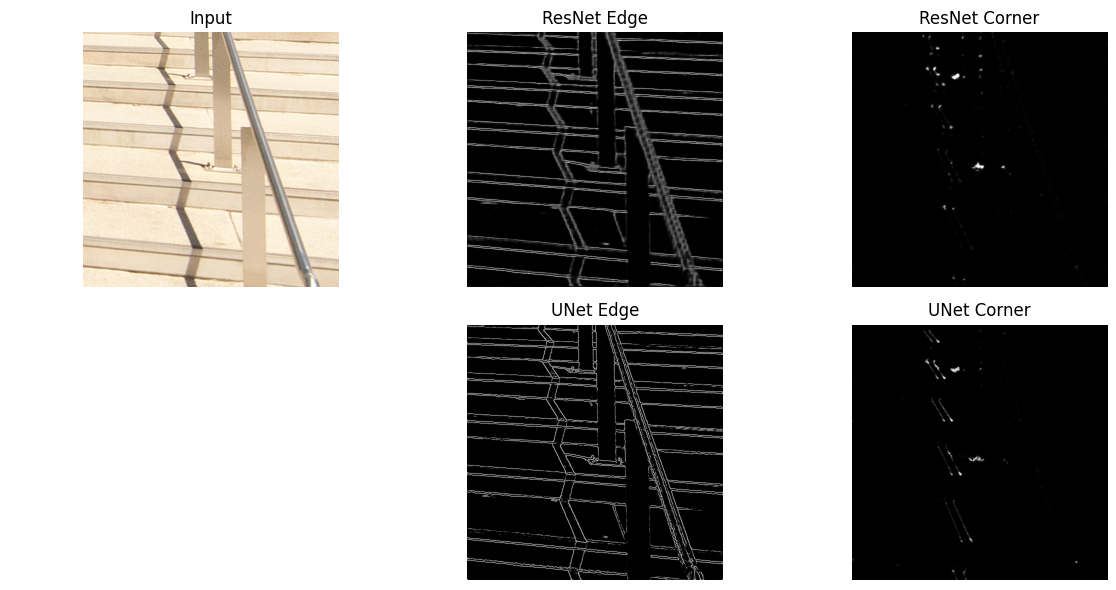

In [20]:
import torch
import torch.nn as nn
# from model import ResNetLiteDualHeadSkip, UNetDualHead
# from dataset import EdgeCornerDataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
# from train_utils import train_one_epoch, validate, plot_metrics, export_metrics_csv, compare_predictions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4

dataset = EdgeCornerDataset(root_dir="/kaggle/input/jcsmr-data/data/filtered_crops/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

model_1 = ResNetLiteDualHeadSkip().to(device)
model_2 = UNetDualHead().to(device)

loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-2)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.5)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-2)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=10, gamma=0.5)

resnet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}
unet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}

# ===================== TRAINING - RESNET =====================
best_val_loss = float("inf")
os.makedirs("/kaggle/working/models", exist_ok = True)
epochs = 100
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [ResNetLiteDualHeadSkip]")
    train_loss = train_one_epoch(model_1, train_loader, loss_fn, optimizer_1, device)
    val_metrics = validate(model_1, val_loader, loss_fn, device)
    scheduler_1.step()

    for key in resnet_history:
        resnet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    resnet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_1.state_dict(), "/kaggle/working/models/resnet_skip_best_adam_highLR_bce.pth")
        print("Saved new best ResNet model")

# ===================== TRAINING - UNET =====================
best_val_loss = float("inf")
epochs = 35

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [UNetDualHead]")
    train_loss = train_one_epoch(model_2, train_loader, loss_fn, optimizer_2, device)
    val_metrics = validate(model_2, val_loader, loss_fn, device)
    scheduler_2.step()

    for key in unet_history:
        unet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    unet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_2.state_dict(), "/kaggle/working/models/unet_dual_head_best_adam_highLR_bce.pth")
        print("Saved new best UNet model")

plot_metrics(resnet_history, "ResNetLiteDualHeadSkip")
export_metrics_csv(resnet_history, "ResNetLiteDualHeadSkip")

plot_metrics(unet_history, "UNetDualHead")
export_metrics_csv(unet_history, "UNetDualHead")

compare_predictions(model_1, model_2, val_loader, device)

## Binary Cross Entropy with Adam with lower LR

In [21]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
# from model import ResNetLiteDualHeadSkip, UNetDualHead

# ===================== Metrics =====================
def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection + 1e-6
    return (intersection / union).item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return (2 * precision * recall / (precision + recall + 1e-6)).item()

# ===================== Loops =====================
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    iou_edge = iou_corner = f1_edge = f1_corner = 0.0
    count = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            for i in range(images.size(0)):
                pred, gt = outputs[i], labels[i]
                iou_edge += compute_iou(pred[0], gt[0])
                iou_corner += compute_iou(pred[1], gt[1])
                f1_edge += compute_f1(pred[0], gt[0])
                f1_corner += compute_f1(pred[1], gt[1])
                count += 1
    return {
        "val_loss": total_loss / len(dataloader),
        "iou_edge": iou_edge / count,
        "iou_corner": iou_corner / count,
        "f1_edge": f1_edge / count,
        "f1_corner": f1_corner / count,
    }

# ===================== Metrics Plot + CSV =====================
def plot_metrics(history, model_name):
    epochs = range(1, len(history["val_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["val_loss"], label="Val Loss", linestyle='--', marker='o')
    plt.plot(epochs, history["train_loss"], label="Train Loss", linestyle='-', marker='x')
    plt.title(f"{model_name} Loss")

    # --- Metrics Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["iou_edge"], label="IoU Edge", linestyle='-', marker='D')
    plt.plot(epochs, history["iou_corner"], label="IoU Corner", linestyle='--', marker='s')
    plt.plot(epochs, history["f1_edge"], label="F1 Edge", linestyle='-.', marker='^')
    plt.plot(epochs, history["f1_corner"], label="F1 Corner", linestyle=':', marker='v')
    plt.title(f"{model_name} Metrics")

    # --- Shared Plot Formatting ---
    for ax in plt.gcf().axes:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle=':', linewidth=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.grid(True)
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    plt.savefig(f"/kaggle/working/plots/{model_name.lower()}_metrics_adam_lowerLR_bce.png")
    plt.show()

def export_metrics_csv(history, model_name):
    os.makedirs("/kaggle/working/metrics", exist_ok = True)
    file_path = f"/kaggle/working/metrics/{model_name.lower()}_metrics_adam_lowerLR_bce.csv"
    
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Val Loss", "IoU Edge", "IoU Corner", "F1 Edge", "F1 Corner"])
        for i in range(len(history["val_loss"])):
            writer.writerow([
                i+1,
                history["train_loss"][i], history["val_loss"][i],
                history["iou_edge"][i], history["iou_corner"][i],
                history["f1_edge"][i], history["f1_corner"][i]
            ])

# ===================== Prediction Comparison =====================
def compare_predictions(model1, model2, dataloader, device):
    model1.eval(); model2.eval()
    imgs, labels = next(iter(dataloader))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        preds1 = model1(imgs)
        preds2 = model2(imgs)
        
    for i in range(1):
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        edge1 = preds1[i, 0].cpu().numpy()
        corner1 = preds1[i, 1].cpu().numpy()
        edge2 = preds2[i, 0].cpu().numpy()
        corner2 = preds2[i, 1].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        axes[0, 0].imshow(img)
        axes[0, 1].imshow(edge1, cmap='gray')
        axes[0, 2].imshow(corner1, cmap='gray')
        axes[1, 1].imshow(edge2, cmap='gray')
        axes[1, 2].imshow(corner2, cmap='gray')
        
        for ax in axes.flat: ax.axis("off")
        axes[0, 0].set_title("Input")
        axes[0, 1].set_title("ResNet Edge")
        axes[0, 2].set_title("ResNet Corner")
        axes[1, 1].set_title("UNet Edge")
        axes[1, 2].set_title("UNet Corner")
        
        plt.tight_layout()
        os.makedirs("/kaggle/working/predictions", exist_ok=True)
        plt.savefig(f"/kaggle/working/predictions/single_image_adam_lowerLR_bce.png")
        plt.show()


Epoch 1/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.31it/s]


Train Loss: 0.5956 | Val Loss: 0.5736 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 2/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.5635 | Val Loss: 0.5399 | IoU(E): 0.016 | F1(E): 0.030 | IoU(C): 0.003 | F1(C): 0.006
Saved new best ResNet model

Epoch 3/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.5391 | Val Loss: 0.5342 | IoU(E): 0.119 | F1(E): 0.201 | IoU(C): 0.032 | F1(C): 0.060
Saved new best ResNet model

Epoch 4/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.5181 | Val Loss: 0.5493 | IoU(E): 0.076 | F1(E): 0.129 | IoU(C): 0.022 | F1(C): 0.040

Epoch 5/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.5033 | Val Loss: 0.5061 | IoU(E): 0.047 | F1(E): 0.084 | IoU(C): 0.003 | F1(C): 0.006
Saved new best ResNet model

Epoch 6/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.01it/s]


Train Loss: 0.4907 | Val Loss: 0.5931 | IoU(E): 0.073 | F1(E): 0.128 | IoU(C): 0.020 | F1(C): 0.039

Epoch 7/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.4807 | Val Loss: 0.5074 | IoU(E): 0.075 | F1(E): 0.131 | IoU(C): 0.025 | F1(C): 0.048

Epoch 8/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.4718 | Val Loss: 0.4874 | IoU(E): 0.096 | F1(E): 0.170 | IoU(C): 0.017 | F1(C): 0.032
Saved new best ResNet model

Epoch 9/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4657 | Val Loss: 0.4604 | IoU(E): 0.048 | F1(E): 0.090 | IoU(C): 0.006 | F1(C): 0.011
Saved new best ResNet model

Epoch 10/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4585 | Val Loss: 0.4881 | IoU(E): 0.140 | F1(E): 0.240 | IoU(C): 0.020 | F1(C): 0.037

Epoch 11/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.4546 | Val Loss: 0.4557 | IoU(E): 0.066 | F1(E): 0.123 | IoU(C): 0.008 | F1(C): 0.014
Saved new best ResNet model

Epoch 12/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.4505 | Val Loss: 0.4542 | IoU(E): 0.081 | F1(E): 0.148 | IoU(C): 0.010 | F1(C): 0.019
Saved new best ResNet model

Epoch 13/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4477 | Val Loss: 0.4633 | IoU(E): 0.104 | F1(E): 0.184 | IoU(C): 0.018 | F1(C): 0.033

Epoch 14/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.4451 | Val Loss: 0.4536 | IoU(E): 0.086 | F1(E): 0.156 | IoU(C): 0.016 | F1(C): 0.029
Saved new best ResNet model

Epoch 15/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.4418 | Val Loss: 0.4477 | IoU(E): 0.097 | F1(E): 0.174 | IoU(C): 0.012 | F1(C): 0.022
Saved new best ResNet model

Epoch 16/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.4393 | Val Loss: 0.4469 | IoU(E): 0.102 | F1(E): 0.183 | IoU(C): 0.006 | F1(C): 0.011
Saved new best ResNet model

Epoch 17/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.4367 | Val Loss: 0.4648 | IoU(E): 0.117 | F1(E): 0.207 | IoU(C): 0.017 | F1(C): 0.032

Epoch 18/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4350 | Val Loss: 0.4402 | IoU(E): 0.116 | F1(E): 0.207 | IoU(C): 0.018 | F1(C): 0.034
Saved new best ResNet model

Epoch 19/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.4323 | Val Loss: 0.4347 | IoU(E): 0.109 | F1(E): 0.195 | IoU(C): 0.002 | F1(C): 0.003
Saved new best ResNet model

Epoch 20/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.4289 | Val Loss: 0.4310 | IoU(E): 0.106 | F1(E): 0.190 | IoU(C): 0.003 | F1(C): 0.005
Saved new best ResNet model

Epoch 21/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4273 | Val Loss: 0.4339 | IoU(E): 0.115 | F1(E): 0.204 | IoU(C): 0.014 | F1(C): 0.026

Epoch 22/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.4256 | Val Loss: 0.4319 | IoU(E): 0.126 | F1(E): 0.223 | IoU(C): 0.006 | F1(C): 0.011

Epoch 23/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4245 | Val Loss: 0.4321 | IoU(E): 0.136 | F1(E): 0.237 | IoU(C): 0.008 | F1(C): 0.015

Epoch 24/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.4232 | Val Loss: 0.4313 | IoU(E): 0.132 | F1(E): 0.232 | IoU(C): 0.009 | F1(C): 0.018

Epoch 25/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.4218 | Val Loss: 0.4292 | IoU(E): 0.133 | F1(E): 0.233 | IoU(C): 0.008 | F1(C): 0.015
Saved new best ResNet model

Epoch 26/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.4207 | Val Loss: 0.4282 | IoU(E): 0.136 | F1(E): 0.238 | IoU(C): 0.007 | F1(C): 0.014
Saved new best ResNet model

Epoch 27/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4193 | Val Loss: 0.4265 | IoU(E): 0.134 | F1(E): 0.234 | IoU(C): 0.008 | F1(C): 0.015
Saved new best ResNet model

Epoch 28/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.47it/s]


Train Loss: 0.4181 | Val Loss: 0.4228 | IoU(E): 0.128 | F1(E): 0.226 | IoU(C): 0.007 | F1(C): 0.013
Saved new best ResNet model

Epoch 29/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.4168 | Val Loss: 0.4262 | IoU(E): 0.144 | F1(E): 0.251 | IoU(C): 0.009 | F1(C): 0.017

Epoch 30/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4158 | Val Loss: 0.4218 | IoU(E): 0.139 | F1(E): 0.242 | IoU(C): 0.003 | F1(C): 0.006
Saved new best ResNet model

Epoch 31/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.4147 | Val Loss: 0.4182 | IoU(E): 0.126 | F1(E): 0.223 | IoU(C): 0.003 | F1(C): 0.005
Saved new best ResNet model

Epoch 32/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4139 | Val Loss: 0.4206 | IoU(E): 0.138 | F1(E): 0.241 | IoU(C): 0.004 | F1(C): 0.009

Epoch 33/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4135 | Val Loss: 0.4201 | IoU(E): 0.136 | F1(E): 0.238 | IoU(C): 0.007 | F1(C): 0.013

Epoch 34/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4130 | Val Loss: 0.4173 | IoU(E): 0.133 | F1(E): 0.234 | IoU(C): 0.003 | F1(C): 0.005
Saved new best ResNet model

Epoch 35/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.4124 | Val Loss: 0.4180 | IoU(E): 0.132 | F1(E): 0.232 | IoU(C): 0.010 | F1(C): 0.019

Epoch 36/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.4118 | Val Loss: 0.4184 | IoU(E): 0.138 | F1(E): 0.241 | IoU(C): 0.007 | F1(C): 0.014

Epoch 37/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.4111 | Val Loss: 0.4184 | IoU(E): 0.141 | F1(E): 0.246 | IoU(C): 0.005 | F1(C): 0.010

Epoch 38/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4105 | Val Loss: 0.4172 | IoU(E): 0.140 | F1(E): 0.244 | IoU(C): 0.006 | F1(C): 0.011
Saved new best ResNet model

Epoch 39/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4101 | Val Loss: 0.4169 | IoU(E): 0.141 | F1(E): 0.245 | IoU(C): 0.005 | F1(C): 0.009
Saved new best ResNet model

Epoch 40/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.4093 | Val Loss: 0.4160 | IoU(E): 0.141 | F1(E): 0.246 | IoU(C): 0.006 | F1(C): 0.012
Saved new best ResNet model

Epoch 41/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4090 | Val Loss: 0.4174 | IoU(E): 0.147 | F1(E): 0.255 | IoU(C): 0.007 | F1(C): 0.014

Epoch 42/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4085 | Val Loss: 0.4149 | IoU(E): 0.139 | F1(E): 0.243 | IoU(C): 0.005 | F1(C): 0.010
Saved new best ResNet model

Epoch 43/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Train Loss: 0.4083 | Val Loss: 0.4123 | IoU(E): 0.131 | F1(E): 0.230 | IoU(C): 0.003 | F1(C): 0.007
Saved new best ResNet model

Epoch 44/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4080 | Val Loss: 0.4171 | IoU(E): 0.141 | F1(E): 0.246 | IoU(C): 0.011 | F1(C): 0.020

Epoch 45/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.4079 | Val Loss: 0.4182 | IoU(E): 0.150 | F1(E): 0.260 | IoU(C): 0.009 | F1(C): 0.017

Epoch 46/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4076 | Val Loss: 0.4142 | IoU(E): 0.142 | F1(E): 0.246 | IoU(C): 0.004 | F1(C): 0.009

Epoch 47/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.4072 | Val Loss: 0.4108 | IoU(E): 0.130 | F1(E): 0.229 | IoU(C): 0.002 | F1(C): 0.003
Saved new best ResNet model

Epoch 48/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.4068 | Val Loss: 0.4131 | IoU(E): 0.141 | F1(E): 0.245 | IoU(C): 0.004 | F1(C): 0.008

Epoch 49/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.4065 | Val Loss: 0.4131 | IoU(E): 0.140 | F1(E): 0.245 | IoU(C): 0.006 | F1(C): 0.011

Epoch 50/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.4062 | Val Loss: 0.4122 | IoU(E): 0.138 | F1(E): 0.241 | IoU(C): 0.003 | F1(C): 0.005

Epoch 51/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.4060 | Val Loss: 0.4150 | IoU(E): 0.144 | F1(E): 0.250 | IoU(C): 0.008 | F1(C): 0.016

Epoch 52/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4056 | Val Loss: 0.4124 | IoU(E): 0.138 | F1(E): 0.241 | IoU(C): 0.004 | F1(C): 0.007

Epoch 53/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4056 | Val Loss: 0.4112 | IoU(E): 0.139 | F1(E): 0.243 | IoU(C): 0.002 | F1(C): 0.003

Epoch 54/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4054 | Val Loss: 0.4103 | IoU(E): 0.136 | F1(E): 0.239 | IoU(C): 0.002 | F1(C): 0.004
Saved new best ResNet model

Epoch 55/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4055 | Val Loss: 0.4125 | IoU(E): 0.142 | F1(E): 0.248 | IoU(C): 0.007 | F1(C): 0.014

Epoch 56/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4052 | Val Loss: 0.4118 | IoU(E): 0.139 | F1(E): 0.243 | IoU(C): 0.005 | F1(C): 0.009

Epoch 57/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.4050 | Val Loss: 0.4116 | IoU(E): 0.140 | F1(E): 0.244 | IoU(C): 0.004 | F1(C): 0.009

Epoch 58/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.4049 | Val Loss: 0.4122 | IoU(E): 0.143 | F1(E): 0.248 | IoU(C): 0.006 | F1(C): 0.011

Epoch 59/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4049 | Val Loss: 0.4128 | IoU(E): 0.142 | F1(E): 0.247 | IoU(C): 0.008 | F1(C): 0.015

Epoch 60/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4045 | Val Loss: 0.4113 | IoU(E): 0.142 | F1(E): 0.248 | IoU(C): 0.002 | F1(C): 0.004

Epoch 61/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4046 | Val Loss: 0.4120 | IoU(E): 0.146 | F1(E): 0.253 | IoU(C): 0.004 | F1(C): 0.008

Epoch 62/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.4046 | Val Loss: 0.4102 | IoU(E): 0.140 | F1(E): 0.245 | IoU(C): 0.002 | F1(C): 0.004
Saved new best ResNet model

Epoch 63/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.4045 | Val Loss: 0.4096 | IoU(E): 0.135 | F1(E): 0.237 | IoU(C): 0.002 | F1(C): 0.004
Saved new best ResNet model

Epoch 64/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.4044 | Val Loss: 0.4101 | IoU(E): 0.140 | F1(E): 0.244 | IoU(C): 0.003 | F1(C): 0.006

Epoch 65/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.4044 | Val Loss: 0.4102 | IoU(E): 0.140 | F1(E): 0.243 | IoU(C): 0.002 | F1(C): 0.004

Epoch 66/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.4042 | Val Loss: 0.4110 | IoU(E): 0.143 | F1(E): 0.249 | IoU(C): 0.005 | F1(C): 0.010

Epoch 67/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4042 | Val Loss: 0.4117 | IoU(E): 0.146 | F1(E): 0.253 | IoU(C): 0.004 | F1(C): 0.008

Epoch 68/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4038 | Val Loss: 0.4105 | IoU(E): 0.143 | F1(E): 0.249 | IoU(C): 0.003 | F1(C): 0.006

Epoch 69/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4040 | Val Loss: 0.4112 | IoU(E): 0.145 | F1(E): 0.251 | IoU(C): 0.004 | F1(C): 0.007

Epoch 70/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.4038 | Val Loss: 0.4122 | IoU(E): 0.146 | F1(E): 0.253 | IoU(C): 0.006 | F1(C): 0.011

Epoch 71/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4037 | Val Loss: 0.4105 | IoU(E): 0.143 | F1(E): 0.249 | IoU(C): 0.002 | F1(C): 0.005

Epoch 72/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.4037 | Val Loss: 0.4124 | IoU(E): 0.145 | F1(E): 0.251 | IoU(C): 0.006 | F1(C): 0.012

Epoch 73/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4037 | Val Loss: 0.4105 | IoU(E): 0.141 | F1(E): 0.246 | IoU(C): 0.004 | F1(C): 0.007

Epoch 74/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.4036 | Val Loss: 0.4108 | IoU(E): 0.142 | F1(E): 0.248 | IoU(C): 0.006 | F1(C): 0.012

Epoch 75/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4035 | Val Loss: 0.4104 | IoU(E): 0.140 | F1(E): 0.244 | IoU(C): 0.005 | F1(C): 0.009

Epoch 76/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.4036 | Val Loss: 0.4108 | IoU(E): 0.140 | F1(E): 0.244 | IoU(C): 0.007 | F1(C): 0.013

Epoch 77/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.4035 | Val Loss: 0.4106 | IoU(E): 0.143 | F1(E): 0.249 | IoU(C): 0.005 | F1(C): 0.010

Epoch 78/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4035 | Val Loss: 0.4101 | IoU(E): 0.142 | F1(E): 0.248 | IoU(C): 0.002 | F1(C): 0.004

Epoch 79/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4035 | Val Loss: 0.4107 | IoU(E): 0.143 | F1(E): 0.249 | IoU(C): 0.003 | F1(C): 0.006

Epoch 80/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.4036 | Val Loss: 0.4092 | IoU(E): 0.139 | F1(E): 0.243 | IoU(C): 0.002 | F1(C): 0.004
Saved new best ResNet model

Epoch 81/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4034 | Val Loss: 0.4114 | IoU(E): 0.145 | F1(E): 0.251 | IoU(C): 0.006 | F1(C): 0.012

Epoch 82/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.4034 | Val Loss: 0.4112 | IoU(E): 0.143 | F1(E): 0.249 | IoU(C): 0.005 | F1(C): 0.011

Epoch 83/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.14it/s]


Train Loss: 0.4035 | Val Loss: 0.4088 | IoU(E): 0.138 | F1(E): 0.241 | IoU(C): 0.002 | F1(C): 0.005
Saved new best ResNet model

Epoch 84/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4033 | Val Loss: 0.4101 | IoU(E): 0.142 | F1(E): 0.248 | IoU(C): 0.005 | F1(C): 0.009

Epoch 85/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.4032 | Val Loss: 0.4106 | IoU(E): 0.143 | F1(E): 0.249 | IoU(C): 0.006 | F1(C): 0.012

Epoch 86/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.40it/s]


Train Loss: 0.4035 | Val Loss: 0.4105 | IoU(E): 0.144 | F1(E): 0.250 | IoU(C): 0.005 | F1(C): 0.009

Epoch 87/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4033 | Val Loss: 0.4083 | IoU(E): 0.137 | F1(E): 0.239 | IoU(C): 0.002 | F1(C): 0.003
Saved new best ResNet model

Epoch 88/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.4033 | Val Loss: 0.4087 | IoU(E): 0.138 | F1(E): 0.241 | IoU(C): 0.003 | F1(C): 0.007

Epoch 89/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4034 | Val Loss: 0.4146 | IoU(E): 0.146 | F1(E): 0.254 | IoU(C): 0.011 | F1(C): 0.021

Epoch 90/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.4030 | Val Loss: 0.4114 | IoU(E): 0.145 | F1(E): 0.251 | IoU(C): 0.006 | F1(C): 0.012

Epoch 91/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.52it/s]


Train Loss: 0.4032 | Val Loss: 0.4102 | IoU(E): 0.141 | F1(E): 0.245 | IoU(C): 0.004 | F1(C): 0.009

Epoch 92/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.45it/s]


Train Loss: 0.4033 | Val Loss: 0.4103 | IoU(E): 0.138 | F1(E): 0.242 | IoU(C): 0.005 | F1(C): 0.010

Epoch 93/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.4031 | Val Loss: 0.4105 | IoU(E): 0.140 | F1(E): 0.245 | IoU(C): 0.004 | F1(C): 0.007

Epoch 94/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.4032 | Val Loss: 0.4093 | IoU(E): 0.141 | F1(E): 0.245 | IoU(C): 0.004 | F1(C): 0.008

Epoch 95/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.4034 | Val Loss: 0.4103 | IoU(E): 0.141 | F1(E): 0.246 | IoU(C): 0.006 | F1(C): 0.012

Epoch 96/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.4031 | Val Loss: 0.4092 | IoU(E): 0.141 | F1(E): 0.246 | IoU(C): 0.002 | F1(C): 0.005

Epoch 97/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4033 | Val Loss: 0.4091 | IoU(E): 0.138 | F1(E): 0.242 | IoU(C): 0.003 | F1(C): 0.006

Epoch 98/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.4031 | Val Loss: 0.4119 | IoU(E): 0.147 | F1(E): 0.254 | IoU(C): 0.007 | F1(C): 0.013

Epoch 99/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.4034 | Val Loss: 0.4109 | IoU(E): 0.145 | F1(E): 0.253 | IoU(C): 0.005 | F1(C): 0.010

Epoch 100/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.4031 | Val Loss: 0.4111 | IoU(E): 0.143 | F1(E): 0.249 | IoU(C): 0.006 | F1(C): 0.012

Epoch 1/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.6893 | Val Loss: 0.6653 | IoU(E): 0.007 | F1(E): 0.013 | IoU(C): 0.009 | F1(C): 0.017
Saved new best UNet model

Epoch 2/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.5678 | Val Loss: 0.5368 | IoU(E): 0.135 | F1(E): 0.233 | IoU(C): 0.016 | F1(C): 0.031
Saved new best UNet model

Epoch 3/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.5186 | Val Loss: 0.5313 | IoU(E): 0.299 | F1(E): 0.450 | IoU(C): 0.042 | F1(C): 0.076
Saved new best UNet model

Epoch 4/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.4899 | Val Loss: 0.4854 | IoU(E): 0.348 | F1(E): 0.503 | IoU(C): 0.008 | F1(C): 0.016
Saved new best UNet model

Epoch 5/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.4674 | Val Loss: 0.4796 | IoU(E): 0.387 | F1(E): 0.545 | IoU(C): 0.014 | F1(C): 0.027
Saved new best UNet model

Epoch 6/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.4508 | Val Loss: 0.4820 | IoU(E): 0.388 | F1(E): 0.544 | IoU(C): 0.057 | F1(C): 0.104

Epoch 7/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.4350 | Val Loss: 0.4286 | IoU(E): 0.427 | F1(E): 0.587 | IoU(C): 0.010 | F1(C): 0.020
Saved new best UNet model

Epoch 8/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.4191 | Val Loss: 0.4083 | IoU(E): 0.461 | F1(E): 0.622 | IoU(C): 0.013 | F1(C): 0.025
Saved new best UNet model

Epoch 9/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.4025 | Val Loss: 0.3988 | IoU(E): 0.471 | F1(E): 0.631 | IoU(C): 0.010 | F1(C): 0.020
Saved new best UNet model

Epoch 10/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3877 | Val Loss: 0.3881 | IoU(E): 0.493 | F1(E): 0.652 | IoU(C): 0.012 | F1(C): 0.022
Saved new best UNet model

Epoch 11/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3780 | Val Loss: 0.3911 | IoU(E): 0.498 | F1(E): 0.655 | IoU(C): 0.018 | F1(C): 0.034

Epoch 12/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3728 | Val Loss: 0.3746 | IoU(E): 0.528 | F1(E): 0.686 | IoU(C): 0.012 | F1(C): 0.023
Saved new best UNet model

Epoch 13/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3677 | Val Loss: 0.3640 | IoU(E): 0.518 | F1(E): 0.675 | IoU(C): 0.025 | F1(C): 0.047
Saved new best UNet model

Epoch 14/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3596 | Val Loss: 0.3673 | IoU(E): 0.514 | F1(E): 0.671 | IoU(C): 0.030 | F1(C): 0.056

Epoch 15/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3547 | Val Loss: 0.3475 | IoU(E): 0.533 | F1(E): 0.688 | IoU(C): 0.008 | F1(C): 0.015
Saved new best UNet model

Epoch 16/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3472 | Val Loss: 0.3496 | IoU(E): 0.553 | F1(E): 0.707 | IoU(C): 0.012 | F1(C): 0.023

Epoch 17/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3418 | Val Loss: 0.3462 | IoU(E): 0.563 | F1(E): 0.717 | IoU(C): 0.013 | F1(C): 0.025
Saved new best UNet model

Epoch 18/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3371 | Val Loss: 0.3374 | IoU(E): 0.552 | F1(E): 0.705 | IoU(C): 0.010 | F1(C): 0.020
Saved new best UNet model

Epoch 19/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3292 | Val Loss: 0.3280 | IoU(E): 0.562 | F1(E): 0.714 | IoU(C): 0.012 | F1(C): 0.024
Saved new best UNet model

Epoch 20/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3232 | Val Loss: 0.3221 | IoU(E): 0.580 | F1(E): 0.730 | IoU(C): 0.003 | F1(C): 0.005
Saved new best UNet model

Epoch 21/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3199 | Val Loss: 0.3192 | IoU(E): 0.586 | F1(E): 0.734 | IoU(C): 0.010 | F1(C): 0.020
Saved new best UNet model

Epoch 22/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3179 | Val Loss: 0.3145 | IoU(E): 0.575 | F1(E): 0.725 | IoU(C): 0.010 | F1(C): 0.019
Saved new best UNet model

Epoch 23/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3162 | Val Loss: 0.3132 | IoU(E): 0.575 | F1(E): 0.725 | IoU(C): 0.009 | F1(C): 0.017
Saved new best UNet model

Epoch 24/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3112 | Val Loss: 0.3107 | IoU(E): 0.578 | F1(E): 0.728 | IoU(C): 0.011 | F1(C): 0.020
Saved new best UNet model

Epoch 25/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3097 | Val Loss: 0.3070 | IoU(E): 0.586 | F1(E): 0.734 | IoU(C): 0.010 | F1(C): 0.019
Saved new best UNet model

Epoch 26/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3082 | Val Loss: 0.3032 | IoU(E): 0.580 | F1(E): 0.728 | IoU(C): 0.010 | F1(C): 0.020
Saved new best UNet model

Epoch 27/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3046 | Val Loss: 0.3012 | IoU(E): 0.600 | F1(E): 0.745 | IoU(C): 0.009 | F1(C): 0.017
Saved new best UNet model

Epoch 28/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.3031 | Val Loss: 0.3041 | IoU(E): 0.594 | F1(E): 0.741 | IoU(C): 0.022 | F1(C): 0.041

Epoch 29/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.3008 | Val Loss: 0.2994 | IoU(E): 0.603 | F1(E): 0.748 | IoU(C): 0.009 | F1(C): 0.017
Saved new best UNet model

Epoch 30/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2972 | Val Loss: 0.2958 | IoU(E): 0.599 | F1(E): 0.745 | IoU(C): 0.007 | F1(C): 0.014
Saved new best UNet model

Epoch 31/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2945 | Val Loss: 0.2947 | IoU(E): 0.611 | F1(E): 0.754 | IoU(C): 0.011 | F1(C): 0.020
Saved new best UNet model

Epoch 32/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2934 | Val Loss: 0.2918 | IoU(E): 0.603 | F1(E): 0.748 | IoU(C): 0.011 | F1(C): 0.020
Saved new best UNet model

Epoch 33/35 [UNetDualHead]


100%|██████████| 21/21 [00:18<00:00,  1.11it/s]


Train Loss: 0.2925 | Val Loss: 0.2905 | IoU(E): 0.603 | F1(E): 0.748 | IoU(C): 0.011 | F1(C): 0.020
Saved new best UNet model

Epoch 34/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2915 | Val Loss: 0.2898 | IoU(E): 0.599 | F1(E): 0.745 | IoU(C): 0.010 | F1(C): 0.018
Saved new best UNet model

Epoch 35/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.10it/s]


Train Loss: 0.2901 | Val Loss: 0.2880 | IoU(E): 0.606 | F1(E): 0.750 | IoU(C): 0.010 | F1(C): 0.019
Saved new best UNet model


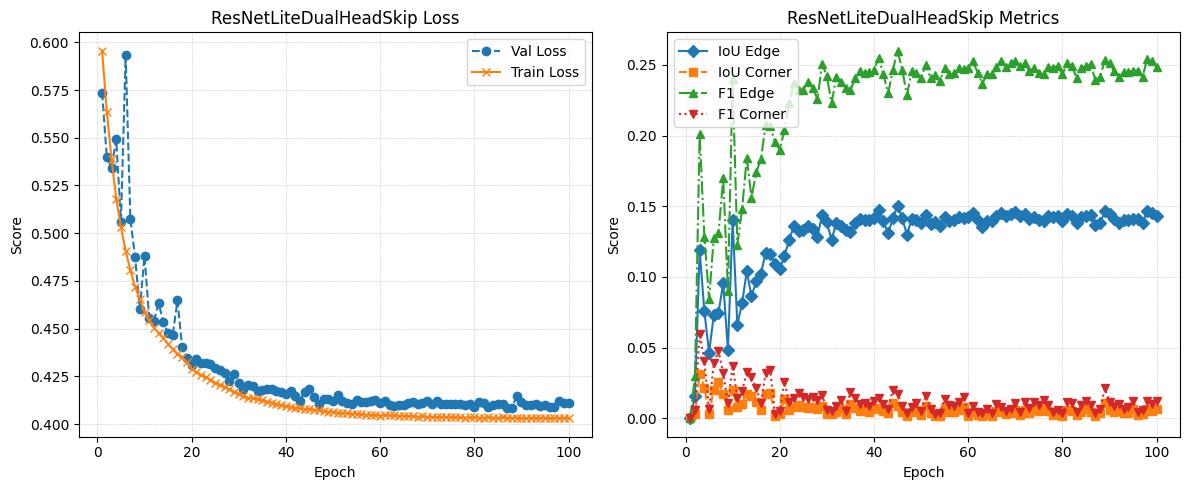

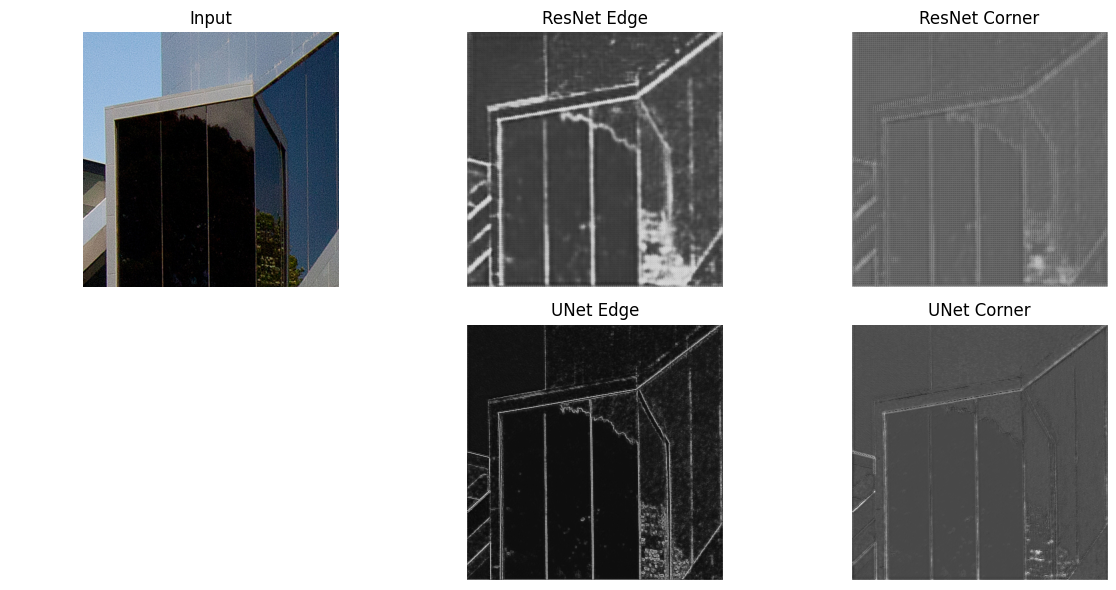

In [22]:
# ===================== SETUP =====================
import torch
import torch.nn as nn
# from model import ResNetLiteDualHeadSkip, UNetDualHead
# from dataset import EdgeCornerDataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
# from train_utils import train_one_epoch, validate, plot_metrics, export_metrics_csv, compare_predictions


# ===================== HYPERPARAMETERS =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4

# ===================== DATA =====================
# dataset = EdgeCornerDataset(root_dir="../data/filtered_crops/")
dataset = EdgeCornerDataset(root_dir="/kaggle/input/jcsmr-data/data/filtered_crops/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ===================== MODEL SETUP =====================
model_1 = ResNetLiteDualHeadSkip().to(device)
model_2 = UNetDualHead().to(device)

loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-4)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.5)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-4)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=10, gamma=0.5)

# ===================== HISTORY TRACKERS =====================
resnet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}
unet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}

# ===================== TRAINING - RESNET =====================
best_val_loss = float("inf")
os.makedirs("/kaggle/working/models", exist_ok = True)
epochs = 100
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [ResNetLiteDualHeadSkip]")
    train_loss = train_one_epoch(model_1, train_loader, loss_fn, optimizer_1, device)
    val_metrics = validate(model_1, val_loader, loss_fn, device)
    scheduler_1.step()

    for key in resnet_history:
        resnet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    resnet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_1.state_dict(), "/kaggle/working/models/resnet_skip_best_adam_lowerLR_bce.pth")
        print("Saved new best ResNet model")


# ===================== TRAINING - UNET =====================
best_val_loss = float("inf")
epochs = 35

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [UNetDualHead]")
    train_loss = train_one_epoch(model_2, train_loader, loss_fn, optimizer_2, device)
    val_metrics = validate(model_2, val_loader, loss_fn, device)
    scheduler_2.step()

    for key in unet_history:
        unet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    unet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_2.state_dict(), "/kaggle/working/models/unet_dual_head_best_adam_lowerLR_bce.pth")
        print("Saved new best UNet model")

# ===================== POST-TRAINING VISUALS =====================
plot_metrics(resnet_history, "ResNetLiteDualHeadSkip")
export_metrics_csv(resnet_history, "ResNetLiteDualHeadSkip")

plot_metrics(unet_history, "UNetDualHead")
export_metrics_csv(unet_history, "UNetDualHead")

compare_predictions(model_1, model_2, val_loader, device)

## UNet and ResNet Models with Leaky-ReLu

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNetDualHead(nn.Module):
    def __init__(self):
        super(UNetDualHead, self).__init__()

        def conv_block(input_channels, output_channels):
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
            )

        # Shared encoder
        self.enc1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        # Bottleneck
        self.bottleneck = conv_block(256, 512)

        # Decoder
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = conv_block(128, 64)

        # Dual output heads
        self.out_edge = nn.Conv2d(64, 1, kernel_size=1)
        self.out_corner = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b = self.bottleneck(self.pool3(e3))

        d1 = self.up1(b)
        d1 = self.dec1(torch.cat([d1, e3], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d3 = self.up3(d2)
        d3 = self.dec3(torch.cat([d3, e1], dim=1))

        out_edge = torch.sigmoid(self.out_edge(d3))
        out_corner = torch.sigmoid(self.out_corner(d3))

        return torch.cat([out_edge, out_corner], dim=1)

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Simple residual block with LeakyReLU
class BasicBlock(nn.Module):
    def __init__(self, input_channel, output_channel, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output_channel)
        self.act = nn.LeakyReLU(negative_slope=0.01, inplace=True)

        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_channel)

        self.downsample = None
        if input_channel != output_channel or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channel)
            )

    def forward(self, x):
        identity = x
        out = self.act(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample:
            identity = self.downsample(identity)

        return self.act(out + identity)

# Main model with LeakyReLU in conv blocks
class ResNetLiteDualHeadSkip(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(input_channel, output_channel):
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
                nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channel),
                nn.LeakyReLU(negative_slope=0.01, inplace=True),
            )

        # Stem
        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(negative_slope=0.01, inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        # Encoder
        self.layer1 = BasicBlock(64, 128, stride=2)   # 128 × 64 × 64
        self.layer2 = BasicBlock(128, 256, stride=2)  # 256 × 32 × 32
        self.layer3 = BasicBlock(256, 512, stride=2)  # 512 × 16 × 16

        # Decoder upsampling
        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        # Decoder conv blocks
        self.dec1 = conv_block(256 + 256, 256)
        self.dec2 = conv_block(128 + 128, 128)
        self.dec3 = conv_block(64 + 64, 64)
        self.dec4 = conv_block(32, 32)
        self.dec5 = conv_block(16, 16)

        # Output heads
        self.out_edge = nn.Conv2d(16, 1, kernel_size=1)
        self.out_corner = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        s = self.stem(x)
        l1 = self.layer1(s)
        l2 = self.layer2(l1)
        l3 = self.layer3(l2)

        x = self.up1(l3)
        x = self.dec1(torch.cat([x, l2], dim=1))

        x = self.up2(x)
        x = self.dec2(torch.cat([x, l1], dim=1))

        x = self.up3(x)
        x = self.dec3(torch.cat([x, s], dim=1))

        x = self.up4(x)
        x = self.dec4(x)

        x = self.up5(x)
        x = self.dec5(x)

        edge = torch.sigmoid(self.out_edge(x))
        corner = torch.sigmoid(self.out_corner(x))

        return torch.cat([edge, corner], dim=1)

In [4]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
# from model import ResNetLiteDualHeadSkip, UNetDualHead

# ===================== Metrics =====================
def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection + 1e-6
    return (intersection / union).item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return (2 * precision * recall / (precision + recall + 1e-6)).item()

# ===================== Loops =====================
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    iou_edge = iou_corner = f1_edge = f1_corner = 0.0
    count = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            for i in range(images.size(0)):
                pred, gt = outputs[i], labels[i]
                iou_edge += compute_iou(pred[0], gt[0])
                iou_corner += compute_iou(pred[1], gt[1])
                f1_edge += compute_f1(pred[0], gt[0])
                f1_corner += compute_f1(pred[1], gt[1])
                count += 1
    return {
        "val_loss": total_loss / len(dataloader),
        "iou_edge": iou_edge / count,
        "iou_corner": iou_corner / count,
        "f1_edge": f1_edge / count,
        "f1_corner": f1_corner / count,
    }

# ===================== Metrics Plot + CSV =====================
def plot_metrics(history, model_name):
    epochs = range(1, len(history["val_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["val_loss"], label="Val Loss", linestyle='--', marker='o')
    plt.plot(epochs, history["train_loss"], label="Train Loss", linestyle='-', marker='x')
    plt.title(f"{model_name} Loss")

    # --- Metrics Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["iou_edge"], label="IoU Edge", linestyle='-', marker='D')
    plt.plot(epochs, history["iou_corner"], label="IoU Corner", linestyle='--', marker='s')
    plt.plot(epochs, history["f1_edge"], label="F1 Edge", linestyle='-.', marker='^')
    plt.plot(epochs, history["f1_corner"], label="F1 Corner", linestyle=':', marker='v')
    plt.title(f"{model_name} Metrics")

    # --- Shared Plot Formatting ---
    for ax in plt.gcf().axes:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle=':', linewidth=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.grid(True)
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    plt.savefig(f"/kaggle/working/plots/{model_name.lower()}_metrics_leaky_relu_bce.png")
    plt.show()

def export_metrics_csv(history, model_name):
    os.makedirs("/kaggle/working/metrics", exist_ok = True)
    file_path = f"/kaggle/working/metrics/{model_name.lower()}_metrics_leaky_relu_bce.csv"
    
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Val Loss", "IoU Edge", "IoU Corner", "F1 Edge", "F1 Corner"])
        for i in range(len(history["val_loss"])):
            writer.writerow([
                i+1,
                history["train_loss"][i], history["val_loss"][i],
                history["iou_edge"][i], history["iou_corner"][i],
                history["f1_edge"][i], history["f1_corner"][i]
            ])

# ===================== Prediction Comparison =====================
def compare_predictions(model1, model2, dataloader, device):
    model1.eval(); model2.eval()
    imgs, labels = next(iter(dataloader))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        preds1 = model1(imgs)
        preds2 = model2(imgs)
        
    for i in range(1):
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        edge1 = preds1[i, 0].cpu().numpy()
        corner1 = preds1[i, 1].cpu().numpy()
        edge2 = preds2[i, 0].cpu().numpy()
        corner2 = preds2[i, 1].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        axes[0, 0].imshow(img)
        axes[0, 1].imshow(edge1, cmap='gray')
        axes[0, 2].imshow(corner1, cmap='gray')
        axes[1, 1].imshow(edge2, cmap='gray')
        axes[1, 2].imshow(corner2, cmap='gray')
        
        for ax in axes.flat: ax.axis("off")
        axes[0, 0].set_title("Input")
        axes[0, 1].set_title("ResNet Edge")
        axes[0, 2].set_title("ResNet Corner")
        axes[1, 1].set_title("UNet Edge")
        axes[1, 2].set_title("UNet Corner")
        
        plt.tight_layout()
        os.makedirs("/kaggle/working/predictions", exist_ok=True)
        plt.savefig(f"/kaggle/working/predictions/single_image_leaky_relu_bce.png")
        plt.show()


Epoch 1/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:07<00:00,  2.81it/s]


Train Loss: 0.6748 | Val Loss: 0.6831 | IoU(E): 0.054 | F1(E): 0.101 | IoU(C): 0.009 | F1(C): 0.018
Saved new best ResNet model

Epoch 2/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.77it/s]


Train Loss: 0.5579 | Val Loss: 0.5491 | IoU(E): 0.016 | F1(E): 0.029 | IoU(C): 0.007 | F1(C): 0.014
Saved new best ResNet model

Epoch 3/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.91it/s]


Train Loss: 0.4953 | Val Loss: 0.4986 | IoU(E): 0.006 | F1(E): 0.011 | IoU(C): 0.011 | F1(C): 0.020
Saved new best ResNet model

Epoch 4/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.89it/s]


Train Loss: 0.4451 | Val Loss: 0.4656 | IoU(E): 0.007 | F1(E): 0.014 | IoU(C): 0.012 | F1(C): 0.024
Saved new best ResNet model

Epoch 5/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.76it/s]


Train Loss: 0.4019 | Val Loss: 0.4078 | IoU(E): 0.001 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 6/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.71it/s]


Train Loss: 0.3605 | Val Loss: 0.3716 | IoU(E): 0.018 | F1(E): 0.033 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 7/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.66it/s]


Train Loss: 0.3245 | Val Loss: 0.3565 | IoU(E): 0.000 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 8/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.77it/s]


Train Loss: 0.2951 | Val Loss: 0.3534 | IoU(E): 0.003 | F1(E): 0.006 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 9/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.70it/s]


Train Loss: 0.2698 | Val Loss: 0.2707 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 10/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.63it/s]


Train Loss: 0.2474 | Val Loss: 0.2608 | IoU(E): 0.009 | F1(E): 0.017 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 11/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.68it/s]


Train Loss: 0.2326 | Val Loss: 0.2250 | IoU(E): 0.003 | F1(E): 0.005 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 12/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.71it/s]


Train Loss: 0.2232 | Val Loss: 0.2222 | IoU(E): 0.004 | F1(E): 0.008 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 13/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.63it/s]


Train Loss: 0.2158 | Val Loss: 0.2194 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 14/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.66it/s]


Train Loss: 0.2080 | Val Loss: 0.2079 | IoU(E): 0.003 | F1(E): 0.006 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 15/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.67it/s]


Train Loss: 0.1994 | Val Loss: 0.2020 | IoU(E): 0.003 | F1(E): 0.007 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 16/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.62it/s]


Train Loss: 0.1917 | Val Loss: 0.2028 | IoU(E): 0.023 | F1(E): 0.045 | IoU(C): 0.000 | F1(C): 0.000

Epoch 17/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.53it/s]


Train Loss: 0.1845 | Val Loss: 0.1960 | IoU(E): 0.016 | F1(E): 0.031 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 18/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.60it/s]


Train Loss: 0.1777 | Val Loss: 0.1847 | IoU(E): 0.021 | F1(E): 0.041 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 19/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.62it/s]


Train Loss: 0.1717 | Val Loss: 0.2011 | IoU(E): 0.132 | F1(E): 0.230 | IoU(C): 0.000 | F1(C): 0.000

Epoch 20/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.58it/s]


Train Loss: 0.1663 | Val Loss: 0.1695 | IoU(E): 0.009 | F1(E): 0.017 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 21/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.57it/s]


Train Loss: 0.1598 | Val Loss: 0.1657 | IoU(E): 0.078 | F1(E): 0.140 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 22/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.56it/s]


Train Loss: 0.1558 | Val Loss: 0.1787 | IoU(E): 0.113 | F1(E): 0.190 | IoU(C): 0.000 | F1(C): 0.000

Epoch 23/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1524 | Val Loss: 0.1627 | IoU(E): 0.115 | F1(E): 0.196 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 24/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.44it/s]


Train Loss: 0.1483 | Val Loss: 0.1580 | IoU(E): 0.174 | F1(E): 0.275 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 25/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.51it/s]


Train Loss: 0.1445 | Val Loss: 0.1512 | IoU(E): 0.197 | F1(E): 0.306 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 26/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1410 | Val Loss: 0.1480 | IoU(E): 0.190 | F1(E): 0.296 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 27/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1374 | Val Loss: 0.1448 | IoU(E): 0.222 | F1(E): 0.340 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 28/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1335 | Val Loss: 0.1512 | IoU(E): 0.221 | F1(E): 0.336 | IoU(C): 0.000 | F1(C): 0.000

Epoch 29/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1309 | Val Loss: 0.1553 | IoU(E): 0.246 | F1(E): 0.369 | IoU(C): 0.000 | F1(C): 0.000

Epoch 30/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.1288 | Val Loss: 0.1422 | IoU(E): 0.253 | F1(E): 0.380 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 31/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.24it/s]


Train Loss: 0.1273 | Val Loss: 0.1420 | IoU(E): 0.237 | F1(E): 0.360 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 32/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.23it/s]


Train Loss: 0.1245 | Val Loss: 0.1337 | IoU(E): 0.248 | F1(E): 0.372 | IoU(C): 0.001 | F1(C): 0.001
Saved new best ResNet model

Epoch 33/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.1239 | Val Loss: 0.1393 | IoU(E): 0.277 | F1(E): 0.408 | IoU(C): 0.002 | F1(C): 0.005

Epoch 34/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.28it/s]


Train Loss: 0.1230 | Val Loss: 0.1401 | IoU(E): 0.274 | F1(E): 0.406 | IoU(C): 0.007 | F1(C): 0.013

Epoch 35/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.1205 | Val Loss: 0.1335 | IoU(E): 0.263 | F1(E): 0.391 | IoU(C): 0.023 | F1(C): 0.043
Saved new best ResNet model

Epoch 36/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.21it/s]


Train Loss: 0.1196 | Val Loss: 0.1304 | IoU(E): 0.269 | F1(E): 0.398 | IoU(C): 0.027 | F1(C): 0.050
Saved new best ResNet model

Epoch 37/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Train Loss: 0.1186 | Val Loss: 0.1320 | IoU(E): 0.279 | F1(E): 0.411 | IoU(C): 0.039 | F1(C): 0.073

Epoch 38/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1170 | Val Loss: 0.1296 | IoU(E): 0.289 | F1(E): 0.423 | IoU(C): 0.070 | F1(C): 0.124
Saved new best ResNet model

Epoch 39/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1175 | Val Loss: 0.1301 | IoU(E): 0.287 | F1(E): 0.420 | IoU(C): 0.088 | F1(C): 0.151

Epoch 40/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.25it/s]


Train Loss: 0.1149 | Val Loss: 0.1273 | IoU(E): 0.291 | F1(E): 0.425 | IoU(C): 0.047 | F1(C): 0.087
Saved new best ResNet model

Epoch 41/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1143 | Val Loss: 0.1283 | IoU(E): 0.294 | F1(E): 0.428 | IoU(C): 0.099 | F1(C): 0.170

Epoch 42/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.50it/s]


Train Loss: 0.1134 | Val Loss: 0.1290 | IoU(E): 0.302 | F1(E): 0.439 | IoU(C): 0.094 | F1(C): 0.163

Epoch 43/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.48it/s]


Train Loss: 0.1130 | Val Loss: 0.1275 | IoU(E): 0.295 | F1(E): 0.430 | IoU(C): 0.107 | F1(C): 0.182

Epoch 44/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1132 | Val Loss: 0.1250 | IoU(E): 0.290 | F1(E): 0.424 | IoU(C): 0.105 | F1(C): 0.179
Saved new best ResNet model

Epoch 45/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1120 | Val Loss: 0.1255 | IoU(E): 0.293 | F1(E): 0.426 | IoU(C): 0.091 | F1(C): 0.158

Epoch 46/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1113 | Val Loss: 0.1265 | IoU(E): 0.305 | F1(E): 0.442 | IoU(C): 0.114 | F1(C): 0.192

Epoch 47/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1104 | Val Loss: 0.1257 | IoU(E): 0.305 | F1(E): 0.443 | IoU(C): 0.130 | F1(C): 0.217

Epoch 48/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1104 | Val Loss: 0.1249 | IoU(E): 0.300 | F1(E): 0.435 | IoU(C): 0.156 | F1(C): 0.251
Saved new best ResNet model

Epoch 49/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1099 | Val Loss: 0.1234 | IoU(E): 0.293 | F1(E): 0.427 | IoU(C): 0.130 | F1(C): 0.216
Saved new best ResNet model

Epoch 50/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.1096 | Val Loss: 0.1238 | IoU(E): 0.304 | F1(E): 0.441 | IoU(C): 0.123 | F1(C): 0.205

Epoch 51/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1096 | Val Loss: 0.1227 | IoU(E): 0.293 | F1(E): 0.426 | IoU(C): 0.147 | F1(C): 0.240
Saved new best ResNet model

Epoch 52/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.25it/s]


Train Loss: 0.1091 | Val Loss: 0.1228 | IoU(E): 0.299 | F1(E): 0.434 | IoU(C): 0.137 | F1(C): 0.227

Epoch 53/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.22it/s]


Train Loss: 0.1086 | Val Loss: 0.1227 | IoU(E): 0.291 | F1(E): 0.424 | IoU(C): 0.139 | F1(C): 0.229
Saved new best ResNet model

Epoch 54/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1080 | Val Loss: 0.1220 | IoU(E): 0.307 | F1(E): 0.444 | IoU(C): 0.137 | F1(C): 0.227
Saved new best ResNet model

Epoch 55/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.1092 | Val Loss: 0.1210 | IoU(E): 0.297 | F1(E): 0.431 | IoU(C): 0.131 | F1(C): 0.217
Saved new best ResNet model

Epoch 56/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1084 | Val Loss: 0.1210 | IoU(E): 0.299 | F1(E): 0.433 | IoU(C): 0.137 | F1(C): 0.226

Epoch 57/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1073 | Val Loss: 0.1233 | IoU(E): 0.301 | F1(E): 0.436 | IoU(C): 0.158 | F1(C): 0.257

Epoch 58/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.49it/s]


Train Loss: 0.1082 | Val Loss: 0.1193 | IoU(E): 0.294 | F1(E): 0.428 | IoU(C): 0.145 | F1(C): 0.237
Saved new best ResNet model

Epoch 59/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1073 | Val Loss: 0.1206 | IoU(E): 0.297 | F1(E): 0.433 | IoU(C): 0.160 | F1(C): 0.259

Epoch 60/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.27it/s]


Train Loss: 0.1072 | Val Loss: 0.1205 | IoU(E): 0.298 | F1(E): 0.433 | IoU(C): 0.150 | F1(C): 0.244

Epoch 61/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.43it/s]


Train Loss: 0.1067 | Val Loss: 0.1210 | IoU(E): 0.301 | F1(E): 0.436 | IoU(C): 0.160 | F1(C): 0.261

Epoch 62/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1069 | Val Loss: 0.1199 | IoU(E): 0.302 | F1(E): 0.438 | IoU(C): 0.150 | F1(C): 0.246

Epoch 63/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.27it/s]


Train Loss: 0.1059 | Val Loss: 0.1192 | IoU(E): 0.295 | F1(E): 0.430 | IoU(C): 0.151 | F1(C): 0.246
Saved new best ResNet model

Epoch 64/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.25it/s]


Train Loss: 0.1063 | Val Loss: 0.1213 | IoU(E): 0.297 | F1(E): 0.431 | IoU(C): 0.165 | F1(C): 0.267

Epoch 65/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.26it/s]


Train Loss: 0.1058 | Val Loss: 0.1205 | IoU(E): 0.305 | F1(E): 0.441 | IoU(C): 0.155 | F1(C): 0.254

Epoch 66/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.1059 | Val Loss: 0.1188 | IoU(E): 0.299 | F1(E): 0.435 | IoU(C): 0.164 | F1(C): 0.263
Saved new best ResNet model

Epoch 67/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.26it/s]


Train Loss: 0.1051 | Val Loss: 0.1204 | IoU(E): 0.309 | F1(E): 0.446 | IoU(C): 0.180 | F1(C): 0.289

Epoch 68/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1056 | Val Loss: 0.1183 | IoU(E): 0.301 | F1(E): 0.436 | IoU(C): 0.160 | F1(C): 0.258
Saved new best ResNet model

Epoch 69/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1063 | Val Loss: 0.1188 | IoU(E): 0.302 | F1(E): 0.437 | IoU(C): 0.163 | F1(C): 0.264

Epoch 70/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1050 | Val Loss: 0.1191 | IoU(E): 0.310 | F1(E): 0.447 | IoU(C): 0.181 | F1(C): 0.288

Epoch 71/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.38it/s]


Train Loss: 0.1058 | Val Loss: 0.1209 | IoU(E): 0.302 | F1(E): 0.438 | IoU(C): 0.172 | F1(C): 0.279

Epoch 72/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1049 | Val Loss: 0.1193 | IoU(E): 0.297 | F1(E): 0.432 | IoU(C): 0.155 | F1(C): 0.254

Epoch 73/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1046 | Val Loss: 0.1178 | IoU(E): 0.301 | F1(E): 0.437 | IoU(C): 0.167 | F1(C): 0.269
Saved new best ResNet model

Epoch 74/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.26it/s]


Train Loss: 0.1054 | Val Loss: 0.1202 | IoU(E): 0.310 | F1(E): 0.448 | IoU(C): 0.196 | F1(C): 0.311

Epoch 75/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.1047 | Val Loss: 0.1186 | IoU(E): 0.300 | F1(E): 0.435 | IoU(C): 0.158 | F1(C): 0.258

Epoch 76/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.27it/s]


Train Loss: 0.1052 | Val Loss: 0.1204 | IoU(E): 0.303 | F1(E): 0.439 | IoU(C): 0.181 | F1(C): 0.290

Epoch 77/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.11it/s]


Train Loss: 0.1046 | Val Loss: 0.1188 | IoU(E): 0.297 | F1(E): 0.432 | IoU(C): 0.159 | F1(C): 0.259

Epoch 78/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.1049 | Val Loss: 0.1183 | IoU(E): 0.307 | F1(E): 0.444 | IoU(C): 0.183 | F1(C): 0.291

Epoch 79/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.29it/s]


Train Loss: 0.1041 | Val Loss: 0.1180 | IoU(E): 0.307 | F1(E): 0.444 | IoU(C): 0.173 | F1(C): 0.278

Epoch 80/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.33it/s]


Train Loss: 0.1042 | Val Loss: 0.1185 | IoU(E): 0.307 | F1(E): 0.444 | IoU(C): 0.176 | F1(C): 0.282

Epoch 81/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.26it/s]


Train Loss: 0.1051 | Val Loss: 0.1180 | IoU(E): 0.305 | F1(E): 0.442 | IoU(C): 0.175 | F1(C): 0.280

Epoch 82/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1054 | Val Loss: 0.1180 | IoU(E): 0.301 | F1(E): 0.436 | IoU(C): 0.167 | F1(C): 0.269

Epoch 83/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1048 | Val Loss: 0.1177 | IoU(E): 0.301 | F1(E): 0.437 | IoU(C): 0.169 | F1(C): 0.271
Saved new best ResNet model

Epoch 84/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1053 | Val Loss: 0.1177 | IoU(E): 0.302 | F1(E): 0.437 | IoU(C): 0.168 | F1(C): 0.271

Epoch 85/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.1052 | Val Loss: 0.1191 | IoU(E): 0.302 | F1(E): 0.437 | IoU(C): 0.177 | F1(C): 0.283

Epoch 86/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1037 | Val Loss: 0.1185 | IoU(E): 0.301 | F1(E): 0.437 | IoU(C): 0.168 | F1(C): 0.271

Epoch 87/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1044 | Val Loss: 0.1179 | IoU(E): 0.303 | F1(E): 0.439 | IoU(C): 0.176 | F1(C): 0.282

Epoch 88/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.30it/s]


Train Loss: 0.1042 | Val Loss: 0.1186 | IoU(E): 0.310 | F1(E): 0.447 | IoU(C): 0.175 | F1(C): 0.281

Epoch 89/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.25it/s]


Train Loss: 0.1044 | Val Loss: 0.1192 | IoU(E): 0.309 | F1(E): 0.446 | IoU(C): 0.188 | F1(C): 0.300

Epoch 90/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  5.24it/s]


Train Loss: 0.1043 | Val Loss: 0.1185 | IoU(E): 0.307 | F1(E): 0.444 | IoU(C): 0.172 | F1(C): 0.277

Epoch 91/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1047 | Val Loss: 0.1191 | IoU(E): 0.305 | F1(E): 0.441 | IoU(C): 0.190 | F1(C): 0.303

Epoch 92/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.37it/s]


Train Loss: 0.1041 | Val Loss: 0.1178 | IoU(E): 0.304 | F1(E): 0.440 | IoU(C): 0.189 | F1(C): 0.300

Epoch 93/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.36it/s]


Train Loss: 0.1041 | Val Loss: 0.1175 | IoU(E): 0.302 | F1(E): 0.438 | IoU(C): 0.180 | F1(C): 0.287
Saved new best ResNet model

Epoch 94/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.35it/s]


Train Loss: 0.1041 | Val Loss: 0.1194 | IoU(E): 0.302 | F1(E): 0.438 | IoU(C): 0.175 | F1(C): 0.280

Epoch 95/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.34it/s]


Train Loss: 0.1039 | Val Loss: 0.1178 | IoU(E): 0.304 | F1(E): 0.440 | IoU(C): 0.181 | F1(C): 0.289

Epoch 96/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.41it/s]


Train Loss: 0.1037 | Val Loss: 0.1195 | IoU(E): 0.300 | F1(E): 0.435 | IoU(C): 0.171 | F1(C): 0.278

Epoch 97/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.32it/s]


Train Loss: 0.1045 | Val Loss: 0.1178 | IoU(E): 0.295 | F1(E): 0.428 | IoU(C): 0.162 | F1(C): 0.263

Epoch 98/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.42it/s]


Train Loss: 0.1038 | Val Loss: 0.1184 | IoU(E): 0.300 | F1(E): 0.435 | IoU(C): 0.175 | F1(C): 0.282

Epoch 99/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.46it/s]


Train Loss: 0.1040 | Val Loss: 0.1183 | IoU(E): 0.305 | F1(E): 0.442 | IoU(C): 0.182 | F1(C): 0.291

Epoch 100/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:03<00:00,  5.39it/s]


Train Loss: 0.1039 | Val Loss: 0.1179 | IoU(E): 0.301 | F1(E): 0.437 | IoU(C): 0.181 | F1(C): 0.291

Epoch 1/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.06it/s]


Train Loss: 0.4937 | Val Loss: 0.8147 | IoU(E): 0.063 | F1(E): 0.113 | IoU(C): 0.014 | F1(C): 0.026
Saved new best UNet model

Epoch 2/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.3114 | Val Loss: 0.2924 | IoU(E): 0.163 | F1(E): 0.265 | IoU(C): 0.000 | F1(C): 0.001
Saved new best UNet model

Epoch 3/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.2181 | Val Loss: 0.2364 | IoU(E): 0.346 | F1(E): 0.499 | IoU(C): 0.003 | F1(C): 0.006
Saved new best UNet model

Epoch 4/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.1594 | Val Loss: 0.1606 | IoU(E): 0.447 | F1(E): 0.607 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 5/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.1236 | Val Loss: 0.1349 | IoU(E): 0.534 | F1(E): 0.688 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 6/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.1037 | Val Loss: 0.1319 | IoU(E): 0.566 | F1(E): 0.717 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 7/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0883 | Val Loss: 0.0934 | IoU(E): 0.604 | F1(E): 0.749 | IoU(C): 0.002 | F1(C): 0.004
Saved new best UNet model

Epoch 8/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0772 | Val Loss: 0.0871 | IoU(E): 0.564 | F1(E): 0.715 | IoU(C): 0.001 | F1(C): 0.002
Saved new best UNet model

Epoch 9/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0693 | Val Loss: 0.0845 | IoU(E): 0.558 | F1(E): 0.709 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 10/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0673 | Val Loss: 0.0825 | IoU(E): 0.621 | F1(E): 0.762 | IoU(C): 0.007 | F1(C): 0.014
Saved new best UNet model

Epoch 11/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0617 | Val Loss: 0.0691 | IoU(E): 0.666 | F1(E): 0.797 | IoU(C): 0.007 | F1(C): 0.014
Saved new best UNet model

Epoch 12/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0582 | Val Loss: 0.0693 | IoU(E): 0.663 | F1(E): 0.795 | IoU(C): 0.001 | F1(C): 0.001

Epoch 13/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0589 | Val Loss: 0.0685 | IoU(E): 0.607 | F1(E): 0.752 | IoU(C): 0.015 | F1(C): 0.028
Saved new best UNet model

Epoch 14/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0595 | Val Loss: 0.0667 | IoU(E): 0.654 | F1(E): 0.788 | IoU(C): 0.033 | F1(C): 0.061
Saved new best UNet model

Epoch 15/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0558 | Val Loss: 0.0640 | IoU(E): 0.641 | F1(E): 0.776 | IoU(C): 0.034 | F1(C): 0.063
Saved new best UNet model

Epoch 16/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0535 | Val Loss: 0.0626 | IoU(E): 0.681 | F1(E): 0.808 | IoU(C): 0.085 | F1(C): 0.148
Saved new best UNet model

Epoch 17/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0517 | Val Loss: 0.0698 | IoU(E): 0.648 | F1(E): 0.784 | IoU(C): 0.032 | F1(C): 0.059

Epoch 18/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0502 | Val Loss: 0.0695 | IoU(E): 0.686 | F1(E): 0.811 | IoU(C): 0.194 | F1(C): 0.305

Epoch 19/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0497 | Val Loss: 0.0585 | IoU(E): 0.662 | F1(E): 0.794 | IoU(C): 0.152 | F1(C): 0.247
Saved new best UNet model

Epoch 20/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0487 | Val Loss: 0.0567 | IoU(E): 0.641 | F1(E): 0.778 | IoU(C): 0.054 | F1(C): 0.098
Saved new best UNet model

Epoch 21/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.09it/s]


Train Loss: 0.0461 | Val Loss: 0.0525 | IoU(E): 0.685 | F1(E): 0.810 | IoU(C): 0.153 | F1(C): 0.249
Saved new best UNet model

Epoch 22/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0458 | Val Loss: 0.0570 | IoU(E): 0.675 | F1(E): 0.803 | IoU(C): 0.241 | F1(C): 0.364

Epoch 23/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0456 | Val Loss: 0.0538 | IoU(E): 0.695 | F1(E): 0.817 | IoU(C): 0.254 | F1(C): 0.381

Epoch 24/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0447 | Val Loss: 0.0526 | IoU(E): 0.696 | F1(E): 0.818 | IoU(C): 0.271 | F1(C): 0.402

Epoch 25/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0442 | Val Loss: 0.0513 | IoU(E): 0.696 | F1(E): 0.819 | IoU(C): 0.302 | F1(C): 0.439
Saved new best UNet model

Epoch 26/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0442 | Val Loss: 0.0513 | IoU(E): 0.699 | F1(E): 0.821 | IoU(C): 0.262 | F1(C): 0.391
Saved new best UNet model

Epoch 27/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0448 | Val Loss: 0.0522 | IoU(E): 0.695 | F1(E): 0.817 | IoU(C): 0.080 | F1(C): 0.143

Epoch 28/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0430 | Val Loss: 0.0552 | IoU(E): 0.684 | F1(E): 0.810 | IoU(C): 0.106 | F1(C): 0.181

Epoch 29/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0419 | Val Loss: 0.0484 | IoU(E): 0.700 | F1(E): 0.821 | IoU(C): 0.257 | F1(C): 0.387
Saved new best UNet model

Epoch 30/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0423 | Val Loss: 0.0510 | IoU(E): 0.690 | F1(E): 0.815 | IoU(C): 0.352 | F1(C): 0.496

Epoch 31/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.07it/s]


Train Loss: 0.0416 | Val Loss: 0.0481 | IoU(E): 0.711 | F1(E): 0.829 | IoU(C): 0.358 | F1(C): 0.501
Saved new best UNet model

Epoch 32/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0407 | Val Loss: 0.0491 | IoU(E): 0.700 | F1(E): 0.821 | IoU(C): 0.217 | F1(C): 0.339

Epoch 33/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0410 | Val Loss: 0.0497 | IoU(E): 0.694 | F1(E): 0.816 | IoU(C): 0.231 | F1(C): 0.357

Epoch 34/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0403 | Val Loss: 0.0468 | IoU(E): 0.704 | F1(E): 0.823 | IoU(C): 0.265 | F1(C): 0.396
Saved new best UNet model

Epoch 35/35 [UNetDualHead]


100%|██████████| 21/21 [00:19<00:00,  1.08it/s]


Train Loss: 0.0418 | Val Loss: 0.0473 | IoU(E): 0.709 | F1(E): 0.828 | IoU(C): 0.381 | F1(C): 0.524


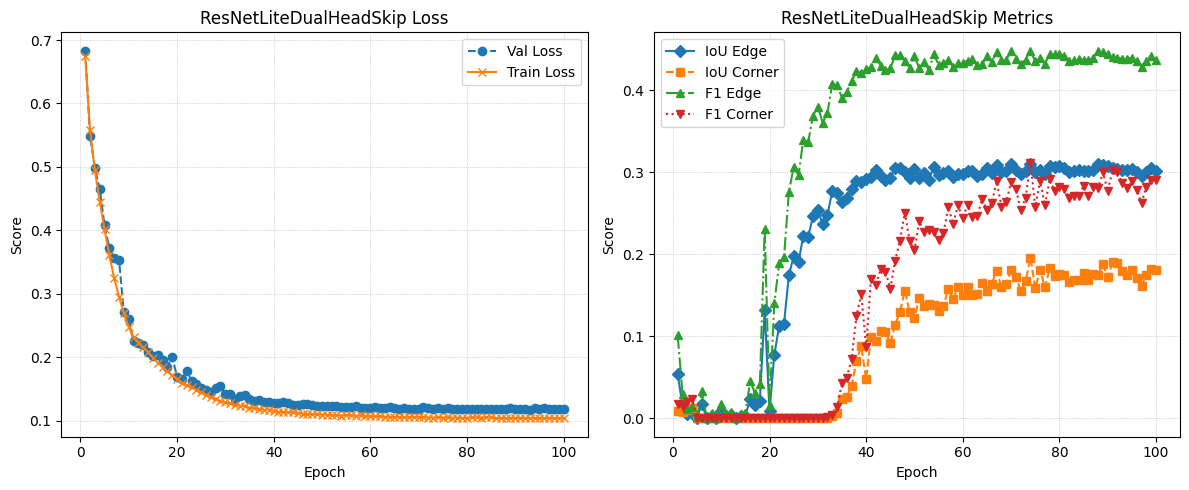

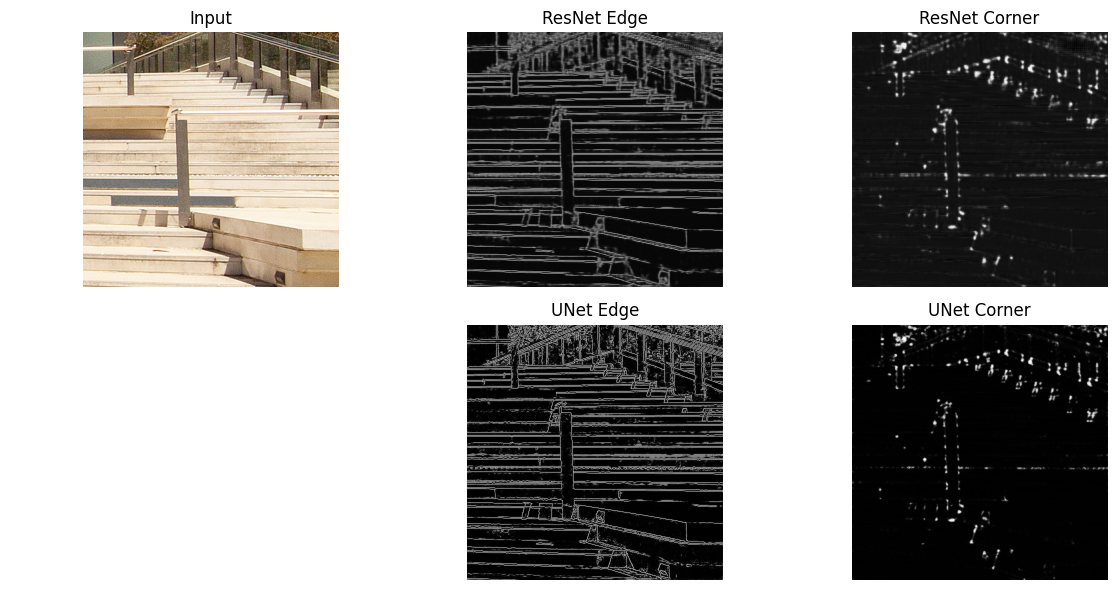

In [5]:
# ===================== SETUP =====================
import torch
import torch.nn as nn
# from model import ResNetLiteDualHeadSkip, UNetDualHead
# from dataset import EdgeCornerDataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
# from train_utils import train_one_epoch, validate, plot_metrics, export_metrics_csv, compare_predictions


# ===================== HYPERPARAMETERS =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4

# ===================== DATA =====================
# dataset = EdgeCornerDataset(root_dir="../data/filtered_crops/")
dataset = EdgeCornerDataset(root_dir="/kaggle/input/jcsmr-data/data/filtered_crops/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ===================== MODEL SETUP =====================
model_1 = ResNetLiteDualHeadSkip().to(device)
model_2 = UNetDualHead().to(device)

loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.5)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=10, gamma=0.5)

# ===================== HISTORY TRACKERS =====================
resnet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}
unet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}

# ===================== TRAINING - RESNET =====================
best_val_loss = float("inf")
os.makedirs("/kaggle/working/models", exist_ok = True)
epochs = 100
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [ResNetLiteDualHeadSkip]")
    train_loss = train_one_epoch(model_1, train_loader, loss_fn, optimizer_1, device)
    val_metrics = validate(model_1, val_loader, loss_fn, device)
    scheduler_1.step()

    for key in resnet_history:
        resnet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    resnet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_1.state_dict(), "/kaggle/working/models/resnet_skip_best_leaky_relu_bce.pth")
        print("Saved new best ResNet model")


# ===================== TRAINING - UNET =====================
best_val_loss = float("inf")
epochs = 35

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [UNetDualHead]")
    train_loss = train_one_epoch(model_2, train_loader, loss_fn, optimizer_2, device)
    val_metrics = validate(model_2, val_loader, loss_fn, device)
    scheduler_2.step()

    for key in unet_history:
        unet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    unet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_2.state_dict(), "/kaggle/working/models/unet_dual_head_best_leaky_relu_bce.pth")
        print("Saved new best UNet model")

# ===================== POST-TRAINING VISUALS =====================
plot_metrics(resnet_history, "ResNetLiteDualHeadSkip")
export_metrics_csv(resnet_history, "ResNetLiteDualHeadSkip")

plot_metrics(unet_history, "UNetDualHead")
export_metrics_csv(unet_history, "UNetDualHead")

compare_predictions(model_1, model_2, val_loader, device)

## ResNet and UNet using Mish Activation

In [6]:
class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class UNetDualHead(nn.Module):
    def __init__(self):
        super(UNetDualHead, self).__init__()

        def conv_block(input_channels, output_channels):
            return nn.Sequential(
                nn.Conv2d(input_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                Mish(),
                nn.Conv2d(output_channels, output_channels, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channels),
                Mish(),
            )

        self.enc1 = conv_block(3, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(256, 512)

        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec1 = conv_block(512, 256)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec3 = conv_block(128, 64)

        self.out_edge = nn.Conv2d(64, 1, kernel_size=1)
        self.out_corner = nn.Conv2d(64, 1, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        b = self.bottleneck(self.pool3(e3))

        d1 = self.up1(b)
        d1 = self.dec1(torch.cat([d1, e3], dim=1))
        d2 = self.up2(d1)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))
        d3 = self.up3(d2)
        d3 = self.dec3(torch.cat([d3, e1], dim=1))

        out_edge = torch.sigmoid(self.out_edge(d3))
        out_corner = torch.sigmoid(self.out_corner(d3))

        return torch.cat([out_edge, out_corner], dim=1)

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Mish(nn.Module):
    def forward(self, x):
        return x * torch.tanh(F.softplus(x))

class BasicBlock(nn.Module):
    def __init__(self, input_channel, output_channel, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channel, output_channel, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(output_channel)
        self.activation = Mish()

        self.conv2 = nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(output_channel)

        self.downsample = None
        if input_channel != output_channel or stride != 1:
            self.downsample = nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=1, stride=stride),
                nn.BatchNorm2d(output_channel)
            )

    def forward(self, x):
        identity = x
        out = self.activation(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))

        if self.downsample:
            identity = self.downsample(identity)

        return self.activation(out + identity)

class ResNetLiteDualHeadSkip(nn.Module):
    def __init__(self):
        super().__init__()

        def conv_block(input_channel, output_channel):
            return nn.Sequential(
                nn.Conv2d(input_channel, output_channel, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channel),
                Mish(),
                nn.Conv2d(output_channel, output_channel, kernel_size=3, padding=1),
                nn.BatchNorm2d(output_channel),
                Mish(),
            )

        self.stem = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            Mish(),
            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        )

        self.layer1 = BasicBlock(64, 128, stride=2)
        self.layer2 = BasicBlock(128, 256, stride=2)
        self.layer3 = BasicBlock(256, 512, stride=2)

        self.up1 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up3 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up4 = nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2)
        self.up5 = nn.ConvTranspose2d(32, 16, kernel_size=2, stride=2)

        self.dec1 = conv_block(256 + 256, 256)
        self.dec2 = conv_block(128 + 128, 128)
        self.dec3 = conv_block(64 + 64, 64)
        self.dec4 = conv_block(32, 32)
        self.dec5 = conv_block(16, 16)

        self.out_edge = nn.Conv2d(16, 1, kernel_size=1)
        self.out_corner = nn.Conv2d(16, 1, kernel_size=1)

    def forward(self, x):
        s = self.stem(x)
        l1 = self.layer1(s)
        l2 = self.layer2(l1)
        l3 = self.layer3(l2)

        x = self.up1(l3)
        x = self.dec1(torch.cat([x, l2], dim=1))

        x = self.up2(x)
        x = self.dec2(torch.cat([x, l1], dim=1))

        x = self.up3(x)
        x = self.dec3(torch.cat([x, s], dim=1))

        x = self.up4(x)
        x = self.dec4(x)

        x = self.up5(x)
        x = self.dec5(x)

        edge = torch.sigmoid(self.out_edge(x))
        corner = torch.sigmoid(self.out_corner(x))

        return torch.cat([edge, corner], dim=1)

In [9]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import csv
import os
from tqdm import tqdm
# from model import ResNetLiteDualHeadSkip, UNetDualHead

# ===================== Metrics =====================
def compute_iou(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    intersection = (pred_bin * target_bin).sum()
    union = pred_bin.sum() + target_bin.sum() - intersection + 1e-6
    return (intersection / union).item()

def compute_f1(pred, target, threshold=0.5):
    pred_bin = (pred > threshold).float()
    target_bin = (target > threshold).float()
    tp = (pred_bin * target_bin).sum()
    fp = (pred_bin * (1 - target_bin)).sum()
    fn = ((1 - pred_bin) * target_bin).sum()
    precision = tp / (tp + fp + 1e-6)
    recall = tp / (tp + fn + 1e-6)
    return (2 * precision * recall / (precision + recall + 1e-6)).item()

# ===================== Loops =====================
def train_one_epoch(model, dataloader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate(model, dataloader, loss_fn, device):
    model.eval()
    total_loss = 0.0
    iou_edge = iou_corner = f1_edge = f1_corner = 0.0
    count = 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            total_loss += loss.item()
            for i in range(images.size(0)):
                pred, gt = outputs[i], labels[i]
                iou_edge += compute_iou(pred[0], gt[0])
                iou_corner += compute_iou(pred[1], gt[1])
                f1_edge += compute_f1(pred[0], gt[0])
                f1_corner += compute_f1(pred[1], gt[1])
                count += 1
    return {
        "val_loss": total_loss / len(dataloader),
        "iou_edge": iou_edge / count,
        "iou_corner": iou_corner / count,
        "f1_edge": f1_edge / count,
        "f1_corner": f1_corner / count,
    }

# ===================== Metrics Plot + CSV =====================
def plot_metrics(history, model_name):
    epochs = range(1, len(history["val_loss"]) + 1)
    
    plt.figure(figsize=(12, 5))

    # --- Loss Plot ---
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["val_loss"], label="Val Loss", linestyle='--', marker='o')
    plt.plot(epochs, history["train_loss"], label="Train Loss", linestyle='-', marker='x')
    plt.title(f"{model_name} Loss")

    # --- Metrics Plot ---
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["iou_edge"], label="IoU Edge", linestyle='-', marker='D')
    plt.plot(epochs, history["iou_corner"], label="IoU Corner", linestyle='--', marker='s')
    plt.plot(epochs, history["f1_edge"], label="F1 Edge", linestyle='-.', marker='^')
    plt.plot(epochs, history["f1_corner"], label="F1 Corner", linestyle=':', marker='v')
    plt.title(f"{model_name} Metrics")

    # --- Shared Plot Formatting ---
    for ax in plt.gcf().axes:
        ax.set_xlabel("Epoch")
        ax.set_ylabel("Score")
        ax.grid(True, linestyle=':', linewidth=0.5)
        ax.legend()
    
    plt.tight_layout()
    plt.grid(True)
    os.makedirs("/kaggle/working/plots", exist_ok=True)
    plt.savefig(f"/kaggle/working/plots/{model_name.lower()}_metrics_mish_bce.png")
    plt.show()

def export_metrics_csv(history, model_name):
    os.makedirs("/kaggle/working/metrics", exist_ok = True)
    file_path = f"/kaggle/working/metrics/{model_name.lower()}_metrics_leaky_mish_bce.csv"
    
    with open(file_path, 'w', newline='') as file:
        writer = csv.writer(file)
        writer.writerow(["Epoch", "Train Loss", "Val Loss", "IoU Edge", "IoU Corner", "F1 Edge", "F1 Corner"])
        for i in range(len(history["val_loss"])):
            writer.writerow([
                i+1,
                history["train_loss"][i], history["val_loss"][i],
                history["iou_edge"][i], history["iou_corner"][i],
                history["f1_edge"][i], history["f1_corner"][i]
            ])

# ===================== Prediction Comparison =====================
def compare_predictions(model1, model2, dataloader, device):
    model1.eval(); model2.eval()
    imgs, labels = next(iter(dataloader))
    imgs = imgs.to(device)
    
    with torch.no_grad():
        preds1 = model1(imgs)
        preds2 = model2(imgs)
        
    for i in range(1):
        img = imgs[i].cpu().permute(1, 2, 0).numpy()
        edge1 = preds1[i, 0].cpu().numpy()
        corner1 = preds1[i, 1].cpu().numpy()
        edge2 = preds2[i, 0].cpu().numpy()
        corner2 = preds2[i, 1].cpu().numpy()
        
        fig, axes = plt.subplots(2, 3, figsize=(12, 6))
        axes[0, 0].imshow(img)
        axes[0, 1].imshow(edge1, cmap='gray')
        axes[0, 2].imshow(corner1, cmap='gray')
        axes[1, 1].imshow(edge2, cmap='gray')
        axes[1, 2].imshow(corner2, cmap='gray')
        
        for ax in axes.flat: ax.axis("off")
        axes[0, 0].set_title("Input")
        axes[0, 1].set_title("ResNet Edge")
        axes[0, 2].set_title("ResNet Corner")
        axes[1, 1].set_title("UNet Edge")
        axes[1, 2].set_title("UNet Corner")
        
        plt.tight_layout()
        os.makedirs("/kaggle/working/predictions", exist_ok=True)
        plt.savefig(f"/kaggle/working/predictions/single_image_mish_bce.png")
        plt.show()

In [ ]:
# ===================== SETUP =====================
import torch
import torch.nn as nn
# from model import ResNetLiteDualHeadSkip, UNetDualHead
# from dataset import EdgeCornerDataset
from torch.utils.data import DataLoader, random_split
from tqdm import tqdm
# from train_utils import train_one_epoch, validate, plot_metrics, export_metrics_csv, compare_predictions


# ===================== HYPERPARAMETERS =====================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 4

# ===================== DATA =====================
# dataset = EdgeCornerDataset(root_dir="../data/filtered_crops/")
dataset = EdgeCornerDataset(root_dir="/kaggle/input/jcsmr-data/data/filtered_crops/")
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# ===================== MODEL SETUP =====================
model_1 = ResNetLiteDualHeadSkip().to(device)
model_2 = UNetDualHead().to(device)

loss_fn = nn.BCELoss()
optimizer_1 = torch.optim.Adam(model_1.parameters(), lr=1e-3)
scheduler_1 = torch.optim.lr_scheduler.StepLR(optimizer_1, step_size=10, gamma=0.5)
optimizer_2 = torch.optim.Adam(model_2.parameters(), lr=1e-3)
scheduler_2 = torch.optim.lr_scheduler.StepLR(optimizer_2, step_size=10, gamma=0.5)

# ===================== HISTORY TRACKERS =====================
resnet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}
unet_history = {key: [] for key in ["train_loss", "val_loss", "iou_edge", "iou_corner", "f1_edge", "f1_corner"]}

# ===================== TRAINING - RESNET =====================
best_val_loss = float("inf")
os.makedirs("/kaggle/working/models", exist_ok = True)
epochs = 100
for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [ResNetLiteDualHeadSkip]")
    train_loss = train_one_epoch(model_1, train_loader, loss_fn, optimizer_1, device)
    val_metrics = validate(model_1, val_loader, loss_fn, device)
    scheduler_1.step()

    for key in resnet_history:
        resnet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    resnet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_1.state_dict(), "/kaggle/working/models/resnet_skip_best_mish_bce.pth")
        print("Saved new best ResNet model")


# ===================== TRAINING - UNET =====================
best_val_loss = float("inf")
epochs = 35

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs} [UNetDualHead]")
    train_loss = train_one_epoch(model_2, train_loader, loss_fn, optimizer_2, device)
    val_metrics = validate(model_2, val_loader, loss_fn, device)
    scheduler_2.step()

    for key in unet_history:
        unet_history[key].append(val_metrics.get(key, train_loss if key == "train_loss" else None))
    unet_history["train_loss"][epoch] = train_loss

    print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_metrics['val_loss']:.4f} | IoU(E): {val_metrics['iou_edge']:.3f} | F1(E): {val_metrics['f1_edge']:.3f} | IoU(C): {val_metrics['iou_corner']:.3f} | F1(C): {val_metrics['f1_corner']:.3f}")

    if val_metrics["val_loss"] < best_val_loss:
        best_val_loss = val_metrics["val_loss"]
        torch.save(model_2.state_dict(), "/kaggle/working/models/unet_dual_head_best_mish_bce.pth")
        print("Saved new best UNet model")

# ===================== POST-TRAINING VISUALS =====================
plot_metrics(resnet_history, "ResNetLiteDualHeadSkip")
export_metrics_csv(resnet_history, "ResNetLiteDualHeadSkip")

plot_metrics(unet_history, "UNetDualHead")
export_metrics_csv(unet_history, "UNetDualHead")

compare_predictions(model_1, model_2, val_loader, device)


Epoch 1/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.67it/s]


Train Loss: 0.6546 | Val Loss: 0.6128 | IoU(E): 0.000 | F1(E): 0.000 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 2/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Train Loss: 0.5915 | Val Loss: 0.5092 | IoU(E): 0.112 | F1(E): 0.195 | IoU(C): 0.017 | F1(C): 0.033
Saved new best ResNet model

Epoch 3/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


Train Loss: 0.5434 | Val Loss: 0.7430 | IoU(E): 0.103 | F1(E): 0.183 | IoU(C): 0.028 | F1(C): 0.052

Epoch 4/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.4978 | Val Loss: 0.4690 | IoU(E): 0.249 | F1(E): 0.396 | IoU(C): 0.004 | F1(C): 0.007
Saved new best ResNet model

Epoch 5/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.4527 | Val Loss: 0.5667 | IoU(E): 0.171 | F1(E): 0.287 | IoU(C): 0.018 | F1(C): 0.034

Epoch 6/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.4066 | Val Loss: 0.4383 | IoU(E): 0.203 | F1(E): 0.332 | IoU(C): 0.010 | F1(C): 0.019
Saved new best ResNet model

Epoch 7/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.3600 | Val Loss: 0.3539 | IoU(E): 0.039 | F1(E): 0.074 | IoU(C): 0.001 | F1(C): 0.001
Saved new best ResNet model

Epoch 8/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


Train Loss: 0.3172 | Val Loss: 0.3140 | IoU(E): 0.000 | F1(E): 0.001 | IoU(C): 0.000 | F1(C): 0.000
Saved new best ResNet model

Epoch 9/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


Train Loss: 0.2804 | Val Loss: 0.3036 | IoU(E): 0.021 | F1(E): 0.039 | IoU(C): 0.016 | F1(C): 0.027
Saved new best ResNet model

Epoch 10/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Train Loss: 0.2496 | Val Loss: 0.2515 | IoU(E): 0.011 | F1(E): 0.021 | IoU(C): 0.006 | F1(C): 0.011
Saved new best ResNet model

Epoch 11/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.2280 | Val Loss: 0.2396 | IoU(E): 0.003 | F1(E): 0.005 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 12/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


Train Loss: 0.2150 | Val Loss: 0.2198 | IoU(E): 0.003 | F1(E): 0.005 | IoU(C): 0.002 | F1(C): 0.004
Saved new best ResNet model

Epoch 13/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.2049 | Val Loss: 0.2140 | IoU(E): 0.001 | F1(E): 0.002 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 14/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Train Loss: 0.1954 | Val Loss: 0.2021 | IoU(E): 0.009 | F1(E): 0.017 | IoU(C): 0.001 | F1(C): 0.002
Saved new best ResNet model

Epoch 15/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


Train Loss: 0.1855 | Val Loss: 0.2110 | IoU(E): 0.017 | F1(E): 0.033 | IoU(C): 0.004 | F1(C): 0.007

Epoch 16/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


Train Loss: 0.1772 | Val Loss: 0.1934 | IoU(E): 0.039 | F1(E): 0.074 | IoU(C): 0.003 | F1(C): 0.006
Saved new best ResNet model

Epoch 17/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


Train Loss: 0.1696 | Val Loss: 0.1807 | IoU(E): 0.081 | F1(E): 0.143 | IoU(C): 0.005 | F1(C): 0.009
Saved new best ResNet model

Epoch 18/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.1622 | Val Loss: 0.1772 | IoU(E): 0.167 | F1(E): 0.271 | IoU(C): 0.013 | F1(C): 0.025
Saved new best ResNet model

Epoch 19/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.1552 | Val Loss: 0.1612 | IoU(E): 0.179 | F1(E): 0.285 | IoU(C): 0.004 | F1(C): 0.007
Saved new best ResNet model

Epoch 20/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.65it/s]


Train Loss: 0.1469 | Val Loss: 0.1743 | IoU(E): 0.265 | F1(E): 0.394 | IoU(C): 0.022 | F1(C): 0.041

Epoch 21/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.64it/s]


Train Loss: 0.1400 | Val Loss: 0.1449 | IoU(E): 0.299 | F1(E): 0.430 | IoU(C): 0.010 | F1(C): 0.018
Saved new best ResNet model

Epoch 22/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.70it/s]


Train Loss: 0.1366 | Val Loss: 0.1441 | IoU(E): 0.294 | F1(E): 0.421 | IoU(C): 0.013 | F1(C): 0.024
Saved new best ResNet model

Epoch 23/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


Train Loss: 0.1329 | Val Loss: 0.1418 | IoU(E): 0.314 | F1(E): 0.448 | IoU(C): 0.032 | F1(C): 0.059
Saved new best ResNet model

Epoch 24/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


Train Loss: 0.1306 | Val Loss: 0.1440 | IoU(E): 0.325 | F1(E): 0.462 | IoU(C): 0.044 | F1(C): 0.081

Epoch 25/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.1275 | Val Loss: 0.1375 | IoU(E): 0.337 | F1(E): 0.472 | IoU(C): 0.057 | F1(C): 0.102
Saved new best ResNet model

Epoch 26/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.1247 | Val Loss: 0.1323 | IoU(E): 0.328 | F1(E): 0.463 | IoU(C): 0.058 | F1(C): 0.104
Saved new best ResNet model

Epoch 27/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Train Loss: 0.1222 | Val Loss: 0.1391 | IoU(E): 0.339 | F1(E): 0.477 | IoU(C): 0.021 | F1(C): 0.040

Epoch 28/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.83it/s]


Train Loss: 0.1212 | Val Loss: 0.1289 | IoU(E): 0.335 | F1(E): 0.471 | IoU(C): 0.042 | F1(C): 0.077
Saved new best ResNet model

Epoch 29/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


Train Loss: 0.1180 | Val Loss: 0.1271 | IoU(E): 0.354 | F1(E): 0.492 | IoU(C): 0.112 | F1(C): 0.191
Saved new best ResNet model

Epoch 30/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


Train Loss: 0.1162 | Val Loss: 0.1255 | IoU(E): 0.347 | F1(E): 0.482 | IoU(C): 0.082 | F1(C): 0.141
Saved new best ResNet model

Epoch 31/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


Train Loss: 0.1136 | Val Loss: 0.1217 | IoU(E): 0.362 | F1(E): 0.502 | IoU(C): 0.099 | F1(C): 0.170
Saved new best ResNet model

Epoch 32/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.1122 | Val Loss: 0.1224 | IoU(E): 0.360 | F1(E): 0.500 | IoU(C): 0.167 | F1(C): 0.268

Epoch 33/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


Train Loss: 0.1117 | Val Loss: 0.1216 | IoU(E): 0.368 | F1(E): 0.506 | IoU(C): 0.146 | F1(C): 0.244
Saved new best ResNet model

Epoch 34/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


Train Loss: 0.1115 | Val Loss: 0.1191 | IoU(E): 0.361 | F1(E): 0.499 | IoU(C): 0.115 | F1(C): 0.197
Saved new best ResNet model

Epoch 35/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


Train Loss: 0.1098 | Val Loss: 0.1249 | IoU(E): 0.379 | F1(E): 0.520 | IoU(C): 0.187 | F1(C): 0.303

Epoch 36/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.68it/s]


Train Loss: 0.1095 | Val Loss: 0.1245 | IoU(E): 0.367 | F1(E): 0.504 | IoU(C): 0.195 | F1(C): 0.313

Epoch 37/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.1082 | Val Loss: 0.1172 | IoU(E): 0.378 | F1(E): 0.517 | IoU(C): 0.148 | F1(C): 0.246
Saved new best ResNet model

Epoch 38/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


Train Loss: 0.1063 | Val Loss: 0.1173 | IoU(E): 0.346 | F1(E): 0.485 | IoU(C): 0.126 | F1(C): 0.210

Epoch 39/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


Train Loss: 0.1056 | Val Loss: 0.1164 | IoU(E): 0.378 | F1(E): 0.519 | IoU(C): 0.208 | F1(C): 0.328
Saved new best ResNet model

Epoch 40/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.1049 | Val Loss: 0.1156 | IoU(E): 0.354 | F1(E): 0.490 | IoU(C): 0.132 | F1(C): 0.222
Saved new best ResNet model

Epoch 41/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


Train Loss: 0.1040 | Val Loss: 0.1138 | IoU(E): 0.364 | F1(E): 0.504 | IoU(C): 0.163 | F1(C): 0.265
Saved new best ResNet model

Epoch 42/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.1041 | Val Loss: 0.1135 | IoU(E): 0.369 | F1(E): 0.508 | IoU(C): 0.182 | F1(C): 0.293
Saved new best ResNet model

Epoch 43/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Train Loss: 0.1027 | Val Loss: 0.1129 | IoU(E): 0.382 | F1(E): 0.521 | IoU(C): 0.196 | F1(C): 0.313
Saved new best ResNet model

Epoch 44/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.67it/s]


Train Loss: 0.1027 | Val Loss: 0.1142 | IoU(E): 0.385 | F1(E): 0.525 | IoU(C): 0.219 | F1(C): 0.342

Epoch 45/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Train Loss: 0.1030 | Val Loss: 0.1118 | IoU(E): 0.389 | F1(E): 0.531 | IoU(C): 0.225 | F1(C): 0.349
Saved new best ResNet model

Epoch 46/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.1016 | Val Loss: 0.1132 | IoU(E): 0.397 | F1(E): 0.539 | IoU(C): 0.287 | F1(C): 0.425

Epoch 47/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.1013 | Val Loss: 0.1109 | IoU(E): 0.383 | F1(E): 0.523 | IoU(C): 0.188 | F1(C): 0.300
Saved new best ResNet model

Epoch 48/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.1010 | Val Loss: 0.1108 | IoU(E): 0.382 | F1(E): 0.521 | IoU(C): 0.244 | F1(C): 0.372
Saved new best ResNet model

Epoch 49/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


Train Loss: 0.1000 | Val Loss: 0.1125 | IoU(E): 0.397 | F1(E): 0.538 | IoU(C): 0.284 | F1(C): 0.422

Epoch 50/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.1002 | Val Loss: 0.1102 | IoU(E): 0.389 | F1(E): 0.530 | IoU(C): 0.251 | F1(C): 0.380
Saved new best ResNet model

Epoch 51/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


Train Loss: 0.0995 | Val Loss: 0.1100 | IoU(E): 0.384 | F1(E): 0.524 | IoU(C): 0.224 | F1(C): 0.348
Saved new best ResNet model

Epoch 52/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


Train Loss: 0.0998 | Val Loss: 0.1095 | IoU(E): 0.397 | F1(E): 0.539 | IoU(C): 0.213 | F1(C): 0.336
Saved new best ResNet model

Epoch 53/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


Train Loss: 0.0992 | Val Loss: 0.1112 | IoU(E): 0.396 | F1(E): 0.537 | IoU(C): 0.239 | F1(C): 0.370

Epoch 54/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


Train Loss: 0.0995 | Val Loss: 0.1099 | IoU(E): 0.403 | F1(E): 0.545 | IoU(C): 0.255 | F1(C): 0.386

Epoch 55/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.0984 | Val Loss: 0.1087 | IoU(E): 0.393 | F1(E): 0.534 | IoU(C): 0.236 | F1(C): 0.363
Saved new best ResNet model

Epoch 56/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.0982 | Val Loss: 0.1089 | IoU(E): 0.398 | F1(E): 0.540 | IoU(C): 0.248 | F1(C): 0.377

Epoch 57/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


Train Loss: 0.0986 | Val Loss: 0.1113 | IoU(E): 0.401 | F1(E): 0.542 | IoU(C): 0.269 | F1(C): 0.405

Epoch 58/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.0978 | Val Loss: 0.1084 | IoU(E): 0.385 | F1(E): 0.526 | IoU(C): 0.218 | F1(C): 0.340
Saved new best ResNet model

Epoch 59/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


Train Loss: 0.0979 | Val Loss: 0.1086 | IoU(E): 0.392 | F1(E): 0.533 | IoU(C): 0.220 | F1(C): 0.344

Epoch 60/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Train Loss: 0.0972 | Val Loss: 0.1094 | IoU(E): 0.401 | F1(E): 0.543 | IoU(C): 0.261 | F1(C): 0.395

Epoch 61/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.0980 | Val Loss: 0.1076 | IoU(E): 0.390 | F1(E): 0.531 | IoU(C): 0.228 | F1(C): 0.353
Saved new best ResNet model

Epoch 62/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.78it/s]


Train Loss: 0.0979 | Val Loss: 0.1090 | IoU(E): 0.401 | F1(E): 0.543 | IoU(C): 0.279 | F1(C): 0.417

Epoch 63/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


Train Loss: 0.0970 | Val Loss: 0.1076 | IoU(E): 0.396 | F1(E): 0.537 | IoU(C): 0.224 | F1(C): 0.348

Epoch 64/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Train Loss: 0.0970 | Val Loss: 0.1082 | IoU(E): 0.398 | F1(E): 0.539 | IoU(C): 0.269 | F1(C): 0.403

Epoch 65/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


Train Loss: 0.0973 | Val Loss: 0.1071 | IoU(E): 0.401 | F1(E): 0.543 | IoU(C): 0.251 | F1(C): 0.381
Saved new best ResNet model

Epoch 66/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Train Loss: 0.0966 | Val Loss: 0.1082 | IoU(E): 0.394 | F1(E): 0.535 | IoU(C): 0.224 | F1(C): 0.349

Epoch 67/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.0968 | Val Loss: 0.1083 | IoU(E): 0.398 | F1(E): 0.539 | IoU(C): 0.269 | F1(C): 0.406

Epoch 68/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Train Loss: 0.0970 | Val Loss: 0.1071 | IoU(E): 0.392 | F1(E): 0.533 | IoU(C): 0.225 | F1(C): 0.349
Saved new best ResNet model

Epoch 69/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.0970 | Val Loss: 0.1071 | IoU(E): 0.398 | F1(E): 0.539 | IoU(C): 0.249 | F1(C): 0.379

Epoch 70/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.0965 | Val Loss: 0.1078 | IoU(E): 0.395 | F1(E): 0.535 | IoU(C): 0.259 | F1(C): 0.390

Epoch 71/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.0959 | Val Loss: 0.1078 | IoU(E): 0.397 | F1(E): 0.538 | IoU(C): 0.260 | F1(C): 0.393

Epoch 72/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.0963 | Val Loss: 0.1074 | IoU(E): 0.402 | F1(E): 0.544 | IoU(C): 0.257 | F1(C): 0.389

Epoch 73/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Train Loss: 0.0968 | Val Loss: 0.1077 | IoU(E): 0.404 | F1(E): 0.546 | IoU(C): 0.262 | F1(C): 0.397

Epoch 74/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Train Loss: 0.0968 | Val Loss: 0.1072 | IoU(E): 0.395 | F1(E): 0.536 | IoU(C): 0.233 | F1(C): 0.360

Epoch 75/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.0961 | Val Loss: 0.1065 | IoU(E): 0.397 | F1(E): 0.538 | IoU(C): 0.238 | F1(C): 0.366
Saved new best ResNet model

Epoch 76/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.75it/s]


Train Loss: 0.0962 | Val Loss: 0.1086 | IoU(E): 0.400 | F1(E): 0.541 | IoU(C): 0.249 | F1(C): 0.379

Epoch 77/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.68it/s]


Train Loss: 0.0961 | Val Loss: 0.1058 | IoU(E): 0.399 | F1(E): 0.541 | IoU(C): 0.232 | F1(C): 0.359
Saved new best ResNet model

Epoch 78/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


Train Loss: 0.0961 | Val Loss: 0.1068 | IoU(E): 0.398 | F1(E): 0.538 | IoU(C): 0.249 | F1(C): 0.379

Epoch 79/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.0966 | Val Loss: 0.1074 | IoU(E): 0.407 | F1(E): 0.550 | IoU(C): 0.274 | F1(C): 0.412

Epoch 80/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.69it/s]


Train Loss: 0.0958 | Val Loss: 0.1069 | IoU(E): 0.401 | F1(E): 0.543 | IoU(C): 0.256 | F1(C): 0.389

Epoch 81/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.0969 | Val Loss: 0.1065 | IoU(E): 0.399 | F1(E): 0.540 | IoU(C): 0.253 | F1(C): 0.384

Epoch 82/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.70it/s]


Train Loss: 0.0957 | Val Loss: 0.1062 | IoU(E): 0.403 | F1(E): 0.545 | IoU(C): 0.250 | F1(C): 0.380

Epoch 83/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.68it/s]


Train Loss: 0.0956 | Val Loss: 0.1063 | IoU(E): 0.400 | F1(E): 0.541 | IoU(C): 0.249 | F1(C): 0.378

Epoch 84/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


Train Loss: 0.0967 | Val Loss: 0.1063 | IoU(E): 0.397 | F1(E): 0.538 | IoU(C): 0.242 | F1(C): 0.371

Epoch 85/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


Train Loss: 0.0959 | Val Loss: 0.1067 | IoU(E): 0.404 | F1(E): 0.546 | IoU(C): 0.263 | F1(C): 0.397

Epoch 86/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.74it/s]


Train Loss: 0.0959 | Val Loss: 0.1062 | IoU(E): 0.406 | F1(E): 0.548 | IoU(C): 0.263 | F1(C): 0.398

Epoch 87/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.0953 | Val Loss: 0.1067 | IoU(E): 0.399 | F1(E): 0.541 | IoU(C): 0.236 | F1(C): 0.364

Epoch 88/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.77it/s]


Train Loss: 0.0956 | Val Loss: 0.1079 | IoU(E): 0.400 | F1(E): 0.541 | IoU(C): 0.265 | F1(C): 0.400

Epoch 89/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Train Loss: 0.0965 | Val Loss: 0.1055 | IoU(E): 0.398 | F1(E): 0.540 | IoU(C): 0.237 | F1(C): 0.364
Saved new best ResNet model

Epoch 90/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.0955 | Val Loss: 0.1070 | IoU(E): 0.403 | F1(E): 0.544 | IoU(C): 0.266 | F1(C): 0.402

Epoch 91/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.0953 | Val Loss: 0.1062 | IoU(E): 0.403 | F1(E): 0.545 | IoU(C): 0.260 | F1(C): 0.394

Epoch 92/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.0954 | Val Loss: 0.1060 | IoU(E): 0.403 | F1(E): 0.544 | IoU(C): 0.254 | F1(C): 0.386

Epoch 93/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.0957 | Val Loss: 0.1067 | IoU(E): 0.403 | F1(E): 0.545 | IoU(C): 0.254 | F1(C): 0.386

Epoch 94/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.73it/s]


Train Loss: 0.0956 | Val Loss: 0.1059 | IoU(E): 0.404 | F1(E): 0.546 | IoU(C): 0.236 | F1(C): 0.364

Epoch 95/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.71it/s]


Train Loss: 0.0951 | Val Loss: 0.1074 | IoU(E): 0.403 | F1(E): 0.544 | IoU(C): 0.259 | F1(C): 0.392

Epoch 96/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.72it/s]


Train Loss: 0.0957 | Val Loss: 0.1065 | IoU(E): 0.399 | F1(E): 0.540 | IoU(C): 0.252 | F1(C): 0.382

Epoch 97/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


Train Loss: 0.0951 | Val Loss: 0.1060 | IoU(E): 0.403 | F1(E): 0.545 | IoU(C): 0.250 | F1(C): 0.380

Epoch 98/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.80it/s]


Train Loss: 0.0963 | Val Loss: 0.1058 | IoU(E): 0.396 | F1(E): 0.537 | IoU(C): 0.241 | F1(C): 0.370

Epoch 99/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.76it/s]


Train Loss: 0.0952 | Val Loss: 0.1065 | IoU(E): 0.396 | F1(E): 0.537 | IoU(C): 0.245 | F1(C): 0.375

Epoch 100/100 [ResNetLiteDualHeadSkip]


100%|██████████| 21/21 [00:04<00:00,  4.79it/s]


Train Loss: 0.0952 | Val Loss: 0.1065 | IoU(E): 0.402 | F1(E): 0.544 | IoU(C): 0.253 | F1(C): 0.384

Epoch 1/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.05s/it]


Train Loss: 0.4934 | Val Loss: 0.4926 | IoU(E): 0.047 | F1(E): 0.085 | IoU(C): 0.009 | F1(C): 0.017
Saved new best UNet model

Epoch 2/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.3491 | Val Loss: 0.3068 | IoU(E): 0.247 | F1(E): 0.372 | IoU(C): 0.000 | F1(C): 0.000
Saved new best UNet model

Epoch 3/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.2615 | Val Loss: 0.2356 | IoU(E): 0.504 | F1(E): 0.651 | IoU(C): 0.000 | F1(C): 0.001
Saved new best UNet model

Epoch 4/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.1970 | Val Loss: 0.2081 | IoU(E): 0.592 | F1(E): 0.737 | IoU(C): 0.016 | F1(C): 0.027
Saved new best UNet model

Epoch 5/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.1528 | Val Loss: 0.1425 | IoU(E): 0.615 | F1(E): 0.755 | IoU(C): 0.005 | F1(C): 0.010
Saved new best UNet model

Epoch 6/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.05s/it]


Train Loss: 0.1206 | Val Loss: 0.1126 | IoU(E): 0.627 | F1(E): 0.764 | IoU(C): 0.005 | F1(C): 0.009
Saved new best UNet model

Epoch 7/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.1002 | Val Loss: 0.0976 | IoU(E): 0.678 | F1(E): 0.804 | IoU(C): 0.014 | F1(C): 0.027
Saved new best UNet model

Epoch 8/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.05s/it]


Train Loss: 0.0853 | Val Loss: 0.1031 | IoU(E): 0.693 | F1(E): 0.816 | IoU(C): 0.113 | F1(C): 0.194

Epoch 9/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0767 | Val Loss: 0.0737 | IoU(E): 0.680 | F1(E): 0.806 | IoU(C): 0.012 | F1(C): 0.024
Saved new best UNet model

Epoch 10/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0694 | Val Loss: 0.0927 | IoU(E): 0.675 | F1(E): 0.801 | IoU(C): 0.116 | F1(C): 0.200

Epoch 11/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0638 | Val Loss: 0.0725 | IoU(E): 0.706 | F1(E): 0.824 | IoU(C): 0.169 | F1(C): 0.273
Saved new best UNet model

Epoch 12/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.05s/it]


Train Loss: 0.0602 | Val Loss: 0.0682 | IoU(E): 0.713 | F1(E): 0.830 | IoU(C): 0.166 | F1(C): 0.272
Saved new best UNet model

Epoch 13/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.0603 | Val Loss: 0.0643 | IoU(E): 0.687 | F1(E): 0.811 | IoU(C): 0.026 | F1(C): 0.049
Saved new best UNet model

Epoch 14/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0576 | Val Loss: 0.0674 | IoU(E): 0.715 | F1(E): 0.831 | IoU(C): 0.213 | F1(C): 0.333

Epoch 15/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0556 | Val Loss: 0.0604 | IoU(E): 0.667 | F1(E): 0.797 | IoU(C): 0.217 | F1(C): 0.337
Saved new best UNet model

Epoch 16/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0555 | Val Loss: 0.0615 | IoU(E): 0.694 | F1(E): 0.814 | IoU(C): 0.146 | F1(C): 0.243

Epoch 17/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0542 | Val Loss: 0.0569 | IoU(E): 0.713 | F1(E): 0.829 | IoU(C): 0.283 | F1(C): 0.419
Saved new best UNet model

Epoch 18/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.0519 | Val Loss: 0.0544 | IoU(E): 0.706 | F1(E): 0.824 | IoU(C): 0.274 | F1(C): 0.410
Saved new best UNet model

Epoch 19/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.0496 | Val Loss: 0.0555 | IoU(E): 0.726 | F1(E): 0.838 | IoU(C): 0.240 | F1(C): 0.366

Epoch 20/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.0491 | Val Loss: 0.0549 | IoU(E): 0.696 | F1(E): 0.817 | IoU(C): 0.337 | F1(C): 0.477

Epoch 21/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.0470 | Val Loss: 0.0550 | IoU(E): 0.738 | F1(E): 0.847 | IoU(C): 0.355 | F1(C): 0.495

Epoch 22/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0474 | Val Loss: 0.0534 | IoU(E): 0.712 | F1(E): 0.827 | IoU(C): 0.297 | F1(C): 0.434
Saved new best UNet model

Epoch 23/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0461 | Val Loss: 0.0490 | IoU(E): 0.729 | F1(E): 0.840 | IoU(C): 0.322 | F1(C): 0.461
Saved new best UNet model

Epoch 24/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0445 | Val Loss: 0.0494 | IoU(E): 0.732 | F1(E): 0.842 | IoU(C): 0.308 | F1(C): 0.444

Epoch 25/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0433 | Val Loss: 0.0517 | IoU(E): 0.735 | F1(E): 0.845 | IoU(C): 0.373 | F1(C): 0.512

Epoch 26/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.05s/it]


Train Loss: 0.0447 | Val Loss: 0.0485 | IoU(E): 0.731 | F1(E): 0.841 | IoU(C): 0.352 | F1(C): 0.490
Saved new best UNet model

Epoch 27/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.04s/it]


Train Loss: 0.0433 | Val Loss: 0.0477 | IoU(E): 0.730 | F1(E): 0.841 | IoU(C): 0.372 | F1(C): 0.510
Saved new best UNet model

Epoch 28/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0422 | Val Loss: 0.0479 | IoU(E): 0.731 | F1(E): 0.842 | IoU(C): 0.409 | F1(C): 0.547

Epoch 29/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.05s/it]


Train Loss: 0.0426 | Val Loss: 0.0464 | IoU(E): 0.741 | F1(E): 0.848 | IoU(C): 0.404 | F1(C): 0.541
Saved new best UNet model

Epoch 30/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.05s/it]


Train Loss: 0.0417 | Val Loss: 0.0459 | IoU(E): 0.742 | F1(E): 0.850 | IoU(C): 0.401 | F1(C): 0.539
Saved new best UNet model

Epoch 31/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0421 | Val Loss: 0.0464 | IoU(E): 0.738 | F1(E): 0.846 | IoU(C): 0.389 | F1(C): 0.527

Epoch 32/35 [UNetDualHead]


100%|██████████| 21/21 [00:22<00:00,  1.05s/it]


Train Loss: 0.0398 | Val Loss: 0.0455 | IoU(E): 0.748 | F1(E): 0.853 | IoU(C): 0.396 | F1(C): 0.534
Saved new best UNet model

Epoch 33/35 [UNetDualHead]


100%|██████████| 21/21 [00:21<00:00,  1.05s/it]


Train Loss: 0.0403 | Val Loss: 0.0454 | IoU(E): 0.743 | F1(E): 0.849 | IoU(C): 0.385 | F1(C): 0.523
Saved new best UNet model

Epoch 34/35 [UNetDualHead]


 10%|▉         | 2/21 [00:02<00:20,  1.07s/it]